In [109]:
import dill
import codecs
import pyautogui
import time
import pyperclip
from pyperiscope import Scope

test = pyautogui.screenshot()

# Image Click and Box Collector

A simple matplotlib-based tool for collecting a single click point and drawing a single rectangular box on an image. This tool allows interactive placement and updating of both markers independently, while maintaining compatibility with matplotlib's built-in navigation tools.

## Features

- Place and update a single click point on the image
- Draw and update a single rectangular box by click-and-drag
- Visual feedback with red corner markers for the box
- Point and box persist independently - updating one doesn't affect the other
- Get coordinates for both the point and box in pixel coordinates
- Clear all markers with a single method call
- Compatible with matplotlib's zoom and pan tools

## Installation Requirements

```python
pip install matplotlib numpy Pillow
```

## Usage

```python
from PIL import Image
from click_collector import ClickCollector

# Load your image
image = Image.open('your_image.png')

# Create collector instance
collector = ClickCollector(image)

# Option 1: Interactive use
# After interaction, get the coordinates
point = collector.get_click()  # Returns (x, y) or None if no point set
box = collector.get_box()      # Returns (x, y, width, height) or None if no box set

# Option 2: Programmatic setting
collector.set_positions(
    click_pos=(100, 200),           # Set point at (100, 200)
    box_dims=(300, 400, 50, 75)     # Set box at (300, 400) with width 50 and height 75
)

# Clear all markers if needed
collector.clear_all()
```

## Interaction Guide

- **Click Point**: Quick click (less than 3 pixels movement) places or updates the point
- **Box**: Click and drag to draw or update the box
- **Visual Feedback**:
  - Point shown as red dot
  - Box shown with red outline
  - Red squares mark the corners of the box
- **Navigation**:
  - Use matplotlib's toolbar for zoom/pan operations
  - Point/box drawing is disabled while using navigation tools

## Example

```python
import matplotlib.pyplot as plt
from PIL import Image
from click_collector import ClickCollector

# Load sample image
image = Image.open('sample.jpg')

# Create collector
collector = ClickCollector(image)

# Get results after user interaction
point = collector.get_click()
if point:
    print(f"Clicked at: {point}")

box = collector.get_box()
if box:
    print(f"Box at: {box}")  # [x, y, width, height]
```

## Notes

- The tool is designed for single point and box collection - new clicks/boxes update rather than add
- All coordinates are returned in integer pixel values
- The point and box states are independent - updating one won't affect the other
- The matplotlib window must remain open during interaction
- Drawing operations are disabled while using matplotlib's navigation tools (zoom/pan)

In [110]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from matplotlib.patches import Rectangle

class ClickCollector:
    def __init__(self, pil_image: Image.Image):
        # Single point and box storage
        self.point = None
        self.box = None
        self.start_point = None
        
        # Setup display
        img_array = np.array(pil_image)
        self.fig, self.ax = plt.subplots(figsize=(10,10))
        self.fig.tight_layout(pad=0)
        self.ax.set_xticks([])
        self.ax.set_yticks([])
        
        # Show image and initialize point marker
        self.ax.imshow(img_array, extent=(0, img_array.shape[1], img_array.shape[0], 0))
        self.dot, = self.ax.plot([], [], 'ro')
        self.box_rect = None
        self.corner_markers = []
        
        def draw_corners(x, y, w, h):
            # Clear old markers
            for marker in self.corner_markers:
                marker.remove()
            self.corner_markers.clear()
            
            # Draw new corner markers
            corners = [(x,y), (x+w,y), (x,y+h), (x+w,y+h)]
            for cx, cy in corners:
                marker, = self.ax.plot(cx, cy, 'rs', markersize=8)
                self.corner_markers.append(marker)
        
        def on_press(event):
            if event.inaxes and event.button == 1 and self.fig.canvas.toolbar.mode == '':
                self.start_point = (event.xdata, event.ydata)
                # Start drawing new box
                if self.box_rect:
                    self.box_rect.set_width(0)
                    self.box_rect.set_height(0)
                else:
                    self.box_rect = Rectangle(self.start_point, 0, 0, fill=False, 
                                           color='red', linewidth=2)
                    self.ax.add_patch(self.box_rect)
        
        def on_motion(event):
            if event.inaxes and self.start_point and self.fig.canvas.toolbar.mode == '':
                width = event.xdata - self.start_point[0]
                height = event.ydata - self.start_point[1]
                # Update box size while dragging
                self.box_rect.set_xy(self.start_point)
                self.box_rect.set_width(width)
                self.box_rect.set_height(height)
                draw_corners(self.start_point[0], self.start_point[1], width, height)
                self.fig.canvas.draw_idle()
        
        def on_release(event):
            if event.inaxes and event.button == 1 and self.start_point and self.fig.canvas.toolbar.mode == '':
                # Check if it's a click (small movement) or box (drag)
                if abs(event.xdata - self.start_point[0]) < 3 and abs(event.ydata - self.start_point[1]) < 3:
                    # Update point only
                    self.point = self.start_point
                    self.dot.set_data([self.point[0]], [self.point[1]])
                    # Restore box if it exists
                    if self.box:
                        self.box_rect.set_xy((self.box[0], self.box[1]))
                        self.box_rect.set_width(self.box[2])
                        self.box_rect.set_height(self.box[3])
                else:
                    # Update box
                    self.box = (self.start_point[0], self.start_point[1],
                              event.xdata - self.start_point[0],
                              event.ydata - self.start_point[1])
                    draw_corners(*self.box)
                
                self.start_point = None
                self.fig.canvas.draw_idle()
        
        # Connect events
        self.fig.canvas.mpl_connect('button_press_event', on_press)
        self.fig.canvas.mpl_connect('motion_notify_event', on_motion)
        self.fig.canvas.mpl_connect('button_release_event', on_release)
        plt.show()
    
    def get_click(self):
        return tuple(int(n) for n in self.point) if self.point else None
    
    def get_box(self):
        return [int(n) for n in self.box] if self.box else None

    def set_positions(self, click_pos=None, box_dims=None):
        # Update point if provided
        if click_pos is not None:
            self.point = click_pos
            self.dot.set_data([self.point[0]], [self.point[1]])
        
        # Update box if provided
        if box_dims is not None:
            self.box = box_dims
            if not self.box_rect:
                self.box_rect = Rectangle((box_dims[0], box_dims[1]), box_dims[2], box_dims[3],
                                        fill=False, color='red', linewidth=2)
                self.ax.add_patch(self.box_rect)
            else:
                self.box_rect.set_xy((box_dims[0], box_dims[1]))
                self.box_rect.set_width(box_dims[2])
                self.box_rect.set_height(box_dims[3])
            
            # Update corner markers
            for marker in self.corner_markers:
                marker.remove()
            self.corner_markers.clear()
            
            corners = [(box_dims[0], box_dims[1]),
                      (box_dims[0] + box_dims[2], box_dims[1]),
                      (box_dims[0], box_dims[1] + box_dims[3]),
                      (box_dims[0] + box_dims[2], box_dims[1] + box_dims[3])]
            
            for cx, cy in corners:
                marker, = self.ax.plot(cx, cy, 'rs', markersize=8)
                self.corner_markers.append(marker)
        
        self.fig.canvas.draw_idle()
    
    def clear_all(self):
        self.point = None
        self.box = None
        self.dot.set_data([], [])
        if self.box_rect:
            self.box_rect.set_width(0)
            self.box_rect.set_height(0)
        for marker in self.corner_markers:
            marker.remove()
        self.corner_markers.clear()
        self.fig.canvas.draw_idle()

In [111]:
import matplotlib
matplotlib.pyplot.close()

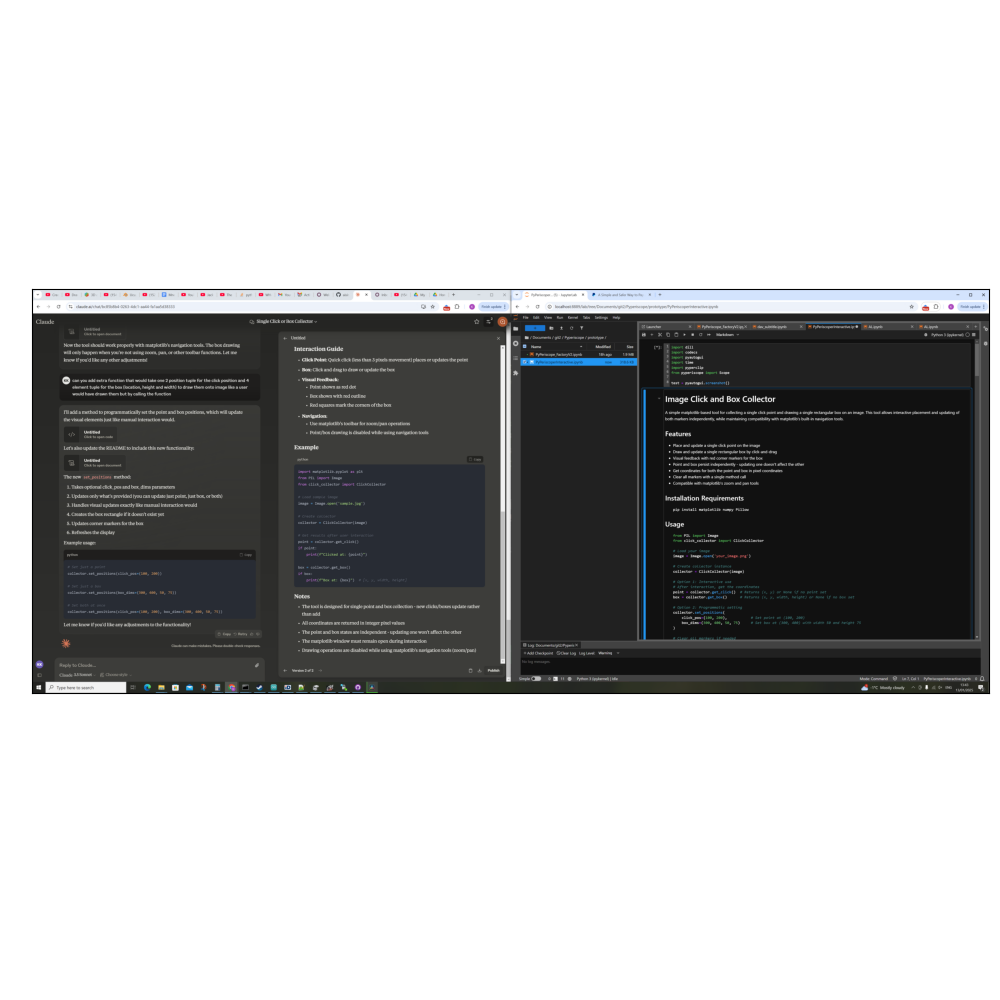

In [112]:
collector = ClickCollector(test)

In [142]:
def collector2scope(collector):
    #Check that collector has clic position and area
    if not (collector.get_click() or collector.get_box()):
        print("Collector must have area and point set before scope can be made")
        return
    #Get offset of the area box
    neg_size_comp = [0,0]
    if collector.get_box()[2] < 0:
        neg_size_comp[0] = collector.get_box()[2]
    if collector.get_box()[3] < 0:
        neg_size_comp[1] = collector.get_box()[3]
    area_offset = (collector.get_box()[0] - collector.get_click()[0] + neg_size_comp[0], 
                   collector.get_box()[1] - collector.get_click()[1] + neg_size_comp[1])
       
    area_size = (abs(collector.get_box()[2]),abs(collector.get_box()[3]))
    return Scope(mouse_offset=collector.get_click(), area_offset=area_offset, area_size=area_size)

In [24]:
import dill
import codecs
import pyautogui
import time
import pyperclip
from pyperiscope import Scope


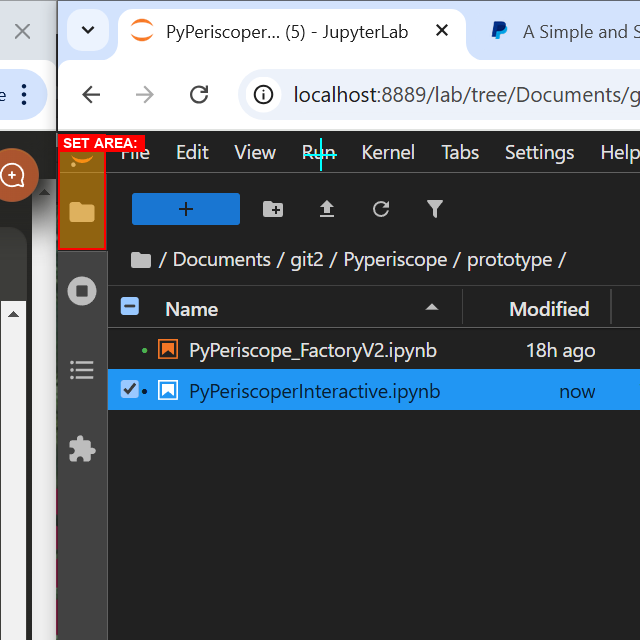

In [143]:
testx = collector2scope(collector)
testx.render_preview()

In [135]:
testx.generate_scope_string()

'step = Scope(mouse_offset=(2823, 154), area_offset=(-215, -20), area_size=(47, 115))'

In [91]:
pyautogui.click(testx.found_locations[0]['mouse_offset'])

In [144]:
# comment: Automated step generated with pyPeriscope V2 
payload = '''gASVxAgAAAAAAAB9lCiMBGFyZWGUWKQIAABpVkJPUncwS0dnb0FBQUFOU1VoRVVnQUFBQzBBQUFDL0NBSUFBQURsMXNLRkFBQUdRVWxFUVZSNG5PMmNNV2piU2hqSDcyUlBNU1NDWEFPMXdVbVhpclJnRDY5ZWJKeGtmQTFZcitXTnhkQyt0elIwVGFITDYvRGUxbVFON1ZJNmhPeU5WZHFPZlRYT2tpdzE5RDIwQkZ2RmVkQW9jQW1vVXhLOTRZeXFzeVZiSjh2V0ZlNC9oRVMrTy8zMGZkOTk5NTE4Qk5ZYjlUZTFONjFXNjlubU14Q2ZwQmp2N1JhOGRtMysvdjNmRGc4UFAzNzhHQ09IQkdHTWQvOHVYdndpMlhiY0NBQUFmdXlSQkdBU0FZSVFxbFFxQ0tGWHIxNlpwdG5mUUFKZ0VvNHBGb3VsVWtsUmxFcWw0dGtnWXIra1U3QXc1ekhtN093cytVVlJGTStPU2FiYktJcnk0TUVEVGRNYWpZYjczcjhzU0xjUWNCRWtPcFo5Wk5rSEpuaisrUUlBb0drYVFzZzB6YjI5dlFnNFZGVkZDQldMUmNKQkNOWnVlQmdnazRLWkZDek1BWFVlMXRyMjg4L214c2JHZ0pIWk9HcTFXckZZSk0rVVRzSDNxOE83WjFKdzdRYThPZ1dlN2w5RXhxSHJ1cTdyQUlEQ25QUnlPZUZjNzFqMi9ySDkzemNBQURpeTdIUUtYcDBDbWFudm5ycXpJQld1d050dno2UGhJSElnT3BaZGE5c2tBbngwUVh5bnpzTk1DcjViVGZxaGhPRjR1QWc3bHYzMDRITC82K1hReGtlVy9menp4VzZyRzBtRk9jbXpGM1ArS014SkJ5YTQvZlk4Q0VRUHpjOXZ6eDh1ZXFkTjVuemFzV3dtZ2g2YVB3NHUweWw0WlBVK1BMTmYrb2VJcERzdjY1dzBtWFZ1cUNhMHpnMFZSMzdoUW9LRGxnUVpOdzZlWlU1d3BWUGV0Mk91MXp1Vy9XY2hNYnlkRDhSZnQ3d2ZnL25oU0VKOHQ1cGN1OGxBazA3QnRadUo5NnZKRi85NlAzY3lSUDU0OGM5bFlUbXhka05TNStIK3NhMjFmVmNjc3VnREFFak50di9WZDRrT3MrNGZXZmJ2ZjErOFhFNlE0dS9PQXVoWUVybmUrZFp0azVrQzZSVE11S0xoZGV0eVFFa1docU1IQlFEZy9DejR0QjhNRVo3RFFYRnFMYjltQVN1bUpPdThCUUNVU3FYcjE2L3Y3ZTNwdWs1cXJjSVYrTk1WNkJTa3pxYmg0RGhvc1pLMEdTZXVxcXFxcWhLYUowK2VtS1o1Wk5tN2xyM2JJcDhQTXY0QU1jOWI5NGJNYjVNNENRNzNMdm5rNUNRcUR1YjRJRHZFMmRsWlhkZHJ0VnBrSEt6eFlacERkb2poeE0xNkd6ZEFWOHpyL3Bna3NjYkhtUFE5cjYrc3JNU0g0ZHBYZnZqd0lVWU9idDRuOHhFZVlqL1hJMjQ0N3Q3OU5XNEdBRGlhTDd6azliZ0J1dUxHSHJ4d3hBM1FGVGYyRUJ5VUJBY3R3VUZMa2lRdVVnZ1hFSUNqN3hza2lROE9DTGx3RFRkeHlzKzg1WVdEQzc4a21UZ1VSVkZWMWZNTWgybWFtNXVibm1kZGdvZ2hQaEJDang4LzlqdElnaEJhWDE5SENJWGpZSGhmV0N3V0J6Y2dLSDRuVFlpY0V4UDlIRkhHQjBLSXZHMGVqTkwveGxGS0pDWWRwNHFpbEVxbFhvNVk4cWx6Yk1uTklmS0hTNEtERmhjUWdDTjdDQTVLSW4vUTRvWWp1RjhpL0haeUpBNWQxME9YV3ozcS82S1R3UyttYVdxYU5pS0taL0VCV092VFJxUGhQaEVjb1g3QU9CMnJ1TEVITHh5OCtJVVhEbDc4SWpnb2NSTWZ2SEFJdjFBU0hMUzRpWSs0QWJyaXhoNjh4SWZnb0NRNGFISERFVGRBVjl6WVEzQlE0dWpjWjFmdGRqdEdEbDc4d3N1NVlHN3NFVGRBVjhJZXRMamhFSDZoSkRob0NRNWFZcjdRRWh5MEJBY3R3VUdMRjQ0a0FHQjdlOXV5ck1YRnhaZzVScGNzeTlQVDA3SXN6OHpNQUFCT1QwOHh4b1poc0hGVXE5WER3OE12WDc2RUlDaVh5d3NMQzlsc3R2OGpqUEhaMlZtcjFhclg2NEU0d3FsY0xpOHRMUTFvSU11eUxNdlpiRGFYeXpXYnpjRTBZVGhrV2E1VUtwNDI4R3UvdExTVXkrVzJ0cmI4MmpEUEYxWUlkOGRIang3SnNod05SemdJQitYZXZYc1JjRlNyMWRBUURrcTFXaDJKSTVmTGpRaEJSQ0kzUEVlNVhCNGR3bStvb1BNbGw4dDVoaGpHdU5sc25wNmVEcmhsZjBkWmxzbGtadWJJNS9PZTErdjF1bnM0VDNuKzI0TjhQdS91R05RdmtVU0dXOVBUMCs0L0EzSDBoOVhvSXFtV2pXTk1jc2ROSUE2eWlrWXU5N0M4MUVHQk9BWk15MUhrSGpZUUI4WjRIQnp1WVFOeG5KMmRqWVBEUFd4UWV6QVZlVUhVYkRiZDlnaWFUejk5K3VTWnlvWXVPbjZKdU9kMWZsQU93ekF3eHA0clJiai9WdE96R2dTZHR4ampJT1Z1UUdtYTFuT0ZJWDhZaGhGSmxCaUcwYjgwTW5CZ2pEVk5HM0VPWTR5M3Q3ZjdyN1BsVTR6eHpzNU9hQlR5Sko0Zk1lZDFnakswNXVpWFlSaGJXMXQrbmcyemZ5RXgyMjYzUFdzdHovWmoyVWVSb1VseXkyYXorWHplcjBvS1FqQVNoNXVtMld3Nisyd0F3TXpNVE1oOTl1aHl6Qk42aEIrcS9waUFCQWN0d1VGTGNOQVNITFFFQnkxZU9QNEh0UUZzTmJ5dkI5d0FBQUFBU1VWT1JLNUNZSUk9lIwNY2xlYW5fcHJldmlld5RYSCoBAGlWQk9SdzBLR2dvQUFBQU5TVWhFVWdBQUFvQUFBQUtBQ0FJQUFBQ0RyMTUwQUFEZmUwbEVRVlI0bk95ZGUwQlVaZnJIbi9lY21lRTJpSEpSQnRUUkVrM3h4cWlKdW9JVjNpSnBXVFcweEV0Um05U1dWcUpkcUMxcVM2eTB0ckF0MnJ5VmtocXBzWnJSTDZITk1CVXZpV1c0S2lxTXlrV1E0VGFYOC83K09ET0h3OHd3RERBd0F6eWYzTm1aYzk3em5uZk9EUE05eitWOVh2S3Y5TThBUVZ3ZVNxbmxjMG9wLzV4U0NwUnlsRktPTTNEY2J3Vy9YcjE2TmJEL0VPZU1GVUVReEE0a1VUUHZkZllZRUtSbHpFVlg5TDlHT0U1djBPdDErc3FiTitzYnRNOGt2K3ZjTVNNSWd0aUFjZllBRUtRVmlPMWdzKzFOaEpoeXpiVkVFQVJ4RVZDQWtTNkdtUzlhOEVJRHI3dWNVWDBweHpsdGlBaUNJSGFBQW94MFFVeitaN0N3ZlNtbEhHY1VZV2VQRWtFUXhCWW93RWdYUnB5QnhZZURPWTdqdDZJTEdrRVFGd2NGR09tcU5GRmY0M1BnWHdoYkVBUkJYQllVWUtUTDBEVDZhN25GcUxzY0p3b01Jd2lDdUNvb3dFalhnNEpGSHBaWkxCZ29vQUFqQ09MYVNKdzlBQVJwR2ZFa1lCQS9iOXBHcEw1dFB4ZkRnSnVFeUZncVlRbkxBQ0hBa0phUDRpaHdISEFVOUJ6VjZraUR3ZkZaMkN3RGNuY2lkd00zS1VoWndqSjJEUXhCRUZlRG8yQXdnSTZqS01CSUYwYWNmdFc0aWRmZzFrTUllTHVEcHhzaEFBQ3RFemVHQU1NQ0FNaUFlTXFBQXFtcHB4b3RVRWZJTUVPZ253L3hrNlBlSWtoM2dDSEFTRUFLQkFVWTZaSllobmdGTjdSWWp1M0gwNDNJM1lCMVVFeUdBTWpkaVljTXF1dWhUdHN1WjNndkR4TGNoemhxWUFpQ3VBNG93RWgzd0Z4eVc2bkFYdTZrbDdzang4UERNdERiRXhoQ2FocmFxTUVCdlVpL1htajRJa2ozQkFVWTZhbzBTYm9Db3orNkRmMzA5Z1FQbVlQSEpxYVhCN0FNM0twcjlZRkJ2WWt2dXAwUnBQdUNqaTJrUitQbFJqeGtIUzV5WG03RXk2MTFaL0gzUnZWRmtHNE9DakRTYzNHVGtGNGVuWFN1WGg3Z0pyVlhVT1h1Sk5BSDFSZEJ1amtvd0VnUGhSRHc4ZXpVTS9wNEFMRkRWUW1CQWI2b3ZnalMvVUVCUm5vb1hyTE9UaTFtR2ZDMHc5M3RMOGVjWndUcEVXQVNGdElOeWNuTHE2b290OTNHMDYxenh0SUVMemVvYVdpaFRTdm0rMUlLaEFEbGdCZ1ZtNnRVUTIwbDFkVURBSkc2RTY4K3hDZlExSmdEd2hnUFFSREVCVUFCUnJvaGVyM0JZTEJWQWtNbWNkaVUzMWJCTWlDVGdGYmZiQU1QR1pHd2RuZG5MQm5DZ0s1V2QzSS8vZDloZmNsWlduRlZSblVBb0NWU3htOEFHelNDM0RaSk9uWTJTRDBiRDBFUXhBVkFBVWE2SWFTbGVjQnUwczRaaVBWVDJ4QmcrNmNqVTBvSklRQ2dQN2xQbS9NSnVYYk9YVUowT2tvSmFUQ1c4ZEp4MS8vblhuR2gvdVErM2VITnNzaEhKV1BuaUE5RUVNUzVvQUFqM1JBcWtkbzI5YVNzMHhSSXloSm9mcjZ5aDEyT2NRcEFDQUhRYTdYN1V3MTVuN3NSRGxnZ0RQRnlJL1U2VG0vZ0FFRENFbmNaQXdBeWxrTHBPZTNPSk83S0tkbnNKQ0tSQ3AwNDVCMGhDTkkyVUlDUmJrakRnSkU2OXBLTkJzN1QzeFpPYmMrZEFhV0VBS1djb2Y3TE5SN245d05MTll3M08yQVVFM0E3MDF2QnluMVoxZzBBd05DZzAxVFFxbXVHNjRXR0s3L0thUTJjK0x5dXVzSTlMcFV3TEFVMGd4SEV5YUFBSTkwUUt1L0RlZHkwMGNDSjZ3alpQclhVamdBd0FRNElvLzNtVFk4Lzl0ZjZoMG9uTHZBY3BHSjZCNEhVdXYrYWF1dG9aWW51MG5IOUx4a2VmK3h2K0thUDIvM0poSEk0Q1FKQm5Bc0tzQXV4NDR1dDlqZGU4R0I4eDQzRUlXei9mQ3NBakI0ek5uVGtxT2JhRkp6NTlmU3Brd0N3OENGSHZoMmlyU2VjemtZRHhublNZL3ZVZHQwWkVNWnc1cURoOXg4TTk3L3BNZm8rd3ByK2lqa0RVQTZJTVFKT0NKOG16UkNaQitsN085UDNkc200ditoTzdERjgvNkgrOW9tU2tUUGErMDRReElWNTZhV1hjbkp5ZnZ6eHg4NDVYWEZ4OFlvVks5NTg4ODBoUTRhWTdUcC8vdnp6enorL2NlTkdmMzkvczExNEM0eDBGQ05IalFhQTA2ZE9GcHo1MVdvRFFYM0hqQTF6N0tuWmloSmd1dTNOSmEycjVDcXV1Qy85bUEzN00yRWxRQ2xRRGlnRmhnVldDb3lFc0JMQ1NvQ1JBQ3NGaGhVYUVGWWlIVC9YZmVuSFhQbGxxS3UwODNSNzkrNGQxSlNOR3pmYWMrQkxMNzFrZHVEeDQ4ZmI5cGI1cnRScWRkc083eXBzM0xoUmVKdVdsMzN2M3IzQzlqWmZTVE9tVHAzNjBrc3ZPYVNyRHNYMXgvbk1NODhjUFhwMHdZSUY1OCtmRjI4L2YvNzhnZ1VMamg0OSt0UlRUMWtlMVcxL3BMb3VMWnEyclRLVW5jaW8wV01NQnYxdlo4K2VQbldTWmRrN2hvOFE3LzM5dDdPOCtvYXB4cG50YWo5TXhWVnc4M1ZVYnlmeWoyNUszNWk2ZnFPYm0zbUtWRU5EUTlMSzVVc1Rsb2VwSmpqcWRDM0RTS1hoQzBIbWFaemFTMGdMNlZUaUJwUmorZzJSOVFtaWxMYktEZi96eno4ckZBb0FPSDc4K055NWM0dUxpMTkvL2ZVV2p4b3dZSUJnZ216Y3VISHUzTG52di85K1RFeE1hODdjVTFDcjFXdlhydDI5ZXpkL25ZdUxpOFZYVHlBbUpvWTN0anJOdG1zLy9IZEcrQXAxUzk1KysrMkZDeGRldlhwMTRjS0YyN2R2NSszZzgrZlBMMXk0c0t5c3JILy8vbXZYcnJVOENpMWdwQU1aR3padStJZ1JBSEFpLy9qdnY1MFZ0di8rMjlrVCtjZWhZOVFYQUVoZE5WdDF3eUZkblM4ODkrUmppLytiKzhQVGlRODNORFFwb2xGZlgvOTA0c1AvemYzaGIzOWRjcjd3bkVOT1p3L0V6YXRSZlZ0OU1BT1VBNWtuY2ZOcTI5bkhqUnYzL3Z2dmI5dTJyYlgyNlBMbHl4Y3RXclJ1M2JvMm5QVDExMSsvZE9sU04vNzVCb0FQUC93d0lpSmkzTGh4L012aTR1TEJnd2RiYmJsOCtmSXJWNjd3Qm5HWG9MaTQyTmxENkhBR0RCaXdmZnYyL3YzN2w1YVdMbHk0OFB6NTg3ejZscGFXOXUvZmYvdjI3UU1HRExBOENnVVk2VmdzTmJpajFSY0FLTU9TVzJVTzZXclE0TnNuVHBvS0FFZVBIQlpyY0VORHc0b25Iamw2NURBQTNCbitwMEdEYjNmSTZWcEJHOVMzblFlYUNBNE9Cb0NTa3BJMkhIamx5cFYybnIyN3NtM2J0cWVmZnRyT3hxdFhyOTYxYTFlSGpnZHBMYndHQndRRWxKYVdQdkRBQS9Qbno3ZXR2b0FDakhRQ1k4UEdqUnc1Q2dCTzVCLy83dHNEdlBxT0hqTzJnOVFYQUF3Ky9jQmdLd25MZmlRU3lkdnZmUlExNDE0d2FiQldxMjFvYUhnNjhXRmVmYU5tM1B2MmV4OUpKRDB4bXJONDhlS3BVNmVhYmJRL1NMeDQ4V0xMOExCYXJlYmpuZnhlUHZMSEIwZUZBL21YUElzWEx6WTd1MW5RbEVjY2tEWWJNeDlmUEg3OGVITjlOamRVNFZoK1BKYVh3bjc0b1FybUx3QmN2bng1NE1DQnpiVy84ODQ3YzNOekhSc1VON3ZJWmx2NDJMTmFyYlo2S1d4OEU2Wk9uY3FIUHlkTm1pVCtialIzd1lVVFdYNklWcGs2ZGFxTkR3NmFmaVhzdlJadGhkZGdYMS9maW9xS216ZHY5dW5UeDRiNlFqZUlBWGV6ek9IdXlxZ3hZdzJjNGJlelo4dktTcUVqYlY4akJoMXR0NTBud0RETVcrOTg4UG9yejMvOVZjYlJJNGRYclhoY3A5UHg2aHM3ZDhHTGYvOUhUNXRSKzhzdnZ3REF1SEhqbm43NjZibHo1eDQvZmx4UUR2N25jdm55NVZZUC9Qbm5ueU1pSXZqblU2ZE9IVHg0OEtWTGwvaWo1czZkdTN2M2JxR2ZkZXZXclZxMWFzdVdMWmFkdlBUU1M5dTJiZU1QNUYveVQvaEE0K3JWcS9tekh6OStYUEI4OHRvZ0hNSkxpRGdrbVpPVGMvbnlaYUVCLzFNdW5OMzJVSE55Y2lJakk0VmoyMFp4Y2JGd1pRUzJiZHUyYmRzMi9ybFpBSlUvZTBsSlNTZTc1Ujk0NElFTkd6YndWNFlQNnZPWHdzWTNZZm55NVh2MzduM3FxYWZFYjRIZklsekdxVk9uaWk4NGZ5SjdZc1o3OSs1OThNRUhoZThiZjhjbXprNFlOR2lRMmVmZXprK3FSZHpjM0tpcEVsK0x2d3hvQVNPZGhKdWJPOE1RQUpCSVdOcFNxY2gyUWlwS0tHZXJGblNyT3lUa3BWZmZ2RC8yQVFENGIrNFBSMzcrTHdETWkxdlVBOVYzNzk2OWE5ZXVmZi85OXdGZzNMaHhBd1lNeU16TUZQYnUyclZyMGFKRlZnOTg2YVdYY25OeitWU1VqUnMzWHJseVJmakJqWW1KaVlpSWVPKzk5NFRHa1pHUnplVnFYYjU4V1h3SzRkZDI3dHk1aXhZdEVuNkx4NDBieC9mQW4wdWNzclJseTVZQkF3WjgrT0dId2hieFlBQmc5KzdkdWJtNXZIblg0bERGWTJnenhjWEZadmJ1bGkxYkxwbFl0R2pScEVtVHpES2ZCd3dZMFBteDFRY2ZmRkNRMk9YTGx3dVhvbFhmQkFCNDZxbW5WcTllTFhTMVljTUc0WUx6ckZxMXlwNTdpNWlZR1BIZDN1clZxM055Y29TWFY2NWMyYjE3dC9CU3VHOW9zZHMyYytYS2xZVUxGL0syTDI4SEwxeTQwRWJZcGN0YndHalVkZ21FR1VjS2hVS3RWcDg4a2M5eG5JMzV3ZTJFQzdxRGxsMXpiSitFa0pkVDFrcGxzbDBaMndEZ3dmaUhuMTJkN05oVHRJNjJKV0cxOWNCSmt5WUp6OFdteVlNUFByaDI3VnBlZ2RScWRXNXVydmduNzhxVks0TGZiOENBQVlMeDhmUFBQNXY5T2srYU5PbUxMNzRRWHQ1NTU1M05qV1Rnd0lIYnRtMjc4ODQ3eFFyTi8zWS84Y1FUbHUwdHp3VUFrWkdSNGw5cXN3YThNQlFYRjQ4Yk42N0ZvVVpHUmpZM1ZQdTVmUG15K0FxYjhmcnJyMSsrZlBtOTk5NFQzeVVNSGp6WXFnRHpuZ0RoNWFKRmk5cC9meUR3NXovL1dmeFNmQ2xzZnhQTVJtaldsZmlDODFzbVRHakZ0SUxGaXhmbjV1WmFiaDh3WUlEWXF3OEFFUkVSSFhmWHdxdnYxYXRYQXdJQ3RtL2ZEZ0Rpdkdpcmp1Z3VMOENJNjJNMjQramtpZVBOelUxeUZGUXhoSklPV1cvaCtlU1VYcjE4Q0NHSlR6M2JFZjNiQTIyb0lZUzBNUkdhUDBSYlN5bHRWU0owYy83QVAvLzV6MnZYcnVWOWoxOS8vYlhaVDU3VmlUUUFjUEhpeGR6Y1hNRy8yaXBlZi8zMTRPRGdwNTU2NnFtbm5vcUlpT0ExeWNhdjZzV0xGeTJEcVh3ZW1UMjBaNmdPWk5La1NWYm5zVmd5YnR5NGp2YXlXc1gyTjBFTS8yRlozbkMwUVJyNWVNU2lSWXY0dDd4eDQwWTdyNUxETVZOZmZoclM5dTNiYldzd0NqRFNzZng2K3RTWlgwK0RLTzQ3Tm13Y0FQeDIxcGdMM1NFYXpERE5yM2ZRWHA1NCtybU82dG8rQ0tmVC9ySkxjc2MwcHQ4UUFBQktqU3NyTk9jTUZ6Y2dESGY5dk9GY2ptVENYT3VOVzRsQ29ZaUlpTWpNekJ3M2J0d1hYM3p4NElNUDJuUFU0TUdESXlNajIyeVo4WkZGdFZvOWFkS2txVk9uMnA0UmEzVXlqKzNmZW5GeVV6dUhhaWNEQnc1c3JmeGN2SGh4M3J4NTdUKzEvZmNpbG9qSGJQODNnVDlqKzZjRnE5WHFiZHUydFdwbXVkVzdNWWZ3M0hQUFhiMTYxZC9mWDFCZkFCZ3laTWoyN2RzWExGaHc5ZXJWNTU1N0xpTWp3K3dvakFFakhjakpFOGZOMUplbnVmbkJEdVBHSmJqWmZhc21lZlJtL0FiV2IzcE1kMnczR1BTOHJBSWh3Qm5Bb0FOT1R3MTZhdEFEcHdlRERqaUQwSUFhOVByOHpQcE5qekcrQTRoSGIwY05aOTY4ZWR1MmJUdCsvUGlWSzFlYVM3OHlZK0RBZ1dJUGNOdFFLQlR2di8vK2xTdFgxR28xL3hQODlkZGZXemFiTkdtU3BmMmFrNU1qVmdpendmRDk4SDA2WktndEVod2NmUG55WlJzTnhQbHJQRmV1WEdtUGRncWRDTjUrdmpmeHpZZmxQY0hSbzBmRkw3ZHQyeWErak0xOUU4ekdHUlFVWk5sVm14RjMvdlBQUDR0MzhkOE40U1Uvc05qWVdJZWMxNHgzMzMxM3dvUUpPM2JzTUN0Rk9XVElrQjA3ZG93ZE8vYmRkOSsxUEFvRkdPa29majE5NnJlelo2R1puT2VPMWVCTHArSGFSUnY3T3pnSnpCWU9TQTZqbkdUa0RQYU91NlRmdkZTM01VNzN5NWZjamY5UmJWMXpwU2lwdG82V1h0QWQzVm0zY1lGazd3dnNIWGV4STJjQWRWaVNHaTlVSzFhc3NKRjBZOGJycjc5KzVjb1Y4YVNSalJzMzJsbFpRbnpVTDcvOE1tREFBTjZRV3IxNjlkcTFhNFZPamg4L0xrN0pGaytTV2J4NHNabENYTGx5Ulp4TnZYYnQydFdyVjdkdHFQeDhKNkVyOGNTYnFWT25OamRWS1RnNFdCekY1R2Y3aVBzVTh0ZUVuc0drWkczbXBaZGVFanVLK2JDcmtKdTJkKzlleXh1WHA1NTZTcEEwZm9UaXk5amNOOEZNY1JVS3hlclZxNTk2NmltekNWMnRIVC8vdVFzSmNSczNiclNNQkQvd3dBUEM4N2x6NTRwTG5UaVc0T0RnblR0M1doYUNCb0FoUTRaOC9mWFhWdStXMEFYdGNuU1ZTcE10d3R1K1k4YUdOZWRrSGhzMmptWFlNMmQrUFpGL3ZHTm5KVm5BVWFldFNNaTFXL3NwTUlSUzJYM1AxOVhjOURpL0g3NTVXVU84MkFHajJINGh4Q2NRNUw1Z1dvNFFoT1VJcjU2UmN4cXBoTlFObmUxKzMvTkFLWFhvaWxDOCtMWEt0cmgwNlpKNGFxWVF6YlVIY1dLWDRIOWV2bno1blhmZU9YZnVYS0hvcm1BUFhicDBpWitDSXB6TExFcTZhTkdpNE9CZ29ZR1pWN005UTdXVG1KZ1lYcEI0ZVZBb0ZMbTV1VmJ6MTNoKytlV1hpSWlJdHJsd2VkYzlXRVRvRlFyRjd0Mjc1ODZkeSt2dW9rV0wrSTlWZk96UFAvOHN4RzR0UndYTmZCTUV4ZVdUbi9rSUFnQ0lrOFdheTlnU0VFL0tBdE9ud0krSHYxQ3JWNjgyRy9DQUFRTTJiTmdnWEViSDVxTTVCUEsvSzllZFBRYkVTRGViMDd4dnoxZTMzUjdTWXFyejZWTW5paTVkbkhQL1gyeTA0YWN0VVVvcHBVQXBCY3B4bE9NNGp2OC95bEZLT1FPbk4rajFPcDFPcDNzaThiSHFXN2V5Y2d1YjY5QmZUcVJPdXZsczBFT0ZwbGtSSHRuZkhxY1VCU0FBRlBRNjdmNVVROTduTXNJQkFNc3lBRkN2NC9RR0NnQVNscmhMR1FBd0dEZ0EwRktHRFg5SU5qc0pKRkxqNGJZclNMZUdUbDU1eHJGTW5UcTFFNks4TGNLYjRIWU9ZOUNnUVoxY1ZkdHlMcTlWdXZRM29mTkJDOWlGY0gxTmJSVzJOVlZnOUppdzBXTWN2QnBTaStnNEtuV2MvTFFLUS90TllDREFyelFva2NubXZLUWZNS1loNXhOeTdadzdvYlU2U2duaGx6elVVMXJUd0hsS2lkWUFOSENZTFBKUnlkZzVBRUFwSlFRY3FMNEFzRzNiTnNGbmk3U05KNTU0WXRLa1NiR3hzUzM2U0RkdTNEaGd3QURYWE5NQ3Z3bXRBZ1VZNlk2MHBISDFPdUlwNjVTUldEdDF5K096QTZFQWlHVHNIRW5vUGJxVCszWC9PMHhLemtMRlZSblZBWUNXU0lsdmYxM1FDTW50azZWalo0UFUwK3hBUjhHSEV1MU12MEthZzg4cGEzSFZJTDRRaWxtMmtZdUEzNFRXZ2dLTWRFTWtFZ25Mc2pZYWFQV1U0d2pUNlRtSWxBT3QzbkVKWUpRQ0lVQTVrSHBLSjh5RkNYTWxsV3FvcmFTNmVnRHdrTHFEWjIrbXQrbW5uSjhCekIvaUlQaFptQ0NxOG9pMGg1aVltQmJ0V252YWRENzRUV2diR0FOR3VnQ3RqUUZuN2YyNjZOTEY1TGR0RlUvdzlnQzVXMmQ3b1RVTnRMck9WZ1A3WXNBSWduUUg4SzhkNmFGbzZzSFF1Wk9SREJRMDliWWFTR3daN1FpQ2REZFFnSkVlQ3FWUVZkdXBaNnlxYVdIK3NkUlpVNk1RQkhFR0tNQkl6NlZCMTRKRDJJSGNxb09HbHFLL1VyU0FFYVFuZ1FLTTlHZzBEYlJXMitHZTZGb3RyV2xvK1N6dUhiSitCSUlnTGdwbVFTTTluYXBhMEhQUXk3M0QrcStEMmdhN1ducDMyQmdRQkhGQlVJQVJCR3JxcWNGQWVua0E2MUNYa040QTFmVlFyN1BMd3BZdzRDSERHRENDOUNCUWdCRUVBS0JlUit0MTRPbEdQR1VPaU1YcURGRGJBSzF5YnZmeVJQVkZrSjRGQ2pDQ05GTGJRR3NiZ0NYZ0ppTlNocklza2JKMnJWckFVZEFad0dDZ09vNDBhR2tiSmpnRmVLTUFJMGpQQWdVWVFjd3hVS2cxNWt5MUlUK3JMU2xkL3Q0RVU2QVJwS2VCV2RBSTRtUVlCczFmQk9tSm9BQWppSk1aNEVzY20veUZJRWlYQVAvdUVjU1pCUGNoM3U1by9pSklUd1FGR0VHY2hxSTM2ZU9GNm9zZ1BSUk13a0lRSjhBeU1OQ1BlSFg2Y2t3SWdyZ09LTUFJMHRuNGVKSkFIMHg3UnBDZURnb3dnblFlTWdrRTlTR2R2dzR4Z2lBdUNBb3dnblE0TEFOeWQrTHRCcjB4NG9zZ2lBbkpiZjM3T25zTUNOSUNsRkwra2NmQWNUcWRycUZCcDZscjBHaHFPWXZTRjNKUE53OTNtZFd1R0FaNmV4QnZkNUJKN2ExeWhTQUkwaEdnQll4MFBSaENwQklKeXpEdWJ0SSszaDZWMWJWVjFUV2NnYk45bElRRmZ6bnhsUk1VWFFSQlhBRVVZS1JyUXdqeGtYdklQZHl1bDkyc3J0VTMxOHpiZ3d6d1JlbEZFTVNGUUFGR3VnTU1RL3I2K1JDQWlpcWQ1VjUvYnhMb2c5cUxJSWhyZ1lVNGtPNURIeDh2VHcvelJlMTdlNkw2SWdqaWlxQUFJOTBLLzk1eUNkczR3ZFpkU3ZyN292b2lDT0tLb0FBajNRMGZ1WWZ3UEtDWEV3ZUNJQWhpQ3hSZ3BMdmg2ZUhHUDVHdzRPT0I1aStDSUM0S0NqRFNiVUgxUlJERWxjRXNhT0FvM0txajlUclE2VUhQVVowQmRBYWdGclVkRUlkQUNFaFprTElnWVltVUJROHBlSHM0Zm5hUVZrOTFCdHJMbytXV0NOSXFEQnpWNmluSFVZNVNqZ09PVXZ5dFFOcE16eFZnQXdlMzZ1aXRPcXFwQi93TDZqUW9CYTBldEhvQTAxVW5RT1h1ME11RGVIc1FpVU05TWg0eXRJQVJ4NkEzVUsyZTArbzR5N0pyQ05KbWVxSUE2em00WGtWdjF1QmZra3RBQWFycm9icWV3azNheDR2MDYwVWtEbG9tQ010dUlPMUhxK2RxR3d4Y0MyWFdFS1F0OUN3Qk5uQlFXazNMTmVnMWNsRnUxdERLV3Vvbkp3SGVoTVg4Qk1TcDZBeTB0dDVnUUpzWDZUQjZrQURYTk1DVmNrNlBkN0t1RGFWUVZrMHJhK2dBUDhiTHpkbWpRWG9xTmZXR0JoMytXQ0FkUzAreE1rcXI2Y1ZTVk44dWc1NkRpNlZjV1RVYUgwaG53MUdvcXRHaitpS2RRUGUzZ0RrS1Z5dTRXM1hPSGdmU2VxNVYwVG90QlBzU0RPWWluWU5PVHpWMWVyenZRenFIYmk3QU9nTmNMT1cwemE2Umc3ZzZWWFcwN2pvZDRFdmNwYzRlQ3RMZHFXc3cxR25SOEVVNmorNHN3SlJDVVJtcWI1ZEhxNGVyRmR6dGZYdEt1QVJ4Q2xvOTE2TDZzZ3lSU2hncEM5TG1KOHpwOUp6T0FEbzkxMkhaVzRSU2lrNmg3a0YzRnVBckZWeTlsYlhwa0s1SHZRNnVWdEQrdnM0ZUI5Sk4wUnVvcHM1Z293RkRpSWNiNHladCtTNVFLbUdrRWdBM3BrSEgxV2s1QjA0Y0pnUW9CMEJRZmJzUDNWYUFyMVZSalB0Mko2cnFxRnMxK011ZFBRNmsyOEZScUs1cjFsRkdDTGhMR1hjWjIxclpjNU15TWdsVHJ6WFU2N2oyejNza0FCd0ZsTjV1aG9NRm1ISkFHQUNBK29xRzZwSzZtNzlWbGY5K3ErWmFYWTI2RmdBOEZSN3lRRSsvNGIxOFIvaklGUjd1ZmR6RWh6aVFXaTFnQW0zMzQzb1Y5WFlqc201NzA0ZzRoNW82ZlhNQ1NRaDR1Yk95dGxab0l3UTgzRmlXSlRYMWhuWnFNQVZBOGUxK09PekhqRkpLQ0NFTTFKVTNYRHFvTHM0dHJiNVVJeUV5QTlWeFFEbktBVUQxaGJxYUMvWGxQMWRydVl1OWJ2Y00vbFBmd1RPRDNIMWx3dUdPR3N6MUtzeWs2SjZvcXppbEgvNFFJUTVEYjZBNmczVnRaQmdpZDJjbGJIdS9ieklKdzNnUVRaMmhiWVl3SVZpYXZ0dmlHQUhtNWROUWIvajl5NklyLzNkZFgwb05uSUVqbkJicUtWQ2gxRElGVGcvVUFBWmdvT1pDdy84dWxWeis3dHFBdS9yZXNXQVFJMlVjcGNHYWVxaHBhSDgzaUN0U1V3K2Flc0FDSFlpanFHMndIdm9sQUE1Ulh4NEpTK1FlYkhWdFd5WTRjUng2bnJzdGpoRmdRb2krVG4vNjAvOWQvYzhOamxJRG93ZENxWVVWeWxlQTVCLzFqRllQUksrV0ZHNHZycS9Talg1a2lNVERNU1dBMVpWby9uWm5ybFZ5dC9mREh5VEVBV2oxbkw0Wjg5ZkxjZXJMSTJHSmx6dXJxYmVWNm1VVlZOOXVUSHVqcjVSU1NzRlFiOGg3ODB6Si9uSWQxUmxBUncyTjZrc3BGWFJYZUE0QWxBUEtVUVBvOUZSYnNyLzh5SnUvR3VvNVNxR2RaWm9yYW1nRHpqdHlZWDc4NlpjNTh4K05lZURSdkYveTI5WkRneDRxY0NFTnhCSFVOaU9IYmxKR1prZkNzOEZndUh6NThyRmp4NjVjdVdJd3RLeXNNcWxkZWRSSXo2SGRGakFGd3NDcDlNS3E0M1VOdEk1WFQ5NlR6RXVwNEZVMmN5OFRRZ1ExYnFCMWxjZmg5S2VGWVU4TW8xeTdrZzBxTlBqVDdMcFVWdDE2N3FVM3RWb2RBS3g4L28zdjlteVZ5ejNiMGs4TjdlMENhLzFldjM2ZFVob1lHT2pzZ1RSTFRVME5JY1RUc3kwWHVhT3ByYTB0S0NpNGV2VXFBQVFHQmc0ZlByeDM3OTc4cnV2WHJ4ODhlQkFBNHVQak8yNEFPZ08xT2tXSUVQQjBzK1dObzVUdTJyVnJ6NTQ5UjQ4ZWJXZ3docnZjM053bVRKZ3daODZjQng1NHdFWW96Y09OMWVvZGtCU05kQS9hSjhBVUNFTXVaQlZmenJyT01SemxqTUZnem82MXU4VHlURG1vWitxTHZybm1NMGgrVzNSd200UEI5VHJBaWIrdXpJMnlDbDU5QWFDK3Z1SGFqZEloY21VYitxblRnZDdnNU5VR3k4cktWcTFhcGRmcjE2MWJGeHdjN015aE5JTkdvemwwNkJERE1IZmRkWmVIaHd2Y3NKZzRkZXJVenAwNzgvUHp6WDRvYnJ2dHRtWExsazJZTU9INjlldWZmLzQ1ZExBQWE1dXA5dXhoYzhiUkgzLzhrWlNVZFBMa1NmNmxuNTlmY0hEdzFhdFhLeW9xL3Z2Zi8vNzN2Ly9kdm4zNzIyKy9QV1RJRUt1SE13UThaR3h6Z1dkclhQMTh6bDN2WElyKzROY05rKzArcG4za3JobjF5TUZCTDM2emIybVE4SExXcC9ucklqcnAvRjJTcTN1ZlhyNmpaT296TzVQRzI5VSs3NS96My9oNThvdnRFMkFDZFdYMUJaLy9qeENHY28xZktWNWNHWllCQU03QUFRRERNQnpIQVFIQ0VFSUovNXdoRE1keExNdFNTb0VDUTVpelgxeFFoUHQ3K0xVeHgrWlduYXZmV0I3SXpuMytsZFFEbVp2NjlmVjN5Z0RDcHR6MzFQS2x5eGJOYzhyWmg5NCthTUs0TVVlUG53S0F5ZUhqaDl6V0Z2WGx1Vlh2VENPNHJLenNtV2VldVhIamhyZTN0ejIrUjZkZ01CajBlcjFlci8vaGh4OWNSSU1wcFI5Ly9IRm1aaWIvY3VEQWdUNCtQblYxZFpjdVhkTHI5UmN1WEVoT1RwNDFhMVprWkdRbkRFWnJiVzBXbGlIdXNtYTl4RjkrK2VVTEw3eWcxK3VIRHgvKzdMUFBUcGd3d2NmSGg5OVZWVldWbDVlM2J0MjZreWRQenBvMWErM2F0WFBuenJYYWladU1hZEIxWEoyczdreGx3WjVQTjIwL2ZhbEdCMUxQUWFxNVM1K1lIZHBIM0VCN0kzZnJoczI1aFRkMEFOS0FZUkVQcllxZjBrL1dwTVgxdzV2VzdUaDBya3dISU8wN1pOcVN2eTJOQ0dqUzR1YlpyQSszZnBsZlZLc0RxWmR5U3VJemo1bzFFUFByUjB0ZU9IYm5QOUtmNk5OY0M5dTAxd1g5djIrS21TcHBBOVFTM25GTWdSTEtXN2I2ZWoybnB4SVBsaEJDT1VvWUFoelYzdElURnFRZUVrb3BCYU81ek51N090QzZWM2xlK3JaaytJT0QyemFZbW9ZMmZxZDVYVFRmbUxtcFgxLy8rK1luQU1BM085UHQ3T1ROVjVObVJlR3RZck44K002ckI3SnpwUkxKOUx2LzFKNStxcDBud0lMNnVydTdwNmFtRGh3NDBEbmphQWtmSDUvSXlNaERodzdWMXRhNmlBWi84c2tudlByZWRkZGQ5OTkvL3gxMzNNRnY1emp1MUtsVHUzYnRPbjc4K0lFREIwNmZQdDNSSTlFYnJHZWIySWpSSGoxNmRNMmFOUnpITFZpdzRJMDMzbURaSm01cUh4K2ZtVE5uM25QUFBjOCsrK3llUFh0V3JWbzFlUEJnbFVwbDJROEJrTEFFQmJnSnhkKzg4dExibCs3ZXRqbStmM05OYW41SmZXN2RqN1c5aDkyek5HWTQvSHJnNndOYi8zN20vS3IwdjkxcHFzNVR2T3VWRlp1THBNSGpIbng2VXUvS243Lys0dnNOQ2VkdmJId3pWdWp6NnQ0WGwrKzRKRlZNV1BMWEtiMnJmdHExKzd0MVR4ZmVlSHZkdkNDaHdTcSt3WU4vbmRLNzZ1U0IvWWZXUFgxSjNLQUoycDkyNWRiMm5YUHZLSUNyYlh2Zjdjb0lxQzJ0TC9xL2F6cXFBeUY1aWdBQU1Dem9hdldEcGdmOTZiVXhVcm1FMDNIQUFxZmpPQXJqVnR4eFoxSW9zSVJTWXhoWUNCaFRDanFEOXRKM0pYVmw5VzBiVDUyMlBlOEdEbVJ1T3ZIVE44SS9aeG1wTGtMWWxQc09aT2M2dkZ1cFZESm45dDJ6cGtld2JMdStlelgxNEpRZk1FRjkzZHpjM256enpjR0QyM2l6MkRuMDZkTW5NaktTWlZsZWcrdnFuRmtjN3ZEaHcxOTk5UlVBUFBMSUk2dFhyeGJVRndBWWhna0xDM3ZqalRjV0xGZ0FBQ1VsSlIwOUdLdm1Md0JJSmRhOXp3YURZZVhLbFJ6SDNYLy8vVys5OVphZ3ZucTlmcytlUFlJWFJDS1J2UGZlZS9mZmZ6L0hjVTgvL1hSejNoRjdNcng2Rmhlejl4MHJycmJWNHRjZEgvNVk2em5ycFUvZWZpUTZZbkwwRTY5dGVIR2NaODNQbjJ5L1pHeHdNL3ZEelVVdzdPRVBQM28yTm1yeVhmT2VmZS85T1VGUTlNVW5PU1pkcUR5NFljY2xHUExvcCs4a3pZdWNFaFdUOU5HYmZ3NkdTNXUzL0dCc2NlbnpWM1pjOHBxMGFvdXh3Uk52di9mR0xQOUxtOS9KdEtxdk43L1B5b2VRbU5udCtBMW8xL2RBYzdWV1gyN1FndzZvS1pvTGxBQWhoSEFObk85d240RjNLVmdaeTNHVU1FUlhveC96V01nZDh3ZVZucnFwcTlZeHJGRjlHNFBCRlBSRXI3MXVxTDVTMjdieGRNUTk1VGM3MCsweGZ3RmdWbFRFaVorKzZSN203L1ViWmM0ZVFndFFnSVpPai9jTDZpdVZTbDkvL2ZYaHc0ZDM5Z2hhajYrdjc5U3BVeG1HY2E0R056UTB2UC8rK3dEdzV6Ly9lZjc4K1daN3IxKy9mdnIwNmRPblQ2dFVxdWFpcDQ3RjBNenNJN2FaeklKZHUzWmR2WHAxd0lBQnFhbE5YR1dmZmZiWjAwOC92V25USnZIR3RXdlhCZ2NIWDdseVpkZXVYVlo3azdJT0xEdlVNN2h4NFh3dHdOaHhJNFF0WHVHUll3RXFiNXArcWk3OFZnZ1FGRDZpMFJuY1AzSmFNTUQxcWxMajY2S0Njd0RCNDBWZTY2QnBVUXFBMHNvYmZBKzVoMjVBMEx5NWR6WVd2SlVOZlhUdVdGQi9sMzNKY2tnWDkrd3ZoTkhSczN1MzQyMjFTNERWdjVRVHl2RE9aNk9PQXFGQUtWRENFRU85Z1hJVUtHV2tUSDFGdzlDNUErK1lQeWovdzkvLytPcXkxRXRpNWdBU0RtY0lxLzdGMVgvOUVWZEEzN214VjBGOUpSTEphNis5Tm1yVXFFNDlmVHZ3OS9mLzA1LytSQWh4b2didjM3Ky9zckt5VjY5ZXk1WXRzOXg3OE9EQkpCUG56NS92aFBHMDlsNTk5KzdkQVBETU04KzR1VFhKVUltSmlVbElTSWlKaVJGdmRIZDNYN2x5SlFCOCtlV1h6WFhZbk5MYlJjUFZIOVkrOUpmSklhcFJJYXBSSVJGemxyOS90TlJLcStMdjNsNDJNMklVMzB6MWw1ZStNLzJ3M2pyOTVZb0YwMEw1dzhObkx2LzgxSzJXVDNycjVLNVZNUkUyRHJsMWN0ZXFtT25qK05PRlRwKzNldS9GcG0xdS9XL3ZTMElEMVYrV2JUOEhBSkM3WmxTSWFua1dBRnhLdlVzMUtrUTFhdWJueFFERmU1NS9jTTZTVlh1TXpwQyt0dzN4QktqVTFEUjJkN08wRk1EVHk1VGlmOXZ3RUlEYTY2SUdVRmxTQ1NBWEpnRW9RNGNCMUpRMmFYRzFDc0RMeXdzQUFHNVVWUUlNNnQvVTJ5d0xHUkVNcFdmTzN6Ui91MmYvYzZETTg1NllLYzNHaHlzTDlyeXpLbjdKL0RrUHpwL3o0SU9QdkpYNWU0MUZtM1lKOE0zQ1d3WnFhUEpkSmtDQUVDQ1VVTUlRd2hDSkc5dHdVeHM0d2YvT1ZTTXY3QzgrKy9sRno3N3V4b2I4RWVKYlFRcDZUbi96dkUxWFJPZVN1REk1Y1dVeS8veEFkbTdZbFB1dTN5aExYSmtjTnVXK3NDbjM4UkZpbnBPbno0Wk51ZS9rNmJQQ0ZyNE4vMCs4bmU5VzJOWGNxUzA3Tk50eTMveUVmNnhMNHpmeS80U2hXajJSMlJpdTN5Z1RqL0N6YmNhNzlYK3NTNXNWdXhRQW5uOGwxYXhQY2ZzV0w1MVZTdFEzWG4zenZkZmVldjk2YVh0dnN4eTR6a3lMQ09yTE1NekxMNzhjRmhiV2FhZDJDSDM3OXAweVpZb1ROZmpISDM4RWdMdnZ2dHRNd0p4RnEyWUNWVlpXL3ZMTEx3Qnd6ejMzbU8zcTE2L2ZTeSs5RkJBUVlMWjl4b3daQUhEOCtQR2JOeTErdVFHZ1BlVTF5cjU1NXE2N250MTJVamJseFRmZlMzc3o2UytEcTdNM1BUeDV3ZGIvaVZ0ZC9QcWg2Yk1TdnpqdE5qbHAvVHZ2cGIzd2NJVGZyVExlMDFxeWRmN1NsQ3p0SFV0ZmVDL3RuZVFsdzZxejMxbTA2UE5pMjJmOTdmT0g1LytyNU02bjNrdDdZZEVZN3hMelF4cCtYN2RneXZ4L0hDZ2Q5TUJyNzd5WDlzTERFNzNQZmZYM21HbHIvbXZTNEliY1YyYk4rdnVlaHFHTFhudm52ZlhQM245YjliRWo1UUFBdzVlOWwvYk9vakVBNERmcnRYZmVTM3ZudmRjbVc0bitqVnJ3eEZUUHMybXZmLzVycFJaQWUvUHNaNjlzTGZTYTlNUVNrMDNjSitxSkpjcktBKyttWnBkb0FVQmI4c01yN3g2cVVUNjRJc3BrOGZhZXNXTEJvTXJ2MTcyZVU2d0ZBRzF4OWx1cDM5Y09Xdkw0REw2Rmw2Y253S1dyWnZFUGJXVU5nS2JXekMycnpkMTdxTVovUnN3SWFJYmlYU2wvVHordHZXM1cwbFZQcmtpNEo3am05QmVyWHM5cTZzclcvZDZ1Skt6NmlnYU9HampnQkRVVlNvWVRhdHhTZmJYR0s5Qjl5aXVqeTMrdlBQWnVnZFNUQlFEZVNDYU0wWFFXTkpndkdWMS9zMzJ4M0E1bVZ1elN6emFtcHExUEFRQmVuL2puWXE3ZktKc1Z1MVRJTnpZTHB0clRnNTBjL2lYL2FvbjZ4RS9mOEMvTmVydHZmc0xBL2dyeFh2R3huMjcrOHJPTnFXTkhqd0NBazZmUExsdWVwQWpzT3lzcTRvVlZpWThzZVdCVzdGSnhRcG5aTy9ySHVyU3dLZmNKUGR0SjFhM3FCY3VlcXE3V0FNQ2hINDk4c3pQZDA3UHRhVUhOT0JFZFQxbFoyYlBQUG52anhnMEFHRFpzMkxsejU4NmRPOWZpVVIwNmhjYU1zMmZQdHR3SW9FK2ZQaFVWRlU3SnllTG4rNDRjT2RMcTN2ajQrTTY4WEFDdHE2N014NlFIRGh6WXExY3ZzMTI3ZCsvKzhzc3Y0K0xpL3ZLWHY0aTM5K3JWYThDQUFWZXVYQ2twS2VuVHgwcUtMRU5JNisxd0FDamR1MnJsb2VyaHorN2QrNUF4OURoOVp2eHp1NVpOL2tmcUkrLy82ZEJUL01iZjF6MlovSXRtMkl1N2R5MDF0cnA3ZXVQTUIrK292eDk0S2lhWXZ4T2FmdGRvdCtqNUgvL3owNU1QdlR5MjJkTWVlSHRmMG9IdjRtL251NW81K3VISXBCODNmWG4yb1pXOEFKMTgrK0dQLy9DTy91REFoc205VEtkNzVNZ2I4eGZ0WHI3NnJtTWJaN3BCdy85dDJsY05NOTc3OXEyNytRYjNQWlIwcXhvQUlHRFkzZE9IeWJKZzJ5bnYwVlB2dXR1VU1CVjgvNXRmM0M4ZWd0ZWRTVzgrK3Z4em43eVErRFcvUVRyODBZMS9FN21MSVhqZXEyOWNmKzdGOTU1NzZEMStnLy8wZGEvR2lyTzYrc2U4c2E1MHhhcC9yWmo3TDM1RHdLeFgzeEFTckVaTnV0UHIrME83ZHY4eXE3SGJHM3YrL1o5S0FDK3o2MUg1M2Q3VE1DeiszdHVhdldMUWUzeGkrdHk3akRuWWs2ZU1raVkrZmVETFBXZWpuMmpVN0tPNzJ5WEF0YVgxbEZMQ2tNWXZrdGlhcFFBQWQ2NFo2VHU4TitYZ3h4ZFBjbHJLZXJMVVFCbUdVSXRLSGZ4enl0SDZDdWVVY3ViTlBwNUpkNFkxSjRwdnZwckVpeGIvL1BsWFVxL2ZLRFBMMkZKZnV3RUE5ODZZWnV5NWFXRFluaDdzcExqa21qaEUvZG5HMUdYTGswNmVQanQyOUlqUHR1Mnl1bGQ0K2NLcVJPSDUyTkVqSnQwWmxuL2lUSE14N0ZmZmZHL1NuV0hDL0tVWFZpWHUvUG8vbjIzYjFhb1pUVmVLMWJ6NkFzRE55cXFMbDYrRzNoRmkvK0ZtZEpvTE9qVTE5ZnIxNi96ejMzNzc3YmZmZnJQbktCY1VZSUhhMnRwZmZ2bWxjMmI3OEdnMEdtajA5VG1mVmdsd1pXVWxBQWgxUXNRVUZ4Y2ZPWExrVDMreWt0THY0K056NWNvVi9saExtTGE1b0M5dSt0Y3hVRHk4L3FFbWlUOEI4MTUrN0xPWWovZDlmZmFwbFNNQTRQQ25INnRoekFzZkxiV2FIaFQwNTFWTlBPWjNUQndGSHgrc3R1bUZsaTE0amxkZkFBRHducjF3UnRLUEIwdUtBVVlBUU1QK2YrMnVobW1wYXllTDcwOTZUWHh1UmRUdXBPeTkvOWN3YzdiUjdWRjk2eGFBcVZHdlh0NTJ2bXNBQUNqOTRaWG5Qem5qR1RJckpucVVqL2JHejE5L2NmeVQ1LzdadTFHRGEvNzQ1UFVYRDFRRlRWenc1d2gvMmMzZnNuWjkvOTBMcndTLy8yYTBTWU5yZnQveTkxWGZWd2FQZTNEZXBMNnlxb0s5ZTc4NzhQcUwvZDljZHordndTT1dycGoweXhzL3IxdGNHS0lhRVN5SG1xdW5qcDVUamgwSko4M2NHQmYyWjUyRHNhdnVzVEg1S0RocVlaUHFBTGVOQ0lFRGgydWFHTktlOTdSTGdCa3B3Mm10L1FvYTdXQUtBQjRCYnF5RXNETEczVmRXZTZQZVdGMlZFa281Vjh0RHNITjZidGpveGp1WXdHYmFLd0w3QXNBalQ2eXhtc0JsVHc5Mk12L1A5NHBmOHJwKzdVWVpBQnc5ZnNycVh2UEJpTXppU1hjMmU2S2Zmem54NXF0SjRpMlQ3Z3hUcTIrMGFyVEsvc0c5dk9XM3FqVUEwTnVubDdKL3UrcFhTQnhUTzd4bG5uMzIyV2VmZmJhc3JBd0FGQXFGdjcvTHBjZmJPYVM2dXJxYW1ob0E4UER3bURCaFFnY1BxZ25lM3Q2VmxaVzNidGtSYXdUSXpjM2R0MjlmcjE2OWtwUE5ReXFPb2xWTERQR0dyMVZuc3JpK3ZSazJaQnZhR2tBcE8zVlNEYks1ZDk5dXZtUHd4UEh3OGI3VHY1WEJDSDg0ZSt3b3dMRDdyRGx5alRTVW5UMytmMW5mbnY3dDNIOS9LeWt2MHdEQTd4ZEtJTUxxWkJzQWdMc2ptdGFYY0FNQStMMjRCQ0FJNE56UlhJQTdwMDB3RHk2NGpaNDRGTEtQSC8wTlpvOTFtN0owaHZlUEI1Tm5Mam4zM0F1UDNEZk12NVdSaU9KZGI2WGx3K1FYMzE0Wnp0L0VUYjVyMXJIMUNlK3VlMkhJaHZkbkJ3Tm84Lzc5eHQ2aVFVdUVLVU9UcDl3L08vT3A1elk5OTgrZ0xYOExrd0ZvajMzODl3T1hCaS9ZOEg0TS84TXpKV0oyOUs3blY2Uy92TDUvMnNweE1nRHdDdi9iaG44TStlU1QzU2VQNUJhQzFIUHdwRlhwTWFWdlBIZXk2V0FLOW41ZjZoWHhSRVN6NFY4ZTdjM0NndHhqaHk4V1hUcGVkS09tcWhZQUxwUVVBd2cvZTBOSHRrdUEzWDNkYW1yck9HcmhnaVlnNUVYbkpwMGdFbkx2cGlsL1Nnbjc3dkc4aGtxdHhGTkM5WlNReG9xVmdoSlRTaG5DdVB1NlJKVElmdFRYYnBncGQ3KysvaWQrK2thSWxRcWVYdnQ3YUQrWHI2cjdCeWxzTkxodmZrSnh5VFhCejJ3WlB4YmdrNktmZnlYVmJMYTBEY0cyaXJlMzEvYlAzdi80cyswc3l6ejI4TUsyMWFFVVlKbTJPZkZhVGI5Ky9kNTU1NTFubm5tbXZMeThwcVltSlNXbGYvOW1aeXM2aFduVHByWFlwcnE2K3RDaFF3RGc3dTUrMTExM2RYSjl5dURnNE1yS3lyTm56OXBqZG1kblovLzY2NjhqUnRqNmsya25EQ0gycjlETFZ6cTdjdVhLclZ1M0xMM1FZRkZuRndCdTNickZlOTBIREJoZ3RjKzJsYVBVVnBjQjlCOWs1YWZpdHFHREFNcXF0UUFBWlNYbEFCTnVhMFpOYngxN0xlYXhuY1VBM29QR1I0ejYwMS9tM2Qydzcrbk52N1p3Wmx1L3lacHFMVUNBbFp2QTROc0dBZnpCMjlhOUl0NDZzSFBVUzh2ZjJiWm00YlkxZnFPWHZQRGVTM2ZaL1p0MzZlQWVOUXg3ZUdtNHlJVWlINzkwNFpERDZYc1BYcGk5N0RidFQvdC9ydlc2WjJtVENidEJzWTlHZlAxQzduOXkveG9XSmRQbVpoK3U4WnorYUl6NHRqOTRYdnkwWGE4ZjJ2dnpFK01pZVRudE0ycDIwdnV6UlUzT2Zud0RRQlhVZUpUMjhOZmYxd2JNblJWcWE4QTFCUjgrLy9jRFpTRDFETHB0K05CeEVkTlV1cC9XSFNoczJzaFQzcTRrTFBjK01vYXdEQkYxMGlqRXhxK1haNkJIWFduRFQ2K2U4dXJuRnY3U0tDQ0U2am5DQUFEaDEyWVFmM2Nad2pDRWRlL1R3bzFGVjRHZlR6ei96L2N1VzU3VUVYTnFMYkYvK3RDQjdOemlrbXNITWpmWk0yK0t2emw0ODlVazhUenBFejk5MDRiUWRaQ2k3OTlmZURwNTlkLzZCYlQzaGtQbXNNV3NXNlpmdjM3dnZ2dXVuNS9mclZ1M25ubm1HZjYzdFF0UlhWMzl3dzgvTkRRMHVMdTczMzMzM1oxZkhacFBXK1BIWUx1bFRxZkx6ODhIZ0hIanhuWGNlRnJsQU83VHB3OC9HTDVDdFQzd0xjZU5HMmRWc0FIQWpuSzlWbkVEdUhySnlsOTUyYVVTZ0dCL1AxTWpLR3NteS9Ib3VpZDNGZzlhY2VEblgvTy8rbXpEcTYrdm1uZDNoSzM3ZERzSEJhVmxsdWNyS3kwSDhBc3kvYVgzR3Z2USt6L24vN1RuNzR2R3dPbk56OTcxMEY2N0V6SExLaXNCK3ZZMmMvbjI2UmNBVUZWNUF3REtLcThEOUE3b2JYWmNuNkRlQURjcXl3Q2d0TElVd0NmQTNHdmNPNmkzZUtxU0JWZlBGOVJBeUtqR3VYRTM5eDg0Q1VPaTd4OWthN3kvYmswOVVCWTA5eCtmZjVYKzN0dlBQckZpWVhURUNQTkVQWUIyWmtIM0dlSXRZU1JOMWs2Z1FJRlNZYTBGU3FuVzROWkhkdVBFemJ3M0N4VGovY1ArTnF5K1VpdSsrMnZpdlNFZ1lTUjloclFxTk9EcXZMQXFNVGdvTVAvRW1kWWV5UHV4cjRrMDlacUZ2aDV1dXFiUWZ3NGVBbFBJZWZLZEtyTzlsamNCWXJQNzUxOU9XTjNPMDdhMzBLRjBtZ3VhcCt0cU1LKytXcTNXV2VvTEFMTm16V0lZNXRhdFc1czNiN2JkOHNNUFA5VHI5VktwZE9iTW1SMDNudGFHWUJjdVhBZ0E2OWV2Tjd1QllCZ3JQNkgxOWZYcjE2OEhnQWNlZUtDNUR0dG1BUWVOSGlNRDdlSC8rNS81am92ZkhkYUNZdGh3TndDQTRlUEdBeHpMUG03dFZxZms5MSswY052Y1diYzNtclJscGVWdEdJcUlvZVB2QlBqbDBGSHo4elVjelQ0T01PcU9wZzd6WGlOaVZ1LzY2cjFvR2Z6eXhYN2hqNmdGcjZjVUFPQkdxVmtRNE9iMVV0Tk9xVXhtbkhiVXRFVkpKWUJNS2dVQXFWUUdVRlZpSGtlb2JHeGhqWUk5ZTB0Z2RQUTl2VTBiTHYxbjczbFF6WnB1cy9aazhibkNXbEJNaXhyVWFFdmVyTFRVK0xPL3RrdUFGWGY2YzlUQUc3dEVxRVRKaDFjTWxKRXloQkFnaE5NWlBIeGwvOXQzNWJmdEY0ZjlSVGx5MlJDZFJtZTI1SkZ3T0VjTmlqdGRMc2JXV2c1azV3cHFkLzFHV1hISk5WV1k5ZnhQRy9UcjZ4OGNGUGpCdjdZSS9Wald5eXd1dWZhUGRXbjg4NU9uejc2L2NkTlR5NWZ5THg5WjhrQnh5VFhCc1d4Mk9COTdGcVllV2ZxZnpSVDM5ZVJuK0t3cllVdml5bVFuMXV1UU1DRHA5R3BDWFZHRFhVRjlBY0RmM3o4dUxnNEF2dnJxcTA4KytjUnFpU2lPNHo3NTVKTURCdzRBd0YvLyt0Y09qYlUzdDladmM4c0QvL25QZng0d1lFQnhjWEZTVXBOTWlBa1RKano5OU5OMzN0a2tHTE42OWVyaTR1SUJBd2JNbTJjOVJWSFhUQ0hNbGhuejE3OE5BdlcvVjM1K1VieTFkTmRySDZ2aHpyOGE4NlFDWmo0UUJaRDl4a3ZmTlRPaDgrcWx4cWsydHc2dmZlTjRtOFlpNEQvN3J6TmtjQ2hsOVdGeGlQL1drYmMzWklQM2dxV3ozUUNnNGRZdHNUNTdCd1Y3QTNoN20zUjM4UEJCQU5WbHphWUlqSmx4anllYzI3MHBUendQK05pbTdlZkJLMkxHT0FBSW1IelBFS2pKM2JSTE5JbEllK256VDNKclljaTBpQUFBNkJzUkVRSzFoejdaSzVvOXBiMjRhZXVoR2dpNVoxSmZhMmU5bWZmUDFBTzFBVEVMR2lmNy9ucmc0QTNQYWZNbTIrR2xGWXQ5elMrZjdDaTBhRkc1dDExZXZGNER2ZHdVVWxvQ2VxS2psQUJRdmhBSFVFSWtwTGFzdnFxb210TlRQcmRaNmlVNW5mNkh1NTlzOE95Z2EwZkxLditua1hwS2hQWEFLQ1ZBcUpSSzNmcExleW5ibUNycDVRWTF6a21nTmlld3IvK3k1VW1DNExXNVFQUTNPOU9GUUhKd1VLQlpHak1BelAvenZRcEZYeUdSU255aWZuMzlEMlJ1bWhXN1ZEaWNEMHZ6ZThlT0hzRW5ZTCsvY1JNQWZMYlJYTnBmVDM1bTJmS2tuVi8vaDA4SUh6dDZCSDkydmowQVBMVjhhUnZpMWpxZC91RDNQd0loTSsrWkttbUhEU3QzNjZRQXNCbThCdlB4NEdlZWVlYmRkOTkxdFhpd21GdTNiaDA2ZE1qcDZzc1RIeDkvNXN5WlgzLzlkZmZ1M2NlUEgvL3JYLzhhR2hvcWs4a0FnRko2L1BqeHp6Ly9uTTh3bnp4NThuMzN0WEdpdVoxSUpReUFsWnNBclo2VHNGYStsaEtKNU8yMzMxNjRjT0dlUFhzOFBEeUVXdERoNGVIaDRlRkNNNFBCc0diTm1qMTc5akFNODg5Ly9wTzExaFUwdnhDVEhmUi82UDBYRDhhODhVNU02TDVacTViTkRvYmk3RjJmZm5XODNIdkd4bzB4cGo5SHQ5bHJQL2hwNXBON0VpT1Azam5ua1lYVGd0M0tUMlY5ZTNIaXErOHZETHA3NGREVU4zWS9QTE02Nlc4ei9jc09iZnZYUHRud1VmQkxTekZnbTdoRnZQamVYNDR2LytySktVZkdMWHJxd1FuKzVhZTI3OXIyNHgvYTRjL3VUUmtOQUFEbGUrYmZ0OEZ0MHFLRjg4YjRhNHV6djlqNFZibDM5S3QzbTl5eXdjUEh5V0QzdnhOZkNYNXhjdkdSaGdkZWlvRTl6NjlLTHdsT01LWW9oeVk4UGpudjNjTnZKRjVTVGJwVHBZUmZmLzRwLzN5cHpuUHlpL0Y4TExiUC9ZOC8rUDF6WDJ4Kzd0RzhjUlBDUndSY1AzWG8rOU1sT2hpMDVQRm8zbHJ0TS91Skpia3JOdTlZRVg5c1F2ajQwSDZsSjdOelR4YnJZUENDSis3dnpRK2plRS9LaHZ5Z3lWT0g5NFd5a3dmMkh6cFg1VG55NFJjZkhXUjZvNkxpenpZSkRvOGF0SG5yb1ZlZXJYa3docThwL1JNRWhjQjVNdzBlb1NKdHZSTXpjbmJiaFF2YnJ6ZlFXdDcxVERrS0RBQUhsUENpMm1qYkFnT1VvNXlPc2pLR1NBaW5hOHlDSm9RUUFwU0FCK041KzBPQmR5eHNZMjNORzdmb2pWczlxTVQ1ZmZNVEp0K3BFczhtY25FYUdyUUpUNnc1ODlzZkFCQTJlc1RILzN6VFRnMXV6RFhsNHhwQWczeW90enZsVEZCSytjVi9kRHFkVnF2OTk2YXRGeTllK0h4ckM5N09OblA5K25WZWczdjE2clZ1M1RxbHN1M0xPblVjdDI3ZCt1R0hIM1E2blN1b0w0OUdvM241NVpmRms2WUdEUnJrN2UxZFdscDY3ZG8xZnN1RUNST2VmLzc1VGhodFpZM09NaERMTU5EYnF6bDNKSHo1NVplOEJUeGt5SkRubjM5K3dvUUpRb2kzcXFycXlKRWpxYW1wZkNXdnRXdlg4aGEvOVZOcmRIWW5RVnRianZEV3lWMHBMLy9yLzM0cjF3S0FUREYrNFhPdnI3b3IyTXlMMjFEeWYrdGVXYnY5ZUlrV0FNRDd0bkdQclAzZ2tiRnVBTlduTnIyU3RPNVFpUmJBZStqOWF6OTQzZTF0eS9VSFcxaU8wS3dOQUVCRDhYZi9mT250dmNjdWFBQUF2SWZPV3ZWQzhzTFJwZ2g0dysrN1gzbnA3VVBueXJRQUlQTWZldmRUNHIzQWorcnBOdzZWQThpaTN2eDI0OHlHcGdJTUFLQXQvZW1UZjM3Ky9mbFNIVFN6MkpGb3VTU1FlZzRlL2NDamowU1A2aTIrS2pkLzNmL0pKN3RQWHF6VkFVaTlsR01YeGo5NmYyUDF5cHZIUC9ySGhwOHZWZXFBWHl0cDRjTVBSUTFxdEFkdjduOWg4VlpJU1B2SC9VMzZCTEN5SEdITjczczNyTnQ5OG9ZT3BKNkRJaDVmdFFJK24vUHU0ZUFGR3o2S0NRWmhPY0oyQ1RDbFZGdXB5Mzc2RjMwWlp3QTl4MUh4ZXNCQ2tqTUFNQXdqbklpM2V2azhMS0VaWVlnRUpCSi81cDRORTl6NnlOcThIdkQ1NjIyK3RleDZkRGtCUHZ2NytZY2VXU0c4ek5qOHo2RkQ3THJaTWhOZ0FEbzBFS0JSZnp0YmdNR2t3WlRTdFd2WE5wZnA2bHh1M2JxVms1TkRDSEVSOWVYUmFyVTdkKzdjdlh0M3JYbHRJZkQzOTQrUGorL1EwSytZMmdaRHZkYkt6NFdYTzJ0alRhUWZmdmhoNWNxVnd1eGVQeisvL3YzN1g3bHlwYUtpZ3QvU3AwK2ZkOTk5OTY2NzdtcXVod1lkVjFQdm9rdFlJcmE0dU9tcHBOMUJLM2F2YWI3OFpHdHBsd3VhQUhIckl3dU52eTMvblQrb09CV2FOQ29yajNqZEJYNmRZRUdZK2VVSUNSQ080MFl1SHVydTY5Wm16Nks3RkdRUzBPcmIvbzZRRHNYZnI0OTQrWTArdlgzYTFvK25EQmpTSVd0djJBOC9ONGtRMHE5ZlAyZU9vM2w2OWVwMTk5MTNFMEpjUjMwQlFDYVRQZlRRUXc4ODhNRHg0OGZQbno4di9BNk1IRGx5MUtoUlZuT2FPZ2lwaExFcXdIVU5uRXphYkk3V1hYZmRsWmVYdDJ2WHJvTUhEeDQ1Y3FTOHZMeTh2QndBM056Yzdyenp6cGt6Wjg2Yk44L2QzYjI1azFLQXVvWWVaQ1IwSi9qaXo0ODdUbjJodmVzQkV3QUtnNllIVlYyc3VmTDFqUWEyZ1krcThIOUZab1d1eENzUGl0c1FRZ2hMcEZRNmNHNC9aVlNnVU15eWJmVDJKRDNLQzkyMTZCdmd0LzZ0bDlhOS93bExtTlhQL0RYQTM3ZHQvWGk1T3ljQWJFWmdZS0N6aDlBQ3JsTjV5Z3lwVkdvV1BYWENHSnJKdytJb2JkQnk3ckptYndYYzNkMFhMVnEwYU5FaWc4RlFVbEp5NDhhTmdJQ0E0T0RnNWlLK1locTBYTnZ5bnhHbk0rS0pIVjg4NGVBKzJ6dVZrZ0lGRGtJWDMxYjF2K3JhczlJYVdzM1BSQkorSGdVWmJyTHlJTCtkVDVnbUlHZThQVWRMUmk2K2pYS1VYODZoemVNSjhDWTNhNml1WnpoNDdGd24wYVdJL05QRXlEOU5iRThQVWhiODVlM05YVUFRQVBCeVo2MTZnK3NhREJLV05KY3BMY0N5N0lBQkErd1BRT2dOdEs2aFovdzJJZmJSWG9jUElRUUlTTnpaOEJkSEJjN3F3MUNXQlFtL0RwTFFvR215bGVrNVF4aVdZVUhDVWxZeHE4L0VOYU5ZTnhhSWxab3lyUndQOVBWeHJRcVhpR1BwNStOcU5VeVJyb3FiMVBwOFlBcFFYYWMzT0RUSVllQm9kWjIrTFQzaXZXYjN4UUhGaEhqVFZ0WkxPdmFKa0Y0RFBjL3ZLdGFWR2JSY0EyVTVZMTYwV1h0K2VqREh5cWhNMnBlOWZWN1E3WFA2UTlPYWxPMmhqeWNwcTZhZHYxbzcwZ25JSk9EamllWXY0akE4M1ZsTm5SV3JsRktvcmpYMDhtSVpSL3dvR1RoYVhXdC83Y3VtTUF4cWNIZkZNZFg4Q0NHVUFpRncyNXpnZnVOOUwyV3JMMzkvalpheVdscHZBQU9ZS2xQeXZtV1dzbElpWXhVdzhLNSt5aWlGbDhJREFDaHRyKzBycGw4djVuSTVaanAwUXhTOUdWZUkvaUxkQnBtRVlSbk9xckhMVVZwVm8vZHlaMlh0cS9taTFYRTE5ZTFZUEJQVnQvdmlzSEs2eHVtK0hQVlNlSVRHM3pab3V1TFd4WnFyUDkyb09IZExWNk52dUtVbGhFamxFamU1MUc5RWI4VWsvOTYzeVQzN3V2T0g4RGF4QStubEFiNWVwS0lHdjdqZENsOHZJbmZIbnlQRXdYaDdTS3BxZEZhL1ZwU0NwczdnSnFVZWJrd2JUR0dPMHJvR3JxSHRaVGNhYWRYeVRVaFh3Y0gxN0lYUXIxZWdoMWVnaDJKU3k1V1NTTnZXeFd3SlJSK2kxVk9OYXhUR1F0cVAzQTBVZmZCSENIRThEQU55VDBsMWJiUHpGeHQwbkZiUGVjZ1lkMWtyYXJmVmE3azZiVnZkemhidy9UZ3FUb2U0Q0oxZVRyZXpJQUFEL1puT1hEQUg2VGpjcFREUXYyUHUxQkFFUU1vU0wzZGI0a29wMURad1ZUWDZ1Z2FEd2FZNzJXQ2dkUTJHcWhwOWJZUEQxRmVBOElZdzNvWjJGN3F6UURFRUJ2a3psMG81TFdiK2QyVllCcFQrRE5NcTY1ZGk1QXhwSFc1U3hzQlJxNlU1QkF3Y3JkUFNPaTNIOE91d0VsTVpYUXFVVW82Q2dhTmNSeGVJNFMxZ1FvQUNuM3ZUNXFVTkVhZlRuUVVZQUdRU3VMMGZjN21jYzVGRkdwRFc0dVVHL1gwWkNkUEtIelZpK3AxQ0VMdnhkR01sRE5IWVVTZVM2d1NodFkyeE9Dc0FVUHlxZDEyNnJRdGFnR1ZnY0FEajY0WGYwYTZIdnpjWkhNQklPM2ZkWDZRbkk1TXlQbDRTVkRTa2MraitBc3dUMUljRTljRS9xeTREQVJqZ1J3S3hwZ3JTNmJBTThmR1N0bGdHQzBIYVR6ZDNRWXZ4OVNKeU4zTGpGcTJzeGVpZ1M5UGJrL1R0UlRDQkRuRVdESUZlbnBJR0hWZlg0Tmh5V0FqU2hKNzFJeWVUUUg5ZjByY1h5ckNMZ3RLTHVBNXVVc1pOeXFBTUl4MUhUL3lwNDJVNHNEZXBycU8zNnFpbUhrc3JPUk1DSUhlSFhoNmtsd2RoZTBwSUJPa3k4REtzTjFDdG50UHFuSng2aFhRemVxSUE4MGdZNk9ORituZ1Jqa0oxSGEzVGdjNEFlZ1BWR1VCbndEa3NIUVVoSUdWQnlvS0VJVklKZU1xSTNCMXdoaS9pNGtoWUltRlpUemZXd0ZHdG5uSWM1U2psT09Bb0ZpWkgyazdQRldBQmhvQ1BKekV0RFk5UzBCMlFTVWh6cTcwaVNIdGdHZUlodzY4VzRoalE1WWNnQ0lJZ1RnQUZHRUVRQkVHY0FBb3dnaUFJZ2pnQkZHQUVRUkFFY1FJb3dBaUNJQWppQkZDQUVRUkJFTVFKb0FBakNJSWdpQk5BQVVZUUJFRVFKeUM1ZlBXeXM4ZUFJQzFBamF1ZkdnRUF6Z1RsLzZQVVlEQVlEQWFkVHFmVDZXcHJhK3ZyNi9HN2pTQ0lLNE1XTUlJZ0NJSTRBVEowNkJCbmp3SHBnZkRGL0tqd2hGSktUT3MxMjM1T0tlVk5Za0w0a3QzVXRKZC81Q2lGcFVzZnZuRGhRbTV1YnFlOUh3UkJrTmFDRmpEaUZLaEpPSVVuUkNocUx5aXV4WE93dWgyQUNFVzhDV202QjBFUXhGVkJBVVpjQWtLQXQydHRyQzNUekM1QmVtMjBRUkFFY1Rra2FDNGdUb2RYVFpIcFNpaWxUZTFkNEgzT3dnYlRvekU1aTVCR0F4bzFHRUdRTG9HazZhOFZiV1k5UHR5TzJ4MjUzV1N0R3VPN3BtaHVZM3MrMWlzTy9scnIxZ29XWFNFSWdyZ29adXNCTi9jemg5dHh1eU8zbXpUU01lNFhjZFNYVW9kMWF4dC9mLzg1YytiNCsvdC85dGxuWldWbG5YQkdCRUc2R1JnRFJwd0pIL1MxMjJZVmNxZU5qM3prV055YnFFSEhNbm55NUNsVHBnd2JObXpPbkRtZGNEb0VRYm9mS01DSVMyQlZnMjFtWFJHVEJoTkJjWGwvdG1NSEZ1UkZKdlMxOG1maTUrZkhQeGsyYkpoano0Z2dTQTlCMGpRK2g4L3hlV2MrdDRGZzRJSzFZNFdaUzV6RnJDUE9qczRiR1RaczJMSmx5L2J0Mi9mVFR6OEpHNE84eVAyRG1QSCtJSkpldHJpR2x0VFFZMld3c2NBQUFQdjI3ZlAzOXk4ckt6dDgrSENyem9nZ0NNSWphZnByaU0veGVXYytGMjF0NGt3bXBpMWlqTW5PNGtNbzVldHltUFhmQ2hkMFRFeU12Ny8vNU1tVGVRSG1wWGY1Q0NzbWI3QVhDZllpRS9wQ2pKTHNMYUliQzhyV3JWdG4vNGtRQkVITWtMVGNCRUU2R0VLTTFaNzVWMlk3VGVuUXhPUmg1bmlWNWJkVFN1eTJxcTJ3ZCsvZXlaTW44MVpza0JjNWNHL0xmeEhCWG1UNUNLTHdoSmVQR3RwMlVnUkJFRUFCUnB5Q21YVnJVbDlMRVRXYkVNeFBUeElVbDVyTVg5TG1LaHpuenAwN2QrNGNBRXpveTN3YXlRcmJpMnZvMFZLcXJnVUFLS21oUVY1RTRRbkJubzFPNlQ4UFlpWUVrTm4vMGJmNmxBaUNJQUJnaWdFalNLZGlNYStYZ0VtR3hkVTJCUFUxVmVFZ3pWaTlsRkxTbnVtL2d2b1cxOUM5UlpTUDhqYURnWGRUeHloSnNCZlpmNjhFTlJoQmtMYkI4QVlFL3NOL25mdlBISkg2R3RzSXBhL01hbUFKSG1seHpKZ1F5NWh4SzNoOE9DbXVvWS9rR0diL1IyOVRmUUVBU21yb3hnTERJem1HaldlNTRHWnlwRHVhNkpUTW5KenZ0cXhTOFMvak5tVGw1R3hKNnZ4eHRJV2tMVGs1T1Z1Tmd6VjdJeTVCY0dMNmR6azVtYWx4emg0STB2SEVyYzlxL0RaMlB1aUNkaTM0dFFRSUlZUXdRcUVvVTZsRmpsOE1sM2FqVWs4aWlUWFhUMnZxQzd6aEszaWVCUTBXMWdrMnRXa0ZFL295eDhwZ1kwN3JERmxlaHZkYzRsTEdNMGR2dE9wUWUwbmFtaE05MEh5ajVrUmE5SW9NdVZ1SG5MRXRyTm1TTTF0cHZsR1RueGE5TXNPT296dnpqU2llVHQveGx4RHRyK25Ubjl4cXVWZVZ2R045bEVLZHZYTEJmcm1zOHdiVmRzeS9IZ2F0cHFJb2IydHl5aDYxMDhiVUFuSHJzeEpWMFBTN01UbHB5NnZSU2xEbmZyQXkyWFZIM25ybXI4OTZVaVZ2Wm1mUi9zakZid0dnQUxzT2xBTERFSlpsZFExYXZVR3YwK2tCZ09NNEFHQVlobUVZcVZRaVlTVU15M0FBSEVmYlkvQzVEdUo3aWFaR3NCRkw5VFVsWVlFd0dZbVBEWnQ2YTNWQ1ZuRU5QWHFqZFpPWEJFcHFhUEl4THNpTGxOUjAwRjFSUmNIQmZQSFBVdldGUWdESVNJcTFSOTQ2allxejJmbFhSYS9yL2lpMDcwQ0xOeEtma3JGZ1pOR1cyQ1RIdnovMWUvbUY5NGVFaEV5S2g2MFdDcXlLSHE0QVVCZnN6NGRqK1l1bnB6cjg3QjJENmV2aG93aFJLcFdCSVZIUHBQdktvbGZ1ZFBhNDdDUTRidjJhYUtWTWsvOVI5MUpmQUxpWTk5M0JDbS8rdVU5SXhFU2xSdlEzb2o1bGZJSUM3Qkl3REVNSTBXdDFOWm9hWG5URmNCekhjWnhlcitkYmVyaTdzeElXQ0xGczJVWGhzNkNiWDBlUW1veGRJcHFNUkFENEp4U2dWZVcwekdtbmRuYVk5UEpVWDNvanhmWFZvTG9vSmVVdGgvU2tVQWJLWlIzMVU1eVdkeTQyWkVUSXBDV3dkWFBUUGVOalE0TUJ6dWVsSCt1Z1UzY1FUYjRlaW9YcjB4OVhxYUtUWUtmcmYyVUFJRHpwclFTVmo3Wm9mOHJLN2QxTGZRSGdXTVlHNGJzMGYzM1dSS1hWdnhFVTROYWgxK3NOZXIzQllIQ2dLOWpEdzRPVk1UV2FHbDVpYmNOeFhFMXRyVVFpOGZMeVpCakd1Um9jNkNrSjlKVDA5WlQ0dWt1OXBjU2RaU1Fzb1FBR2p0YnFPWTJXM3F6WDNhalRxV3NOMTJ0dHZUWGU5QlVGZDRYdHZDcUwxUmQ0OWVWZDA2SlBnRmRpZ29zeElEWkl6eXVNR3hFYUVwNEFtOVBGMjZQbWpsUUFGSjdPNk5JNm9ONmU5OGNpbFNwQUVRZmdVZzRTYXlqaU5pUkhENFNpL2NtTDM4cHo5bUNjQmdxd3ZYQWNwMjFvME9zZFBQWFR3OE5Ed3JKVlZiZGFkWlJlcjYrdTFuaDd5NTJpd1lONnlZYjJkaHZpSSszbERsSldMNU5TbHEyWEVDREFzVUQxUUFnaEhBVTl4MUFPR25SdXRYcHBUUVA5WDZXdXNLcmgwaTB0MzRsWlhoVkFZeGhZRUZIVG1rakd2QzFCZEUweFkvTnFXU1k3dUZ0NDUyMnpaa3ZPYkwvOEQ1cDFOb1kvbnBwNGI1alNSd1lBMnFxaUUvOUpTL3JJS1Q5emlxZ25WeTZlWVJwSmFVSFd4cVlhSjNvampVSE5zTVNjbkVRQWpZMDMyRVkyLzF6NFlHam9zUEJFU0U5cjNCbzk0dzVmcUMvSWU0OGZXOXo2ckVSVlJWWmtmS050R2Z0aXl1TEpJYjV5QUFCTmFhRXgxRG96TmZPRmlmS3pXNmN2TjhsNWNOS1dMNktWRlVkU1lwT3lqVnVTZDN3UjVTZHUwOUZvTkViLy8vejFXVStxeWszaFJwNjREVm1KWWVWWmtZdFRBUUNTdHVSRSs1MUlXL0hqME9RbEVmeG5wTGwyWk1mTFNWdlBkZXdZdzllc1RRaVRhMDZrclRaWDMyWXVOWUR3dWF6K1NiRWlWcVZ3NXlPcDlyd0ZHMzA2QjhVOWlTdVhSb2NGeTFHQTdVS3YxemZVTnpnOCs4bk5UU2FUU1Z1cnZqd2N4NWswbUhCY0p4bDlxZ0NQTWY3dS9lU01sN3RXeHRaSk9VNnZKVnd0dytrWlBRSEtFVUlJRlR6R2xMQVNUaTdUeWoyMGpKd0c5WmFPci9jcTBYaWVMcTAvVVZiZjFIZ0ZzZmtyV2xPQmlEVFkrQ2lrcG9GNWhMaEpoejJaOERWYlVtWXJvYUx3eU1HaWF2QU9tVHh4NHNLVWRNbmloQTg2KzBjbmZNM2ExYk9WTWsxUi9xSENDcTNNOXc1VjdKb1FiVE9OQzM3TWRndFFxR2FFeWk4ZnlmMjlHcUQ2ajRzT0g5SFdyRk4vQ1owWW9ub1M0QVBUdHRtUkliNmcvZlhuWmhSU0ViY2hQVEZNcmluT3p6MWNvWlVwUWllSFJqMlQ1cTJOVGRxZlUvajR4SWtEUXhzdHp0aWhTZ0R3SFJnNUhySjVEMlNzVWdIYWdxT2RvYjdoYTZKSHlrR2RsNW5mcXNQNlJtOTR3cS84V0c1MkZYaUhoRThjUERIaGxlU0NCMU5hMTBscjhGdXpKV0cyRWk1bXBhd3djem5ZdU5TbUp2SkpxMmVxdjB0ZGtQYTk2RkJiYjhHT1BqdWJ1S1JuNGxTeWlzSmoyU2pBTFdNd0dEcENmUWtoN2g0ZU5acWFOdmZBYTdCYzdtVXpnT29ZUnZtNmh5czhBN3lwM0sxQlpqRG82MWlEbGhpSVJGQkhvQ0x0NUJPWUFReDZ3dW1OYWltUkdudzl0RjRlYkhBdjk3QitIcitvYTg5VU5Bajk4MElycEZQeDIvak9UY1p1b3hITXl6RERnTmo0NzZhZVoyVjBUazUwNDhzaWsrM1NQT09URW1jb1pjWFpxeDlNTVJvWHdYSHJQMDVVM2JNeTZnT1RXZWJ3VWM3T3laa3RHaVZ2ZGZFanFjcFBXNzR5bzVqZm80aE5UVnN4MGRkcUoxa2ZwMlJCMHBZWm9iTHk0eWx2ZEpRUE5ldUh3b1NKRTBQQ1ZpaGdnOUd3bWhucUM1cjhIQ3VwMFFBQTg1TVdoOGsxSjlJU0JMV1luTHpqOWFpSjh4SmhmOXJ4b3NTSllZUEd6WVNNYndFQUVzTkNvS0tpd2xlaGpGTEFNVFVBSklRcXdWQjA1dDhkOUc2OEI3MlluQXdBUG9xUTIwS1VBYktLWHpNMnRGSTY1Y0YrK1I4bG1LS3c0U2taYXlPQ1ZRdG1RdjYzSFRCZUFQQVlHVHRiSml2T1hyMDAxZHduWS9OU0c5djRRdUZiaVduZjIvMFc3T216MDlGY3pOM3dabkptTWJxZzdVRGJvTzJJbVQvdTd1N2Fob2JtNHI2MzNUNW8vdHlZSWJjUFlsbVdVbHBXV3Y3MTN2MC81NW1uaUhBY1o5QWJXS21VNHpxcUxLSy91MlJhZjY4UVAwa3Z0M3FwbnROVk1WcE9DZ3dGQWdRRUk1UVB2aEpDZ0pkSTArd2hBb1FhbmNwNnB1RVdBWUErWG5XZWZwSUF1ZWZRTXJmYzR0cnlCb01ORjdSSmVvMXB6L3gwcko0VTZ6WExnbFlYdEhTQWFvNUt5V29Mc2xNYWY5MktNL0lLRjZ2Q0FsVUFIU1RBWmxuUWZKS25ZcVpLeVVMaDk2a205UVVBZGVaNytYRmZSQ2s2WmhoMnNmOWc0V01USnc0ZUdSY01HNG9CSUQ1eXVCd3FqbVEzNCt0T3VIdWtITlM1MjBTMjJ1SDBnbXRSaXNDUU9JQ01FMFVKWWFFREo2dmcyM3lBaEpIOVFaMlhwUjRmcndxSkJVZ0RpQXNkS0lPTFp6STc2czM0aHM2SUN1V2ZhdFZIUGs1Tyt0ek85SE1SeFhtcGpUbFFlVGtYS2lJQ1pWTHI5MGlPb0s1Y2JWQW9nOFBqRmlyeW11WmV0WENwK1MyYVM4Y3RMZGZtMzRKZGZYWTJHY2xQR3MrTUF0d0NCb1BlWUhDOHRoRkMzTnpkS205V1d0MTd4eDBoVHlZKzR1bnBJVFFPNk92L3lNTVBLUlQ5dnNyTU1tdGNWMS92TFpVMExVemhNRWI3ZTB3ZjVOWGJvOEdEMCtodVNYU1VvYnkxUzQzT1lNRUM1cXRUVVVvb1VGTnhad0o4UzZOV0doOGFhbGhLYUc5NS9laEFWdW5UTzd0STgydDV2ZGlJYjVwZ0piYnNMYTE4MnZSNTk0dit0am9MT3NUSEcwQVd1aVFuWjRuNUxzVjhnSTZab0dJMXd6TWl3QnRBcmY2cHFaZXh1S0U1RjNSbmtiM2pkTUxFYVNFajV5bmdQVFVzbVJUaURoWDVCODMvcmt6NHltVUFpb2gzY25MTTkvZ3BBV0J6ZnVHRG9hRzNSU2tnWC8yd0tzUmRuYmN2dmFodm5PcTJrUWtBNlRQSERaSkRVV0hINVhieEhoR0Y2dUdWeVFzblRseTZPdkZRUWxweHk0ZUowZHo0UXp5ODdLcnFaRkQ2V1V6dGRoenFyTGZ5bzErTlZqMmNsZ3FKU1NJTmJ1RlM4MVJWNUZyMGFPTXQyTlZuNXpNc09tRmVWSGlJSHdwd0MraTBIVkpvVUNhVEduVFdleWFFekltZTRlbnBRU2s5Y2ZMTWYvWi9kK2Y0c0dsMy9Va21sVTZhTk9HL1AvMXk0MGFwdUQzSGNYcWRucFZLSEI0SmpneVdUKzR2NisxZVIybzVuVlpxQ3NwU29JSmQyMmdCZzhqc05XNW9uS2JiV0ZYRGFEZFRNR2lJbTBRZjRGVXo0emF2UHU2U25LdlZaaHJjZFBGQklub3BuZ1FNSFhUbjBjWFJGR2JuRlprbjUzVkVTTFZsdEs2WFdKeS9yMEE5VFJFeVBsNEJxZEhoSVRKUTUrKzI2UnJRcXZNUEZWU1liK1c5RWVsbnJzYUhEaDRhQzFBK1dpbXJLTWc1QnRuaFJmRWpsS0h6UVRGMG9DK296MlIzOUNWUTUvODdLZEV6ZmN2OGtOalhFak1mU1hPOVM5NlV3Nm1yLzYxSWYxdzE4ZUcxU1VXTFU4WHJlZHE2MUFBQVlHaG85YnRyc2MvT1JiRndmZHFqS2wvUWFrclZLTUF0MEVFNXhoS3BSRyt3THNBS1JiOGdSVDhBdUhiOXhyYlBkMVpXVmwyNFVOUzNuLy9ZTWFPOHZlVzNEVmFhQ1RBQTZBMTZpY3pCSCtYTWdYS1ZRdW9qcmVjcUNRVUcrQmd2VUVxYldzQkFpU25sQ2l4aXdBQkdHVzVTY01OWXpnb01XZ2EwNE85ZE03bS9oNHg0ZjNmRlhJUEZ4YkNFUFVKZGFMNlorSGxUVDdhOVRPakx0TGtRQndCMFpCV090bEJlcHdXUWE0dFRVam9xN3RpcWtmZ3BaZ0tJUnpMZTIvbDFwbzZsNTErT2loNDRNajQ0Y2Vnd0dSUVhaRFUvL1ZlakJaQ0I1dHVVbEdiYXBKMG9qQnVpSFBsd1hFT0l2T0wwd1d3QStDQy84Qzl4ZzFSUnNYMFZjQzAzczFQbUZxcy9TUHR1L05yb0lkRkpDelBGMDJyOUFtSUJCQmU0UXVrbkJ5anZqQUhaUkwxOVpZcHlTOHBzWmZTYTlVV21GSUVXTDNVYjZJZysyNGNpL2w2Vkw2aXpYMXFRY2hpY1VNYTJhOUZCZFI5WlZxSnJ4Z0tXU2lRU3FSUUE2bXJyaFFUcEJxM09SbThHZytXNjlPMWk1a0R2Q2NFeVA3YWVhb2lwMExJUTYrV3JaUnFWVHJUZFdFZlRwSUNtdmZ3V0lnaWplRHNRQWdZTjY4UFVod2N6MHdkNld3eWtoWXR2N1UyMytoTXJycUd2VFdCYmJtZU5JQytTTXQ2MS9vaXljd3NyUUJZYWxSenU5SkhrWDlLWWp5UWs4Ykh3RmdQQTh0NGQ3UjFVYnoxV0NLQWMrWm9xaElYQ0krazIwcFl5VHhjQ0tGU0w0cG9kZHVZZlJTQlRoazhmSks4b3pNMDJiaW9HWCtVQ1ZYK291SkRUY2VuRVRjbFAvVGhQRFhMVndpUmpGZXVMbW1vQWVYOVY0L1dmbktpeUtHN3FMUExlV3AxK1FnTStxb1IxS2JIQkFQWmM2dGJURVgyMmozQ0ZEMENkK28vREFBQ1M3bFJZdUNQb29PdERDR2t1L2Fybzh0Vy9QZjI4ZUV0Z1lOOGh0dzBDZ0xxNit1SmlLdzRZanVNY1dCaGtXbi92Y1FxSkQ2blYxckNDNXhnYTA0K0JqKzRLTVdBd1pVSHpKWnBiaWdGVFNvdzJ0R2tyMWRjUUR5L2R1Q0QzQnIwOHQwUkRUTXYvOG5PVFJIT1FMRXRET3dEZWZ0MS9yNlNsZFpDYXdLK0p0SHdFODBpT2k2MEt2SC85anBucGlXRlJhN05DOG84VlZtZ0JaTDdLTzRiNlhkMFMrMnhISloxNEs1T1RYeFJ2cVA3ajJ3MFpPN2ZtUkkrTUhoeVZrcWs4Y2F5b0dyeVY0OE9VR25VRktKdFA4U2txMTRCeWNHVDZxMjVGY29Vc0x6RzVZNExXNmwxbkN1OFBDUmtTQW9iQ003dHNPVFhWNzZWbmpVK0pEa3Zja2puOXhMR2lhakNtSE1PeDZjYjV0Y1ZiejF5T2poNFdBcHA4VTM2UU92dUNPbnBxU0FpcnljL3ZvTHczYXh4T3pqeVdsVGhldGVETjZJem5zK0JZWnY3RjhPakJFU2taYVhtbjFWb2ZwU3BNMlhCTkE0R2ROeUticUROV3BDaTNwa1FQakVoOEswa2RuNXJYNHFWdXd6azZvTS8ya1psL09WRTFTclg0aS9VakN5b1lndGlrZ3o0RSszdjI2ZTJUc093aFB6OWZTdW5KazJldUZwZFl0dUU0emxIdmQweUF4OFQrN3Q2c1RsL0xOdHF2SUxKZkNUVGREbzBXTGY5U0ZCUVczTU5XdHh2M0VpQUFYQTNwemRUZkdldzIydDlEdURnV1R4bzNpTisrNk1iRExEeHNMeCtkNVFCZytRaG0vNzJTMXlhd05oWTRDdklpeTBQWjVhSHNnWHNseTBjd1IyOXc3WEZmZHd6cWpCVXJOaHdzckFDbGFscFUxSXlvcU1rakZkby9jbkl0azFjY2h1K0lxS2daNG4vVHd3Y0RRSDdxMHVTTUkwVmFlY2pFR1ZGUjk0VDZsZWFtclRsVGJhdW5qTlJ0UjlUMThwQnBVVkZodnRDV0dmTDJVYndoNzV3V0FMVG44amEwa0xXVWw3cG1iZU83bUJFVkZhYjByc2o3cnZGeXFyTXZxQUZBVTVnbjNPRGtINzVjd1FKby9zanIzTExNR2U5bUZ0U0Q3K1Q0bE1rQWtKLzZZbHIyUlEwRWhFYk1pSW9hSTcrME96blR0ZUxEZWFscjBuS0x0YktCMGNrYjRoUXRYK3EybmNMaGZiYUxyVyttWlYvVXlBSlZFVE9peU5DaFE1dzJrSzZBcGxyVEVkMzY5UGFwdmxYZFlvRFozOS8zaWVXUEtKWDlBZUNQd2dzZmZKaXVzVFp2bUdFWTcxN2U3Yy9XOW5kbmw0N3NFK0JlejFXYkowRTFKbElKWmloZkZsS1lCOXk0U0pGcE55V215TEc1SkpwbTlacWVFMVBBMkl1V05uaHRPMXRaSVpxYkpGajJwakpZVk1pUmJyckx1RlFVcFhUcDBvY3ZYTGlRMnhySkNmSWluMGF5d1Y1R2FTK3VvUUJRVWtPTGE0ME5najBoeUlzSURRRGc2MHZjeTBkZHpQeEZFS1RyZ0VsWXpzRWVkM0cvZmdFcm52cHJ2MzRCQUZCWWVHSGp2elpaVlY4ZWh4anIwL3A3KzdoclNRM3Y4K1V6blNrQUlZS2Z1ZmtzNkJibkFUZVduR3pjM3RTU0pVQnFvTGU4SVRMWU0vT0NZQ1oxVW9pa3BJWStrbU1RTkZoNG5OQk1lMVJmQkVIYWlXdmxqN1JJWUdDLzlldmZYYi8rM2NEQWZzNGVTN3N3R1BSU3FhMjduOXR1VXo3MzdCUDkrZ1ZRU244OTg5cy9QMHl2cXF4cXJyR2JtNHpTOWpwQ1IvdTdEL1ZqM2JVNlRyQWtnZklHTDIyOFl6QnR0YmJkRkNFV25vcGFDaUZxZmdQL24vRFBaR1J6RktSYXcxQS9acVN2bFhWaU96cGRnZGZnaldlNVlwdFp6Y1UxOUpFY0E2b3ZnaUR0cEl0WndPdlhiK0NsZC9YcTFTdFhQdVBzNGJRZHZVNHZZU1VOWUwwbXdZamh3eDU5NUNHZjNqNEFVSEQyajIrKytkYlB0NCtmYng4QTBPbDA2bXMzekF4b0NTdHB2emlGQjNyMWtqUVlhdmg4NEthV3JoMFdNTzk3OXVvYnhEZXJLUzIyTlE4WUJOdlkyRVNBYXNIRFN6c2gwT1BYOG5yYkErWWQwWllsc2RyZ0RKZ3laY3JRb1VNUEh6NTg3dHk1alFXR1BaZkloQUF5TG9BRWV3SWZEeTZ1b1NVMTlGZ1pIQ3R0KytMQkNJSWdZcnFTQUFjRzlnc003SGZ0Mm5VQUdEdDJyUEM4SzZMVjZqeDZlekwxOVpaaDRNREF2bytZMUJjQVJvWU9HeGs2VE5oYmVxTnM3ZHYvcktpb0ZMWXdETU5LSmZZc1pXZ0RWWUJIWHpsSDZ2a3dMaEZzVkhFT2MzUHpnQWROdXo5Z3hMaUEwQW1lQVVGQ2h6V2xKYlUzU2dwMmJpd3JPQVpOalZkaEhyRHhCWmdwTURCMVhEODVIZXZ2ZnJMTWxnYWJ3c0NXMjF0M014SVRFeE1URXdNQVU2Wk1XYk5tVFZsWldVa04zVk5EOTF6aTk2T2xpeUJJaDlDVlhOQkxsaXdGZ0FNSDltL2V2RWw0MlVXaGxEYlVON2k1V2FsSjRDYVR5YVJTKzd0eWM1TzF2MXJJV0g4dk9hT2pCcVp4MXE4cDM5bkdQT0Mrb2VNalgvbDBmT0pyeW1uM2V3WUUxWmFXbEJZYzQvOEJRRURvK0dsLy96VHk3NThHakp4Z1l4NndLTlhadUE4NDRrbTBZd0xjMi9tbTdHVFlzTWI3bXpsejVuVE9TUkVFUWJxTUJSd1kyRy9XckpuWHJsM2Z2SGtMQUN4WnNuVFdySm1iTjIvcUVrYndmWFB1S3lsUlgxT1hsSlEwVGdLb3I2L3Y1ZE9yb1VGckpwK1c4NEJ0d0RDTXpNMnRuZm5QZzN0Smc3dzVVczlSeWxDZ1FFQ0kyRFphd0JiemdJZlArK3VJQjVZRFFHbkJzYUtjdlVXSDlncnpnUG1NTFAvUUNhSHpIdzhJSFI4Wm1sN3c1Y2FpUTN0clNrdXN6Z01HWW93Qjh4RmlBR0RyT1lVWEtPWFN5elcyS3BBNGhMS3lNa0dEeTh1ZFh5UUlRWkFlUXBjUjRKa3pad0xBZ1FQR2llNEhEdXhmdW5UcHpKa3plVDEyV1ZUanhyM3l5c3RCUWNZeUxCOS8vUEVuSHh0WEJxV1UxdGZWZVh2THE2czFiVE5oR1licDVkT3IvZWJ2ME43dVVwYWpXcVp4UG05TE1lRHhpYThxcDhVQVFPNnJqNVFXSEFkb0V1dmxYNVlWSE1zcGVDUmc1UGp4aVNtaER5d25CQzc5c0xlbXRNUjJESmp2Z2VNWW1VUS90SSs3RFFGMlZBeDQzNzU5L3Y3K2ZuNSs1ODZkMjd0M2I2dU9SUkFFYVROZFJvQ1hMbDBLQU45K2ExeWo4dHR2djUwMWEvYXNXYk8vL2ZaYmx6V0NnNElVLy9yWFJnQTRmdXk0V3ExV2pSdjMyR09QcWRYWHZ0bjNEZCtnb1VITE1LeVhwMmROYlcxcmRaUmhHQzlQejRiNkJsYlN4aktLUEpUU0lUNHlxVUZybk5IYldObXFhUXlZVXNFQ0hqNy9yOHBwTWJXbEpUbC9UNmk1VVV5YVh3OFlBRXJQSE10OTVaR0lWejhkTVg4NXBYQjI1MGUyWThDbWhRaEJvdWR1ODNHblYyaFRnVFp2MmY0WWNGbFoyYnAxNjFwMUNJSWdTUHZwQWdJY0dOaVBOMyt2WGJzdWFPMjFhOWRQbmp3NWE5Yk1tVE5uOHFyc0lqTDg2R01KUVFwakxwSkNvUUNBYi9aOTgrcXJyd0hBZlhQdWUrV1ZseDk5OU5GeEtwWDRrUC8rOTcvSGpoMXJsUjBza1VpOHZEeTFXbDFkWFozY1c5NmVBZmZ6bEhxNUU0a091TWJnTElIbTV3Rjc5VldNZU9EeDJ0S1NZMmt2MTVXV2lHdFVOVGNQdUtaTW5mdjNSeUwrL21ub0E4dEx6eDRyS3pqVzdEeGdzZHJxaUpjN0NmU1VYcXZ0a0FXcEVBUkJuSXRyQ2ZDWU1XTm56Wm9aR05ndk1GQUJBR2FUZmZuY0s0RURCNzZkTld2bTBxVkxlZU1ZakFxdEJvQ1RKMDg2eFRJT0NsSTg5dGhqWmh0TDFNYmlrZm5Iai9OdGdvTHVFemU0Yjg1OVdWbi8yYmh4bytaV2RaMjF2R2d6dkR3OUpUSnBmVjFkZ3lOV1ZnMzBaRDJJbmk4bVRSb2pzcFl4WUtNRlBHNzVhd0J3ZHVkSHBXZU9ndDNyQVd0dWxGejZZVS9vQThzbkpLYmsvUDBSVFdtSktBWU1ZS3pUWVN5ekJYeUZTc3JKQ0Jmb0tVRUJSaENrVytKYUFyeG16V3F4NlBJS2V1MmFtbGZXQXdlK0ZUYytkZXJrMnJWcmVlTllFR3orOExGang4NmFOWHZod29XZE9ucUFraEwxWC8rNlhIZzVibHpZWTQ4OU5rNDFMaXNvcTZSRS9laWpqL0p0ZUlQWWpINzlBdDNjM0c3ZHVtWFE2YlU2TGI5V2tpREdFb21FWlJrSks1RzZ5UnJxRzI1VjNYTFUwZ3NCSHF5VWNNS2lmclpqd0o0QndRR2g0MnRMUzRweTlocGpyWGF2Qi96YnJvOEczWFcvVjkrZ3ZxRVRhZzd0c1IwRDVuRUhuYitIRktCZTJDV1VuZ1NnRHB3SGpDQUkwdm00bGdEejhybGl4VFBYcjZ2dHNWOFBIUGpXVEpVQllNeVlzV1pDM3Bud1pxN3cvTDc3NW93YlAyN1AzajBsSldvK0ZldlZWMThUdHpHREVDS1RTU1ZTaVp1N3U3QWFCRi9mMkdEUTYzWDYyc282Qnk3UVJDbjFjWk1JVmE5c3hZQ0JFZ0RsdERrQWNPbUh2U0NhQnl4ZUQzaGM0bXNBOUZqYUt5Q0VkMFdSMnJOZmZqVGhpZGY4UThkZE9MVEh4anhnS3Nnd3BiNXVFdkVpd1kyTkhCY0RSaEFFY1FxdUpjQ2JObTFhdW5UcG1qV3JWNjVjMGJZZXhvd1p1MkhEdTN4WERoeFltMW4rK09NdnYvenl1UEhqZ29JVXZPMXJRMzJCbngvY29IV0liOWxPdktVTXczR05xd3haandFYlJ6ZDgvdU1BOE51dWYwR2o4U3RlcDRnTW1oYkQ1emxiclFWOTZkQ2VDVSs4RmhBNmdUU0pBUk9qSDlxVXV0VW90aHp4a2phK0VvVFZUb1dkTm0xYTY2OEhnaUJJSitGYTZ3RnYyclFaQUpZdVhicDkrL2EzM2xwNzRNQ0JWaDArZG15ait2SmRPWjJTRXZYamp5OEhBRjZBTytJVTdma0VLYVh1TE1NWTlFWUwyRllNMkNpUXRhVWxmTHkzbWZXQUFVejJxZFgxZ0d0dWxIajFEZklNVU5TV2x0aVlCOHh2SUFicXlUS21Ma1ZaMWlZcy9jL0dvd0VBNE5DaFEyMitNZ2lDSUIyTmExbkFZTkxnV2JObThXNWsrM1YwNmRJbGZEYldpaFVyVDU0ODJXRURiQ01kcEw3dFI4SUNNWXByQ3pGZ3p3QUZBTlNVbHBCR3U5WW9kdU1UVS9ocHdRRGdGUkEwNzh1VEFIRHAwTjVqSHlhYjFZS3VMUzN4Nmh0a1BKT3RHTEJSMUZuV21PZkZDejBod0hGZ1dnQlIzTDd4S0pjTkFROGVQUGppeFl2T0hnV0NJSzZDeEFVelZqWnYzbkx5NUtrMWExYnpnbnJnd0xmWHI3Y1FEMzczM1hmRHdzWUN3SW9WSzArZE91V0NiNnJqYU9lYkZhelZGbUxBamY3ZnByV2dUUld5YWt0TEtJQlhRQkFBMUpTV0NKMkxZOEJOVHlvOHN6NFBHQ2dRNEJxWGJyRG9nRy9jOU4wM0dTbUNJSWdyNDNJV01NK3BVNmZXcmsxZHZUcUoxMkRiNWE2V0xGa2NGamIyMnJWcmE5ZW1uanAxcXBPRzZDQTZ6alZ0Snh3SEhNdXdMY1NBS1JCU1cxb0NBRjU5ZzVwYXdBUUFqcVc5d3R1bTgzYWVyQ2t0T2ZERXZVYXZ0YlgxZ0FHZ3RsUnRhZnVhendNbVFDbGo0QVE1cFVLMDJQUVN4QTU0dmhDbWFCZUNJSWhMNDdxTE1adzhlWEx0MmxRQUdETm1yTzJXZ1lHQkFMQjJiYW9MZXA2YlF6VnUzSjY5ZTQ0ZSsyWFAzajNpV3BXZFQ2Mk80eGhDcVduTlhtcGFwZGZhZXNDMXBTV2VBVUdlQVlybTFnUG0relJaMWVickFYc0ZCQVdFanE4cExXbHVQV0IrSGpCL0pGQXdNS1JXWnprcjJvYSt1bFJLQTRJZ2lDMWNWNEFCWU96WU1RQncrblFMUnUycFU2ZkJKTU5kZ3Z2bTNQZXZmMjNrYmQrU0V2VjljKzdqcHdnN0JZMmVhMXlWU0x4bWtXQU1FMko2QU5NeVJ4UE10Z3V4NDZKRGUwc0xqZ29iaENBeEg3NE5DSjBBQUVVLzdHbU1OaE5SUzJoc3lXK2lETlRvalJuYWpXc21OVHFsVGFjV1BmYWs0QU9DSUYwYkYzVkI4NHdlUFFZQVRwNXNRWUN2WGJzR0FETm16R2h0MW5SSG9CbzNya1Z6bHBmYlYxOTk3WnQ5M3dRRktUWis5TkY5Yys0N25wOFBBQ1VsYXR2emxCeE9aWU9lWXlUVVlOYzg0TXM1ZTVYVFlwVFQ1aFRsN0xFNkQvam9oeThMT1ZlVzg0QkhQUEE0QU5TVXFvWFljQXZ6Z0FuVWdNVGZQNEFWSVpGSVdGYkNzb3hVS3VWZnltUXlpVVRDdjJSWkNjTzBxemcyZ2lCSTUrRFNBc3hIZHMwY3k3Tm16VExiZVBMa3lXdlhydkZKV001RldIMmhSVXBLMVB5U0RMemlCZ1hkOThvckwvTzc3bys1dnpPand1WDFoZ2J3Y0NQOHpPTVc1Z0dYRmh5dkxTMEpDQjAvZlA3anYrMzh5SEllTUpqazEzSWVzRmRBc0ZkQVVFMXBTZEdoUFhiT0E5WURlMU5MQ1dHSUNCQ2Z6N1RGWkkyTG15QUlncmcwcml2QWxpN2xzV1BITGw2OG1CZmFFeWRPcHFhbThyWXZBS2pWMXdJREF3TURBNFV0VHFHa1JQM3h4eCszMk95KysrWUVCU21FOUN2VnVIRUFjUHpZOGVQNXg5WHFhNTJwdm9RUWRZM0JRSTFSV2p2bUFkTmphUzlIdkpJK1l2N2pSVC9zcVMxVFc4d0R0bDRMbWdKb2JoVFhsSlo0QlFSNUJnUTFyUVhkN0R4Z0hUQmxXbUFZUml5MC9GTkNpTFh0cU1BSWduUVpYRmVBWjg2Y0FRQ0NWM25Ka3NWOFJ2U0pFeWNWaXNDd3NMSGJ0Myt4YWRNbWZwTFNxVk1udzhMR2poa3p4cmtDREFEQ2NyKzJlZXl4eC9iczNmUE52bTk0bDdWUXI2UHp1VjZycTlZU3VZU1ZVQU8wVkFzYWdKU2RQWGIyeTQ5R1BQQjQ1S3VmNXY0OW9hYTBtRy9mWWkxb0FDZ3RPT28xN1g3N2FrR1RCc0xXNkVtNURpU1NKc29xUEtkR0V4b1ZGMEdRTG9sTEoyRUJ3TW1UcDhhTUdiTjkreGU4K3I3MTF0cG5ubmxtNGNJSE4yM2FkTzNhdGFWTGwyN1lzSDdNbURGOG5OZ1Z2TkQyOE1uSDZiei8rYjQ1OXdrbEtwMDRudk5WRFRyR05FZklsTlVzL0dlWjdYeDI1MGRuZDM3a0dSQVU4ZmQwWmVUOVFudmowWTBUaG8xMnJWZEFFSi9iZk9uUVhnRHdEeDNYWkI2dzJSUmhrMldzWjVncmRZUmhHR2hxNEVKVE8xamtmRVlmTklJZ1hRblh0WURIamcwRGdLVkxsL0s1ME45KysrMm1UWnNGQTNmejVpM2ZmbnR3NmRJbE0yZk8zTEJoUFMvQS9mcDFtVVRvVjE5OWJkODNXZnp6VHM2NnN1VGN6UVpWMzE0ZVJHOTdIakJ2QWZPVzhXKzdQZ0tBRWZNZkgvL0VhOHBwTWIvdCtxaTJ0RVJ6dlVTOEh2RGdhVEhLYVRFQm9lTUI0TktoUFVVNSsycXVGOWVVbGd5YWR2L1pMLzlWVTFZTU51Y0I2eG5tU2gwQUVJWmhUTjVtUnV4NXR0UmdRWm83OS9vaENJSzBCZGVxQlMzbTVNa1RZOGVPR1R0MmpGcDliZTNhMUpNblQ1ZzFVS3ZWYjc3NTF2NzkzNjVlbmNTTDlNbVRKMXoyN1ZqaUtOMXQvMXUrVUZXdjFzZzkzQmtaNVZwY0Q1aWFzcU4vKzNKajJkbGo0eEpmQ3dnZEh4Q2FEcVpKU2dEZzJUZUlMNG5GdzR2dW9HbjNDMXMwcGNWRVhDSGFZajFnTFpGVTFMUEY5U0NSTUx3UnpLdXdTV0laRVlUL0I4SVVKZ1JCa0s2QUs1YWk1Tm04ZWN2Sms2Y1Zpa0ErRE56Y09FK2RPdm5nZ3cveXhUcE9uVHJwc20rbjQzRElXejVkWGhzNFVDNHoxTGNZQXhadkx5czRkdUNKZXdOQ3h5c2pZd0pDeC9QR0xrOU5hVWxwd2JHaVEzdEt6eDREQ2dFang0K1l0NXdYNXRLQ1l5M1dndFpKSkgvY0FvWmhCZlVWek4rbUZuQVRHSWJCa0RDQ0lGMEZNblRvRUdlUHdhWFJWR3VjUFlRV2tIdkwyOThKcGZTeGtYNzlaUVkzVGcrRUNIV3R4S1VkaGVjbU9hWWduZ2NNaEZMcUZSQU1RR3ZLMUh5cGFINzJNSWppdlB4TUpHcWFzV1E4Q3hFVmR3WlNUOWdiNExibkdzT3lMSys0L0F4Z1FnakxTcVJTQ2NNd0VoTXN5MHFsVXY2SlJDTGxEL0h3OEx4dzRVSnVibTc3cjR3RHdjVVlFQVFSMCtpQ0ZxL3NocytGNTY0UHBiVDk3NWRTbW5ldE5ucVEzSTBhYk13REZsVytFcXBsTkprSFhGdG1GRmVyNndGVFNtdEsxYUx0MXVjQk4wZ2taMjgydXBoNTZUV1p1RVl6dUdtK0ZSOGVaa1RCWUFSQkVGZW5pUXRhL01PRno3c0twc1JnOFpaV1B5ZUVuQzZySGRiSGJiaGM0Z1Y2Ry9PQStTeGw0MU1yNndFM093L1laUEJTU294UlpLdnpnR3NaNmRVNnlZVjZ3ZnB0NG5sbUdPYjgrY0k3N3JoRGtHRUxqN1JqZlBJSWdpQWRqYXRQUTBJNkVmTERGWTJXbGVnSXk4dTZaUzFvYTl0TjVaeDVZMVpJZzdKV0M5cHN1M0d2cUJhMGpyQzFqUFNVUmtKSW8vOVpVRitXWmYvM3Z3c0FjTzdjT1Y1OFJXWXhpUFc0YzY4YmdpQklXM0RkTEdqRVRoejRDWmJXNmY1enFUcDZrTGMzeHpGOGJhem1zNkROMWdQbW83MVVGQzQyUGhYUExnYmpkZ3BXYWtGendOeGkzWTdmWW05eGpGUXFFYWM3OCtwNzhlSWxZUnB3UVVIQjJMRmhnZ1piTFZlSklBaml5cmh1RmpSaUp3NzhCQWtocDh2cSs3aEpKd2U2KzNEMU51WUJtNjBIekkrQzhxczVtT1lCVzQwQmd4RDNiWXdCRzZtUnlQN1FTSXUwVXFsVUNQb1NRWDB2WExqSU1JVGpnR0dBVW1BWWN2TGtpZkhqSjRpOTB5akFDSUowSVNSb0FOdEduSy9rZ2poOGVKU1NRMWVyUFNRUTV1ZldpOWJiWVFGVHdxZEVVK05qU3pGZ3NJZ0JBeEM0eGJpZkxOWCt3WGp6am1laHdnYXZyNWN1WFNMR2hacUlTZXdCZ09Ubkh3OFBuOFFyTkJITkRuYmtGWEZoOUtySERjcTdxTVRkMlFQcFloQjlQVnYwZ3lUL0kyY1BCT25wU05CYXNBMGhES1dXYThLN0NvUXdqdjBFZVVQMlFORXRnRjVqL1R4NjBRWUdxRDBXc0QyMW9DazFoWDZGQmdRNFlHb1oyWWt5N2NITHQ0WU02U3VxUGNud2tkMUxseTZCS2VKczBudmp1UUhJenovL0hCRVIwUVA5ejNyVjQvcmJaenQ3RkYwU0tuSG5MeDFxTU9KYzBBSnVBWVpoT001MUJaaGhtSTc1QkpuOWw2cnJESFJTWHc4WjFYdUF6alNqMThJQ2Jyb2VjR3Rqd0RwZ3F4aTM0emZxY291ckdZYXdMR3NVWDBKNGp6TERNQ0VoSWZ4MEpJWWhETU15RE10SGlQa1p3R2E1V3RDWTBkWE5NU2p2Y3ZZUXVqWUc1VjBvd0loemtSQmltcmVKajlZZXBUS0pYcTkzOXNmVUxGSlpSMzJDaEpDY3E5VTM2dzJ6bFhMZ2lDZlYyVE1QR0V6bWJ2TXhZT056SUxTT1NHc1phWGFSNXRmeU9nQ0dVbUFZbHBpV0d1U1YyT1NSWmxqVytDaEVoUVczTTYvQm9wQnhqeEJnOUR5M0U3eUFpTk9SVUdweUllS2p0VWVHa2JBc2F6QVl3UFZnV1paaEJCOUdSMXdCNWxScFhZbEdOMjJBL0RhNXV6dm9QYW5PSWZPQXRZU3BKYklMdDNRNXhUZEw2L1NFRUw3WWgwVFNhQUdiWmhZeEpoazJXc0NXR3R3VWhwZ3FlU0VJZ3JneWFBRzMvQ2h6azlYVjFqbjdrN0tDekUxbW5BTFVZZStkRUZKV3I5dFZXRG5hM3owODBLdVAxTU9UNkdRR2d5Z0d6SS9GM2hpd2ptRnJpS3hDeC8xeXJmclhzbm9Bd3FkTThiRmR3UUlXcEZSSXJSSXNZSk1kTERaL0JTKzBzYjFyM2pBaENJS0lRUXU0NVVlR1lkMDkzT3ZyNnNHVmNQZHdaeGkyY1Y1UEJ6NHlBSENxdFA1VWFmMzRmaDZqL0R3QzNLWHVvSmVDUVFxY25mT0FEWlJwSUd3REk3bFJiemhkcHNtL1VROEFoRFNtSzV0WndBQWdXTUNtSlk5WWZyWVJyNzRzeTVpcVF6TU1BNElqMmhRR1JoQUVjWFhRQXJiclVTSmhQVHc5dFEwTnJtQmFzU3dyYzNOaldhWXpyd0EvOCtmNGpkcmpOMm9IOTNJZjJrZDJ1NCtidDRSSUtDY0ZBd0N3aEJJRFpRbG5BSllBNkFuaGdIQkFnTkFhSXF2VEd5NVVhcy9kckwxMHF3R0FFRUticWk5d0hDSEVtTlF0amdIem1WbTg3Z0lRc1FYTU1NYVhETU9hUE5YR0dsNElndGpEc21YTHlzdkw5KzdkNit5QmRBMVdyVm8xYk5nd094dWZPM2R1M2JwMXR0dEluRzVmZHBWSGxpVWVuaDU2dlY2djAzT2NnZU40QTYvejRLMUFpVlFpa1VoTTI1eHpOUzVVTlZ5b2FnQ29WbmhKRko3U0FFOUpIM2UybDB6aXpoQUp3MUNnQmc3cWRJWmJXbnF6WGw5V3B5K3AwVnlyTlNheThicHJKcExHZFpXYXhvQUZmN0xwa1JIRmdJM21Mc3V5d25yQWpISGh3cDZTaElXNENNT0dEVnUyYkptL3Y3L1o5cjE3OTdxNHNDMWJ0bXpLbENuOGMxY2JxcisvLytUSmsvMzgvSGpCS3k4dlAzZnUzT0hEaDh2S3l2Z0d5NVl0Kyt5eno1dzZSZ2VBMDVCYUI4dEtXRmJTY3J1T3hPa2ZtUkQ3VmRmbzFUVTZremFEeVdLMjhseGs3elp1cCtLWU1SQUFZRm1KVUd6U0ZQMDFQaFVzWUlaaGVaM21MV1BlL0RWYnVjSCs5ekpzMkxDWW1CaXJkN1ZsWldWdnYvMjI4QWVQdEFyM25mY0RRUDM4UGM0ZVNJY1RFeE5qcWI3OGRuQTlZUk1RcTYrckRYWEtsQ25MbGkwVGIvSDM5K2YvVkQvNzdMT2ZmdnFKSDN6bkMvQm5uMzMyMWx0djJkblludXVKaFRpUU5tRDgwdkRGTWNUYmpjVW1MYlpiZlc3NTNXdWExV3pzUnh3RE5vc0U4N3Q0SlJiU3RleC9HLzcrL3F0V3JiS3g5N25ubmtNTlJteGp3eWNaRXhQRGE1c2xaV1ZsKy9idCsrbW5uenBzWExZUXF5K1A2Mml3NE9iOTZhZWYvdmpqajNQbnpnR0FuNS9mNU1tVGVXR2VNMmVPMVR1ZVRxQ3NyT3l6eno0enV6bXd5cnAxNi9pUjIwWkNqWE5HOEJFZjIvVm9na0JURzczRlk1dDhIVTNlOWNaSlJTYWoxbG9NbURFVjZHaGNNNWhoR1B2bklFMmVQTmwyQTE2RER4OCtiS1BOdVhQbjdQbExReEF4L3Y3K2MrYk1jWW9BVzZvdmp5dG9NTytPNG5WTy9HZFZWbGJHdTZCWHJWcmxMUFhsK2Vtbm4vejgvSnE3citMWnUzZXZuYjhKRWdEajd4VSs0bU43SHB1anBXT2JLTERKNDJ5MGZRV2psaGlyUFFPdnlDd3JNVTFKYXB3TnpJZUZ3WlJFN1NqOC9mMXQvN0dCZmRrV0NHS0dVNFNrT2ZYbGNhNEdDMzlyWnVvcjBPSWRjK2R3K1BEaFljT0dOZWY1T0hmdW5QMFhFRmREUWx3SDByUVFoemdTekNkWUNiNW8zaDNkT1BYSVpBRXpKdkh1VklZTkd6Wmx5aFJudVJNUjF5Y2hJUUVBMHRQVG5Uc00yK3JMNDBRTjV2VzFPZlBSbnNGM0RyeUIvdHh6ejFuZVFwV1ZsYlhxWGh5VHNCQ1hnQkFBb0h3U2xqRUNiTEtBd1NpOWpWRmVrVithRmFkSnN5eERxWFBtSWZuNStYWCtTUkdrVlh6MjJXZEM0cExsM1FCL2wrQkVlSnZTcXZvS1VlSE9IbE16OEJtYWxnbFpyYzBMNCtjQkk0aXpJQUNVRU1KeDFPUm5Kb0lHVXdwaXdSWFNvY1hxSzBSL1RVRmlndmVVblErZjgyelA5cDZRRjQyMERSc0M3SUtaRnBZSldjMTV6bTBnYVpxaGlpQ2REeEhNVm9tRUJXZ01BSnRtQXdzMmJxTkhXdkE4OC9PUmhCcFlCS2NCSXk2RG1VMHB2SFM2TDlvMUtTc3I4L2YzOS9mMzd5cnpEdmdKVWVLWHJlM0JiQm9TYlVhUGNUdHU3OWp0dk5uS3NoTGVJQmE3b0lteFFoWmhHQ0tXVzVabHdlU2RGdXhndktGMENwWjJiYytaQjR3NGluUG56dkh6ZlcwTE1KOUEzajBLZUVrczVtdzA1Ny9EN2JpOVk3ZFRhcHdIREVaTEZ2aEp3TUswWUdFQkJsRVltQ1VFVEpGZ2hoRFN2TmdqU0djaldMb3Vrb1RsNHBTWGw0TWQ2UlQ4aE9CdW9MNkFXZENJSzhEZkJCSUNFb2xFUEFlSi8zSXlEQy9KUnBQWE5OMEloT2xKUXFGS3Z0NFd4M0ZPZkM4SWdyU053NGNQVDU0OE9TWW1SbHh5MGd5K0hoWTRlNzZ5bzdDMGdCSEVDZkFUZ3NXRk9NQWt3bWFKMEN6TFVrckZ1ZEJDb1VxTUFDT0luVGc5NTltU3NyS3l3NGNQeDhURVBQZmNjMVlUbW9ZTkc4YVhydXNlNmd1WWhJVzRBc2FVWjJvMGFnSE01d0lER0JjY3BGU2NMTjNvbitaOTBmeVh1VlhWS0JHa0UwRG5zNTNzM2J1WHIzR3hhdFdxbjM3NjZmRGh3K1hsNVdWbFpWT21UQms2ZENnL0Q3aFZsUzVjSENldks0QWdoSURnaHBGSUpHSXJWcXl4WUZKV3dmWWxJaEUyK1orcHMrWUJJejJXYytmTzJiOUVuZG1CRGgrTWJleS9EM0NpZmJ4dTNicVltQmcrMEd0WmVjUFYxcGhxODZmUEl3RUEzdnJBUjN4MDRpUEhjWVFRM2dVdEtDNHgxWFltSmtjME1TNzZDNkl3TUY4ZWl5R0Vud0ZNTzMrbFNNU1NucFAvdkhmdjN1WVcxTEpCV1ZtWlN3bUpTOEVYdytKTllUOC9QMzkvZjM2R3o3NTkrMXh0aGxKekpiSHNSQUpndEQvd0VSK2QrRWlNODRBbHduTmlzbnFiUHVIWFkrQ3p0SXd5TEpxREJCeEhHUVlGR09rOHVsQWxjQmVNK3phSEMxYmVzQXBmRW12WnNtVnR1elBBTEdqRUZlQ0YyRW9NR0V6R3Jxak9jNk0xTElvQjgzRmZ3cktZQlkwZ1NPZlIydnJQWWpBTEduRWhMSmNqYkNyRGpYNXBNRTVQSXJ3cUMzc3A1ZXkvcCtUbkhTSUlnamdGeGxRSkFSL3hzZk1melpGSUpCS0poR1g1ZjBZa0VnbS9BaExMTXBMR3pXYUxJYkhDV2tuMkMvQzVjK2NjRlZMQ2VCNkNJSzFGbUlhRWovalkrWThBQUdLNUZFcFJBZ2pKeklSaENNUHdOakh2ZVFhV1pTazFIa2hFVG1oS2dlTTQrNmNobFpXVjdkdTNiODZjT2UxWm1iVTdUWXBBRUtRemtXQUlHSEVOQ0FEdzlUVEFxTDVVRUZjd1JYd0JtdVJJVTBwNTV6UHZqbTVEUE9Xbm4zNXluVFhPV2dYUjExT0p1N05IMFlVaCtucG5Ed0hwNldBTUdIRUZDTytVRnRlQzVtM2NwcEZnSWw2cFVGUzBFbmlSN2xGZlpyYm9CLzN0czUwOWlpNE1XL1NEczRlQTlIUWt2RVhCdnhCbWdPQnpmTzZVNTFLcDFGUkpRK3lJSmdEQUp6eFRTc0c0U3BKUmRBRUVTYVlBd004YmhoNkFKUDhqQURBbzcwSTd1TFVRZlQxYjlBTi9BUkhFaVRUT0ErYkI1L2pjaWMvNUlodmlMQ3BCWE1XZVovRmRvOUNlZnpRWUREMm5GS1VrL3lOVUVRVHB1bUFwU3NTRjRBV1l4K1JuSnVKa0s1UDBVbUV2cFp4cElVTGdPRTdjQTRJZ2lDc2o4ZW5sN2V3eElOMEVTaWxIS2NkeGVyMWVyemUwb1NDR0VBTTJTM0lHNDFQaC80aEplZ21seGpuQkhFZFpsdVU0RGd0eElBalNKWkNRSHVPdlF6b2NTaGxLR1laaFdZbUhPeGdNWElOV3E5UHBBS2dwelVwNE5CNUFHaXRDRytjWGlYekxRczR6Z0NnWUxFZ3ZnTmpZSlN3TGxGSytwblNudldNRVFaQTJnOHNSSWc2ajBWZ0ZBQUFHd01QRDNVMG1xMjlvME9uMGxqT0FBZmpsRTRnUUNMYWNCeXpXWFZINURqNTB3aWRrZ1Nsdnl4Z0E3aUZKV0FpQ2RIVndIakRTVVpneXFzQkw0cW5UYXV2cVc1NTJLWkVZalZwQmQva2VURll5TVhta2pSTExMK1hBejBmaU9Fb0k0ZGNNN3BEM2d5QUk0bEF3Q1F2cFdCaUdCUUNKVk9iRnNEVzF0V1pyQlpyZC8vRXJMb0RJL0NYR1JRYWJ6RTBTRkpiUHdPTG5KckVzRUVKNlZCWTBnaUJkR2hSZ3BETmdXUVlBNUY1eVRZMUdzRkF0TFZYeE5DU1JCb01vVGl5ZU53d2N4N2ZoTFdDT0VNSXdEQ1poSVFqU0pjRGxDSkZPUWlKaERYcE83dVZWcmRId1d5eS9laEtKaEhjdml6WFlJdmNLS0RWT0lHWlpNT1ZDRzFjdEZCZjNRQkFFY1dYUUFrWTZEMWJDZ0lGNGVuclUxdFpaN09SclFUZVpCd3lpM0N0Q0NNY1ppM0l3akxIdUZhV1VVbU9kTE40Q2J0VmlEQWlDSUU0RXM2Q1JUb1ZsQ1VQY2REcTlUcWRydXNkWVNOSlNkM2w3bHhBaXFEUHZsT2EzODBvc3pvSkdGelNDSUYwQ3RJQ1J6b1lDOVhEMzBPbDBRclVOTUZiZUlFM3JXQmxuTlFrR3JSQURwcFR5eWM4QWxPT291QW8wdXFBUkJPa3E0RFFrcExOaFdSYUFrOGxrV3ExVzJNaXJxZUE5RnRmZkVMS2dCWEdsbEtOR0NDKzdRaEtXcUhJV2dpQ0lTNE1DakRnQlFzREQzVTJuMDVwdDU1T2xUVzJNeXdCYkhFMEIrSktUMU9TTE5sckFRaUowaHc0ZVFSREVJVWo0SEJZRTZVd1lobVVZUW9oNXZKYWZOR3g2TGlRL2c4ajJwZnpFWDRZQlFpaWxWT2lBVW9vQllBUkJ1aEFTUXJCc0VPSUVEQWJxSnBQV056U0lONG90WUZFTVdLZ1hMVXdnNXZnWndBQkdGN1Q0R0xTQUVRVHBFbUFXTk9Jc0NDdVIwUG9tQWl5MmdBRkFrRkloMVptdnY4R3ZnTVJ4VkZqT1FXaUdNV0FFUWJvS21BV05PQWVHZ0lSbHpMU1NkenVES1BjS21vYUJUYzhwd3dBQVIybVRjbHE4K1lzQ2pDQklsd0FGR0hFU2hCRENHZ3pVSkpkOHhMZlJlOXhVakJzdFhiNFFCOGZ4bFo4NXdRam1weUdoQll3Z1NGY0JYZENJYytBTGF6QU1FWnU0Z255YWlhaHBWUVplZ0RrQVlCakdZT0RFYzMvNVI3U0FFUVRwS2toRWE2d2lTS2RDS2ZCSnk0Smttckt1bW1SUmlRV1Z6NElHQUVxTjZpdWtQWnZNWXFzemx4QUVRVndPWEl3QmNSNkVtdG03dlAxcWFmN3lUMHpGTnhxbkpQR1Zud1VWNTgxaS9Fb2pDTklsd0JndzRrTHd0cStsQmd2QlhVR0RlZDAxUFFwRnNsQjZFUVRwTW1BTUdIRWVJcUUxY3o2YlpUNmIxaHlrNG5MUW91U3NKcXNXb2dXTUlFaVhBRXRSSXM2RE5wbmdDMDJqdnlJZHBVS090RkQ1bWZjL0N3ZVNwblQ2TzBFUUJHazE2SUpHbkltWkJXenRDVFU1YVpxa1lnbHR4SXByTllQYWRiaDQ4YUt6aDRBZ2lBdUJBb3c0RThzaVZoWmxOd1FaYnF3SUxkcmJaT2FTMmVIVHBrM3IrSGZRQ29xS2lwUks1YUZEaDV3OUVLUWJvRWo4ZUV2Y0VNMlJqYkZKTzUwOUZoY2dPaVV6S1VKZTlNM3F4ZXZ5blQyV1ZvQUNqRGdUTTBHMWJjSmF6WTYySWNCRlJVVWRNV1pYWU5pd1ljdVdMZlAzOXpmYnZuZnYzcjE3OXpyb0pOR3BtVWtUNjdKWFBwaGkrWk9XdERVbmVtQ1RMZHA2VFhsaGZuWm1XdnIzYWdjTm9Mc1R2Q0o5YTZ6eWJQcjBKN2UyL21DRlhOWnltOWhua3VQdUNURTIxV3FLRHFXbnZKRlphT2NKbms3ZjhSZGx3YituSjI2MjNCbTNQaXRSSlJkdDBHcUtDcjdMWExjaHM5aSszaDJOM00wNTUyMG5LTUNJTXpGRmNJSFNSbXRZd0dvdXRIaXZPRHRhMk9peUxtZ0hFaE1UWTZtKy9IWUFjSXdHTDRrTzg0WENyOUtiTnlncUNnN21xd0hBUnhIU1YrNGRvRkNNaW9nZkZSNDljMHRTMGxZN2YrVzdJUEVwR1F0R0ZtMkpUY3BvWjBlcWg4TkQySW9qV1cxUVh3RElUMTA2UFZXOFlVbktqcmtqTDI4VkdjU3IxcTY0VDZrdExUeHl1S2dhdkpYancwSm1yTmdRSUV0WWtXSEhMWklxWVdJSVZCekpzcUsrSnVxTGp1UVdWZ040SzBJR0RsUXF3MkpYYkZUS2xxL01jSVlHWnlURnR2ZnpjQVk0RHhoeEhrM0N0OFlOWUdFV1d4NGtsbXBoUFdDckw3c3J3NFlOYTI1WFRFd01MOE9XbEpXVmZmYlpaK2ZPbmJQakRJb1ZFYUd5K29LYzkyejhWbGRmZWlORnJBRWhzMWVzWEI0Yk9qRWg1ZFhDQmEvazJYR1dyb2hDR1NpWE9jRElqMTZnVWtCeDlvNzk3ZThLQUFBVVNvVlAwM0ZWRngzNWQwclNadUZlS0RvMU0ybGlXSFI4Y0VacWl4bzVlNEVxR05UWk83SnN0TkdYSDM4anhTUjdpcmdONllsaHF0aUhWUmxXUENhSWRYRGhOc1NaMEtaQVU4ZXlWYXkyRVRyc0lSWncyL0QzOTErMmJKbGRUY2NuaEErQmlsT3RzODRLOTI5SVhKNVJxQVhGMUlRVndXMGFZcytCZHpBY3NlRmdhRGNmSll2VUZ3Q3lqaGRwQVB3VWsxcytORDQ2ek5kUW1QZHYrMGVuemxpWHB3WlFEQXB2L1VCN0x1aUM3cUVFQkFRTUh6NDhOemUzeFpaejUvNGxOL2ZIMHRMU2poaUdaVmpYekFpMjlFSmJ0amNMQmlNMnNPcTR0aVQ2QVpVQzFObGYyckovckZPY2xubGlldExFa0pHeEFCL3dteFJSVDY1Y1BDTk02U01EQURCb05jVW5zalltcFIwV0hSVWNsZmowNHVnd3BUR3VxYWs0OG1WczBtWkkycG9UN1p1ZkZyMVM1RjFNMnBJVDdYY2lMWHBGQmdERWJjaEtEQ3ZQZWpEVDdZMkVpSUZ5R1F2YWEwZTJ2SnkwVlJPYmJOb0NWVVhabjY1TzJkTm9ISVkvbnBwNHIzRTgycXFpRS85SlMvcklhSytiT3R5aVdaVVFQVm9oWndHMG1zTDk2NVBmelZhTEk5OWhpVGs1aVFDYS9BK2lWKzRFeGYzSktmSGhTbCs1akFVd2FDcU83WWhOc24zcllvK0RJU1QyeGRXTEo0ZjR5Z0VBTkpkemQyVExGenlzQXJQM0hyazRGWksyNUVRckFRQkE5V1JPenBNQUdyT0wxaFRPNXRBQUlIaEY1QWlaOW16T2hsWTVrNHNidEFEQXlsWEpPOVpIS1NvT3A4UStueTNhSFovMmJVSm83WkhVMk9OUldZbXFpcXpJalpyVTVkRmh3WElaQzZDcEtEeThKZm1Oek1iTEVSeWIvTXJpOENHK2N2NlNucy9iOG1xS0tjQnMvQTZrbDBZbjNLT1VzNXI4RDZKWDNyNGxaN1lmLzNFMEhqN1lsLzlHYVVxUDdKZ25mQ1Q4aFZYNm1rTGpoUWZYSjZ6TEJyRDRIbW8xUlNleTBwTFNUTTZjdVBYdEhiazVrcDdncjBNc3VlT09PeDU3N0RGL2Y3L2R1Nyt5MGV5dmYvMXJSRVRFalJ1bE4yN2NjUGdZaEVyT3BPbDZSMlp0aUdnZEpQR3NYN0RRWTBBWmRnengwV044NFh4bStyRzJISngxOUZMaVJGL0ZrRGlBREFCRjNEdHBpZU45UVZPVWY2aXdRZ3ZlU2xYWXNJbHhyMjZSdjdJNGxkZmc0TGoxR3hOVlBxQzVuSi83ZTRVV1pMNTNxSHo3Mm45Qzc1RnZKZm9aVHVSK1grMGRFajV4OE1TRWwxS0dRbmk0UjJIZTkycXRUMGo0UkdYVWt5bmx4eExTaWdFQXd0ZHNTWm10aElyQ0l3ZUxxc0U3WlBMRWlRdFQwaVdMRXo1UWl6cGNyWkFWNW4xZm9KVXBWSk5EUSs1Zm5WeWVuYmdaQ243TWRndFFxR2FFeWk4ZnlmMjlHcUQ2ajRzQXMxUFRucG5vcXlrNjhuMWVOY2g4NzFDcCtpcGFHREx2WUxBVi9sWEViZGlRR0NiWG1zYXBIQitlc0FnQVFHT2xjVUh1UVRkRmYxWFVDSG5Sa2R6Q0tvQzZQNnpGNEtQSEtlVlFYNUMvdTRYUnRTMDRyWGg2cUJLZ1FwMmYvMjl0NFYyeElYZk1pSUxzUmdWK01qTFVIZFQvM1pFRklWRUF3Q3JXcjFFTnJjclArNzVDSy9NTkhhOEttWkc0MXFCZS9GWWVnUENWMEtoUDVPYVZhbVdLMFBCUlVTcys4TmJHSmpYZUVpb1hKUFE5azc1OGNTWWZVVm5UNUoybWZyQmlvbyttNkZoMlhoWElBa0pVb3dOTkgwbDQwdGFVNklFeTA0VUZiNlZxWUlDZjhhUWZKS3A4aGUraHQzSjhXTWpFdUpTdDh1VDQxTWFBU3Z0SExnSXQ0QjVLYm01dVFJRC8zTG56QUtBNURYNzg4Y2NqSWlKeWMzUHRNWlRiaGxucEs3RjhObWNFUXpQemdGRjNIWVhpNmNoUWQyMUI3b1kyQmpvUFYxUS9DZDc4OC9sSmk4ZjdhaTluaVgvQ0ZBdlhweit1aW41a3hkYkRHOVNnU0h3dFFlV2pMZHFmYlB3SmF6VytDczNXeGN2VDFRQUFxcVN0NjZNSFJrUlU1YWVac29HaVV6T1RKb2FvZUl0OGZGTGlES1dzT0h2MWd5bkdrd1hIcmY4NFVYWFB5cWdQa3JLRkRpRXJPYzQ0WU1YRGFWdVdoSVpHSk1MbXRLeVBVN0lnYWN1TVVGbjU4WlEzakJabTdEdWh2cURKMzdZNGFidngrSkJoSWJaSDNMS0RZWDdTNGpCNTArdkdLNGZWMWxucGIyVEJtaTFSSTJUbFIxTlNyTTlLVXNSdFNKem9xeTNhdjZVbFhXMTljSHBZZUh4TXdsOW1oNEMyOExzUHNxRTRPK2RzZE1pb2tCbXpJZHZZaVdKRldBZ1lmZG9oQUFEQktzWEIxZEZ2bU41Y2NFTGF2K05EWnlRa3ZwV1hCaEMzYXJIS1I1UC9VY0xLN2NidllQaUxPOWJPbUJqN0pHUVozU29nOXluUGZETFp1bVU1TnlyVUZ6UW50aXdXRXVXR2hmQWZTZlNicTZNSHlqUW4waXd6MGVKV0xWYjVtbjBQK2NCMmRNTFRXL01FWDBXN1J5NEdZOEE5bDkyN3Y5cTllOWZjdWZQbXp2Mkw1VjVCZlQvNjZLT09HNE5sRExoRmw0eFlmVHR1WUQwWVB2MzFoSzMwVjl1TTlCYW1oQ1RjUFZJT0ZTZStTQlZMcTNwN2FzNWxnQ0dxZUFBSWpnOGZJb1B6V2F2YnFMNEFvRG1UbTI3NmRjelB2cUFHQVBXSnJVSXVidGFKU3hvQXYrQW9BRkROVVNsWmJVRjJTdVBKaWpQeUNqWGdHNmdTZC9pZnhnR3IvMzJteUFEZzRkZWNWVnRVV1EwZ0h6b3hYbERkd25PMmM4QjVCME9lRFFkRDNKU2hGdGN0TC9VL1o2eVp2M1lRSEpXNE1UMHhURjV4TEwzbDYyeC9jRnF1U3N6Snljbkp5Zmw0YmNKOUliNTFoWmx2SmZOdWhxMDVaelRnRzNKWHRHa0E4YW9oME1TblhWK1EvWVpvSk1YcFgrVlhBS3NJV1FnQUNaSEQ1WEF0Zit2MlJvbk0yMVNnQmxBTWlXczg1RnBScytuV1JSWFZBUExid3VPRlZNVnpoWVVBQUhGUm8zMmg0a2lhbFR6d2hNamhjcWc0a2RIaytxZ3oxdVVVQVlTRXhUZHVhLy9JUldBV2RJL21xNjh5Q1NIejVzMG5oSWp0WUVGOS8vV3ZmM1hnTjhUQ1hXeVdZeVhlYUhtb21UdmFhazRXMG1yc1NYKzFUYkJjRGxCZVZRZ0F2bklaMUt2L01MZWwxRVhsR2hqb3A1Z0x3Q2o4QU5SWGM5dVJWbHl1M3Q3NElyOU9Dd0RhT3BGODZBRUFaQjUrQUJEaTR3MGdDMTJTazdQRXZCZkZmSUNkVmpvRUtLK3VBL0R4alFDd0dsWE4vM2Zta1pFSkU4TVMwdjl2UWRIcG5Ld3RXelB5YmIwYmV4d01Tajg1MUJlWVh6ZTlqVjZiUDkwOUsxS2VpUTN4cUNqWW1aTHlRWFpMMTltZTRMUUowelFrQUtpK2tKV3hYZlMyZDJZWFBLaWFHQm9WQjFrWkFLcUhWVXJRNU9lSWJPOXl0ZGtYTEx1cU9obVVma29BOEpXN0F3UkdyTS9KTVQram4xSjRxcm54UjdORFBKYWVlVGcwWWJJcTRlT2NCWmZ6Yy82emRhdHhiRW8vT1dqUC9tSHR1KzByZHdmdEJZdGR4VVhsR2xENkttSUJNaDAwY2pIb2d1N3A4TG9yOWtWM2p1M0xZMVlMMmtZYnE5ZytFR2tEZlBwclppdlNYeTE2VUlYSW9PSnlYbXQ2MEhabTdRNU5ZWFpla1hraVV2VWZiYTRUV3B5UkZKZXJXcGlROE9mdzBMRG94TERwMGJiYzZYYk1yK1hSTjFTM2RVUUNJVXZXcHk1UnlTdnlNOTVZMlNUcnJUbGFEazZMYURJTnlZeXNIZm54RTZOR1JpNkJqTTJxMkpFS3FEaVNMZmFOR3hxc2Z1UmFrNDJ2TGM3UExhZ3czMTFhWU0rNEFOUVp6eS9JVmNVbFBCd2JQa0lWL2JocStzeXM1S1ZHZDRLMm5kZlZvU05IQVVhYWFIQkFRTjlPVTE4QUVPemJOcGl0cUw2T3AyM3ByeUlVQzljdkdDV0R5ei96RWNRS2pSWUdLb2JPQm1oaXpDbVVmbkl3RkJidUJwaXAwd0lvYm9zRlNMUGVvN3lwN1RCZjRkZkdvUUVBbE5kcEFlVGE0cFNVZjdlakZ5dW84N2VuSkc0SHhUMkpLYy9FaGN4T1ROcWFaMzJ1clowT0JnT0FYREZ5UEdTSTNkVGViaklBcmYyRG1wMmErckJLZGo0eitaRU5kdnIzMjU3OWJrSCt2L01LNzRvTm1SQVBOMGFORExSNHk3Nkt1S1llaFFTbEFxQ2lvaEFBTkZvRHlGaE4xaHZ0bWxDc3pzOUl5YytBNEtqRVYxYkdEWXRPWExNMTd5Mk4xZ0J5NWJnb3lNZzJiMTZocVFkWjROQm9nQ2JqREZiNnlRSE9GMloyek1neEJvd0FtT0xCOCtiTmo0eU03RVQxQmJNb01GaWJXV1JqUWpEaVdQajAxeE50ck0ya2lIcHlmZHJES3JtMktHdGpLdjhEbEo1WHFBWGZzQWVUeEpOREZRdVRJZ2VDOW1KK0pnQjgrOVdaYXdCRG90Y3Z0QkpqcmRCb0FSU0RIaFoyS1JMdUhpbTNiR2MzMmJtRkZTQUxqVXB1NTJSVmVlL0d1d0xGc0JCaGZPcnYwNzRyMUFCNCs0KzBmcUNkODJ1ei82Y0dVS2dXeFRWZWxPQ29sSm1oTFZXZmxQc05haHpYaW5rVGZlc0xzMTYyVjMzdENVNjNndUtNTXhkQkZqSXBaV2FvbGJjc0h6bjljVkdxMnVTVXFCRXlxQ2pNK1JZQU1zOWNCQWhVeFZ2N1N0aEZjRWlJTUEyOU9EdnRoejgwQU40K29RQ1plZWUwNEJ1MmVJM2w1NS8rYzZFV2ZNUGltdXhTeEsyS1ZJSzI4RVNqL2pwMjVHZ0JJMFlDQW93elAwcExIVC9qcUhtc0tLbFp5VW1rczJodCtxdjNvQmVUazRFdlJlbnJGNnlReXdBMGhabnZKbThRdkoyYlU5TEQwaFBEb3RkbWpjdy9Ka3hEOHBWVjVhZTluS1lHQU1oTGZpOXJ5NnZScXNlM1pONTFJcitvR3NCYk1UcFVkaXc2WVIyay85K1oyQkdxMEVYcFcrN0lLNnlTK1lhcVZHeDVCU2hhcm9MY0hQdlg3NWlabmhnV3RUWXJoQjhQeUh5VmR3ejF1N29sOWxrN1N4a1dsV3RBT1RneS9WVzNJcmxDbHBkNFpzcUd4TnZLODA4VVZtZ0JmRUxDUjh2aFd1NVgzMW83MUc0SFEzNUtadjZFUkZWWVl2b1g0ZmtGRlZxWmI4aDRsVitGV2dQTi83TC9yMXdEU3VYVTlCUlprVndoeTN2eWpESVFvRmJydHpRNTJheGxhWDdLeDFaczNQWm12NXVqM3BCYkVQMXdTSGlvdGJlczBTb2VTTnN4TXE5QXJRV2ZrUER4U2psbzhyOWNuOFVmK0dtV3FzbFhBcndWSVNFaDhQUE14YWxXVG1UQjVNUU55NGVXbjg0dkxOVUNlSWRNVnNsQm5ic3ZHd0RTWDA4UDNaaW9tcjAyS3pRL241L3pGakpTY1dQSGdxU01yVyttcTVyczhsYU9Ed3Z4bFdsT3BDVi9JTG9ramh4NU5Bb3dBZ0R3K09PUFIwWkc1dVRrbEpiZW1EZHZQalEvTjhuaENETjlVWFNkVE12Rm44M3dEWjBSRmNvL05XZzFGVVg1UnpMVDFwblYrbGRuckVqUVBwTWNkMCtJYXBvU2dDOXVrTm1rYXYvaDFOVnZhVll1alE0Yk1qRnFtTEdybkRNQUFMQnpaWXJmK2hWelZNcUpVVW9BemNYc0RTODJ4SDRSM1E0dnREcGp4UXJ0aTZzWFR4YkdvOVZjTy9OZEt5YmFaYVJ1RzdkKzZjU1FhVkVoQm5YdVFTZzhYMVFSMHZqdTFHY3owOSswYm5TMlpuNXR4c3JsMnVSWEZvY1BVVVVFOHhjdEkrVm9TUEtUelF2d3p0UXRxdlVKRTBNaVpvVEF0ZHdzVVBySkFTQTBha2FvZWN2TERkWUUyTzdndFAxc3pqcng1NlNKdnRxQ294WnZ1U0puUmJaMzh0eUlxRkVBQUpyU3d1eXR5WTNGVXN5K0VnQmFUVVhSTDEvWit5RmRMQ3lxR0JveU9rTEpBaGkwbXRLQ3pJOVRqRGVGeFJrclYybVRuMTBjUGxnVk1SQ0FyOFNTVzJqY3RWeTc0dm00NmNNYWQrWHZ5VXg5TjdQSkhZa0RSNzRrbWt5ZGFrZGRNcVJiczN6NWNsNTlOMjdjQ0FEejVzMmROMi8rcmwwN2QrMXFhY1orKzZBY2QvMUdtVmgyRHgvT3M1b0liV3d2OGxSekhNZHhIRi9LZzM5aU1CajBlcjFlcjlkcXRWOS8vZldGQ3hldVhMblNvZU52QTQ1YWpuRFZxbFUyeWtIYjROeTVjK3ZXcmJPMlI3SGkweDJ4L1F2U1p5YTJ6UUdOdElTdDFhWHNZdUg2ck1kVmNHeEQ5TE9aTFRkdUxiTlRNOWRNYk1oZXVjQ1JsWnlqVXpPVEpzS1IxQ1psS0V6MXBPTHRzbVpkQ2NlT1hMSGkweDBZQSs3cG1La3ZBT3phdFh2WHJwM3o1czJmTjI5dXg1L2ZQQVpzNXpFZE9pYlhaKy9ldmZhdHFkQ0Vzckt5WmhkS2FsUHhaNlFWdEx2NGMzVFlJRG1BK21JSHFHOWJpai9id1pMb01GOVE1N2RqU2xzM1pueEMrQkNNQWZkc0xOV1hoN2Q5ZVY5MFI5dkI2SGx1QTgwYnNtM2xXTXFDeUJSSGRvaVlzVGx4ZW51OHU1T1Q0c0o4UVZ1WTN5SDZDMXVmbk83b2V5L0Zpb2hRbWNORnZkdHdMR1ZCWkFvS2NNK2xPZlhsNlRRTnhoZ3dnbGlRbEo0MVNWWjhxYWlvUWd2Z3JRZ05IYUdRczVyQ25XbHBUbHJ4dmhYTVQwa0wxMnI4d2ljT0J2WEI5RFpQYWVzSm9BRDNVQ0lqSTIyb0w0K2d3YVdsWlRtV3RWMGNCRlp5UmhBTGlvcEtKNFVQVmluNVFMOUJxeW5Pei9vNkxYVzM3U0tYcmdFblY0NVh5UTFhOWVHMGxXKzB1Y0pvandDVHNIb29BUUVCSTBhTXNFZFdJeU1qejU0OTJ4SExFVktPdTNiOWhsaDZmLzc1aUQxSldEdzlPUWtMUVpCdUFGckFQWlRTMGxJN2pkcU9zMzBCVnc5RUVLUUhnMW5RaUpPeGN4RWtCRUdRYmdZS01PSmtNQWFNSUVqUEJGM1FpRE94Tkh6RjZkQnRUbzNldW5WclRVM044T0hEMnpzK0JFR1FEZ01GR0hFbUxoc0Q3dDI3ZDY5ZXZYcjM3dTNqNHdNQVZWVlZsWldWbHk5ZmR2YTRFQVRwUHFBQUkwNm1JK1lCeDhmSHR6a0xldXJVcVlNR0RSbzRjS0RscnNyS3lsdTNibDI2ZE9uSEgzOXM5eGdSQk9ucG9BQWpUc1oxWXNCVHAwNk5pSWl3MGFCMzc5NjllL2NlT0hEZzZOR2pUNTgralRLTUlFaDdRQUZHbkltd0JyQnpzNkI3OSs0OVo4NGNxMVp2YyswaklpSkdqeDc5NFljZmR1akFFQVRweG1BV05PSk1oQml3RTRQQnJWVmY4WUZQUFBGRTc5NjlPMkJRQ0lKMGYxQ0FFU2ZqOUhuQWJWTmZudDY5ZXovMDBFT09IUStDSUQwRUZHREV5VGczQmh3Zkg5OW05ZVhwM2J0M2ZIeThvOGFESUVqUEFRVVljU2JDTXNDdFdnL1lVWXdlUGJxZDZzdkRwMlcxdng4RVFYb1VLTUNJTTNGdURIanExS2t1MkJXQ0lEMEV6SUpHbkl5ejFnTWVQWHEwMWZ5cHlzckswNmRQVjFWVk5YZmcxS2xUTFEvczNiczNQemVweGZNT0hqeTRkUU5GRUtTYmdnS01PQmxueFlESGpCbGpkZnVQUC83WW9vN09tVFBIYW9mMkNQREZpeGZ0R1I2Q0lOMGVkRUVqVHNaWldkQU9pZjZLNmRXcmwyTTdSQkNrZTRNQ2pEZ1pwMWpBSFpFenhSZkpjbmkzQ0lKMFYxQ0FFU2ZqOUhuQURnU0xjaUFJWWo4b3dJaVRjWW9Geks5eDFGVzZSUkNrVzRJQ2pEaVo3bVFCSXdpQzJBOEtNT0prbkdJQjI1aGw1SUxkSWdqU0xVRUJScHlNVXl6Z3lzcktMdFF0Z2lEZEVoUmd4TWs0eFFLK2RldFdGK29XUVpCdUNRb3c0bVNjWlFGZnZuelpzWDJlUG4wYUxXQUVRZXdISzJFaFRzWlpsYkJPblRwbGRkcHVpMVdkbXl1aFZWUlU1SUJoSVFqU1kwQUJSbHlDenE4RmZmbnk1Y3JLU3F0Vm5hMVdtbXdSZStwUTJrL3Z2Z05uUHZ6cW9GRlRDZE95bTBwejgvclIvM3g2NUp0MEJ3NEFRWkNPQmwzUWlFdlErUlp3WldYbGp6Lys2S2plOXUzYjU2aXVlUDZ5OHNQQll5THRVVjhBa1BmcGQ5ZERMNHljK2hmSGpnRkJrQTRGQlJoeE1rNmNCM3o1OG1XSFJJSXZYNzdzV1BOWGNmdVl2b05DVzN0VTZKUzJHTzRJZ2pnTENjdXl6aDREMGtQUmN4dzRMd1lNQUpXVmxmdjI3WHZvb1lmYVUwS3lzckp5NjlhdGpoc1VBSURVemFNTlI4bmNQUjA3REFSQk9oVEp0Ykk2WjQ4QjZVb2MrZWw3UjNVVmZlOU1jTjU2d0R5VmxaV2ZmLzU1bXpXWWwzQkhEd3BCa0I0QkptRWhUc2FKRmpBUHI4RlRwMDV0N1JKSmx5OWZkcmp0NjNLczJaSXpXd2tBVUpXZkZyTXlvK25PcEswNTBRTUJMbWRGeHFjNlkzQUkwclhCR0REaVpGeWhGalNma0xWdjN6NDdKL0pXVmxibTV1WjJmL1VWNDZOYThHYTBzd2VCSUs3Q2lCRWpoZzhmM3M1TzBBSkduSXpUTFdDZXlzcEt2anJId0lFRHg0d1owOXpLdnBXVmxhZFBuM1pnK25TTEdQUzZpL2tIbTl2cjFidXZZdWlFemhtSjcrVDRsTWxaeVljNzUyd0k0cnFNR2pYcWIzLzdHOGR4NzczMzNtKy8vZGJtZmxDQUVaZkFXVEZnTTNnWlBuMzZkTy9ldlh2MTZzVUhobjE4ZktxcXFqcWllSlk5L0xqdDc1ZC96YkhSSUhyRkozNEQybnNuM2hJVjZtdStpa0JGeEpQSjRZZFQ4anI0WkFqaXlvd2RPL2JKSjU4RUFJWmhubjc2NmZab01Bb3c0aEs0Z3ZxS0VReGlady9FUmFqTzMxUTRhYzFFMytDb0ZTOSt0K0NOWmlRNE9Dcmg4UVhSS3FXdlhBWUFZTkJxTHVlbXY1aVNXUXdBQVBQWFp6MnBrb01tLzZQMGlwa0pFUVBsTWhhMFZZVlo3eVZ2K0Y2WnVHRkY5R2lGbkFYUWFvb09wYTkrSTFOdDZqVjhTVXJpM0hDbGp3ekF1RGZsamN6Q0RuL0xDR0tGY2VQR0xWKytYSGdwa1VqYW84RW93SWlUY1c0V3RPc3pkZEhmYmJ1Z085NzhCUUNBL1VucEVabEprMzBWMHhLVHZzMUxQV2F0VGZ6aStBZ2xHTFRhcWdvTksvZVZ5K1NEbzFhODFWQVVuNXJmMkVnMmRHR2lYQTVhQXdBTE1wK1EyS1JrdnpuS2lEQzV0bDRMckF4a2N1V014T1NybVltYkFRREMxMnhKbWEyVUFXaXIxR3F0dHpKQXJweXhZa09BTEdGRmh0cmFFQkNrNDdqenpqc2ZlK3d4czQwU2llU3BwNTU2Ly8zMzI2REJtSVNGT0JrWGlRRzdMS3hFT3VUTzZPYitkVm9BR0FDeW50K1JYd1VnVTA1L01rbGx0WVZCVTNSd1E4TGQwNmZIeE1aR1QxOTlTQTBBTUZBVk8xN2NTQ2FITTJueDA2ZFBYNUJ5VUEwQTRCNGFFUWI1LzA2WVBuTjY1UFBaYWdNQXlFTENFd0FBWnFldW5xMlVnYVp3KytycE1Rc1d6NHRlOEZHK0JrQWV0bURsN0k1OXN3aGl4cVJKa3l6VmwwY3FsVDcxMUZOdHlNbENDeGh4Q2RBQzdncGtyTndhbnZXa1NqNTRldUtUV3hNK3NEQkIxeVV1RnIzSzIxZW9ucVpRZ0xkOE1FQ2p4YXd0K0hwbFJqRUFxTFBmeUYxd1Qxd0lDM0QrdTlUTmhRQUFoMVB5TDBkRkR3YVozQmNBNG1hRytnTEE1WnprajR4T2IvWDJ2RDhXcVZSeTM0SGhLdGd2c3FzUnBDTVpQMzc4bURGampoMno2dmt4RWhrWktaUEpUcDA2WlgrM0tNQ0lTNERxMnpYWW1icGxTbnBpbUR4a1RuSkNacUxGYm9WcVlkeUNLYXJBQUQ5RmI1bk1YV2F0QzIxRHRmQzh2TG9PUUE3cXE3bUNtQmRWYWdEay9IT2xueHdBWUdEMGpoenpHVkRlUGlFQUtNQklKM0hzMkRIYjZ0czJVSUFSeDdOa3laTE5temZiMlJoandGMEtkY2E2TGVFZko2cmtvWEV2SmVRMjJhVksvRGdsYnBnY0FMVDFHczBOZGJYQld6SFkxNm9JbTZHdHN5bWxHblZScWRaOFczRjU2d2FPSUs0SENqRGlZSllzV1FLdDBXQ01BVnVpYTJoTGdWaHRmYTNEUjJLRjRvelViZUhwajZ2a0kySlZwVm9BazhMT1hEQjltQnhBay85UndzcnRhZ0NBOFNrNzNvbFF0T05VUmVVYUdDZ0hUZUdHcGNsbzdTTGREMHpDUWh3SnI3Nld6NUZXb2Y3ZnFSdVhDbHA3Vk1GUG5WU1ZXcjA5TmZPc0ZrRHVHeUN5YjN0SlRmT0VlSGR5U1B4U1ZYdlVGd0F5VGhScEFTQXdQQ2tsTnNTMFVYRlBZdHFtMUxqMjlZd2dyZ0FLTU9Jd0xCVVhOYmpOZkxYK2lZdW5jaWpIMmROWWMvUDZENS8vNDh5UFgzWDBxRXlvMDEvUEtLaHZ1dTJpdXR3QUFMNFJyMy8zM2JmZmZmZGQrbUtmOG9wMm5tZHpTc2F2R2dDWkltSkYrdi94M2Vic2VEa3VORURhem80UnhCVkFGelRpR0pyVDJoWjkwUmdEdGtybGpjc1pieTF6OWlpYXB6ZzlaVi80bHZraGpTYndzZFNVemQ3SmN5T1VQaklaQzVxTDJla3ZOc1Irb2ZSdDEyblU2VSt1S0g5eDllTEpTbCs1VE1ieXhUM081SHlkbHRIeXNRamk2cEE3Um81dnVSV0NtTEM2SEdHTGxxNVZEWTYrZCtiMUc2VmkzVDE4T0E4QUNDSENSdkZlMmhTTzQvaEgvb25CWU5EcjlYcTlYcXZWZnYzMTF4Y3VYTGh5NVVvYjNtQ0hvbFFxRHgwNjVPeFJJQWppRXFBRmpEZ0ErM09lRVFSQkVCNk1BU01JZ2lDSUUwQUJScHlNSzZ3SGpDQUkwdm1nQUNOT0J1Y0JJd2pTTTBFQlJoQUVRUkFuZ0FLTUlBaUNJRTRBQlJoeE1oZ0RSaENrWjRJQ2pEZ1pqQUVqQ05JelFRRkdFQVJCRUNlQUFvd2dDSUlnVGdBcllTRXVRYytwQlQxdDJqUm5Ed0ZCRUpjQUJSaHhDWHFJK2dMQXdZTUgrZUxWbUhlR0lEMGNGR0FFNlZSWWxtVVlEUDBnQ0lJQ2pDQ2RDNm92Z2lBOEtNQ0lTOUJ6WXNBOTVHMGlDTklpZURPT3VBUW9Td2lDOURSUWdCRUVRUkRFQ2FBQUl3aUNJSWdUUUFGR0VBUkJFQ2VBQW93Z0NJSWdUZ0FGR0VFUUJFR2NBQW93Z2lBSWdqZ0JuQWVNSUFpY25pOXQ4N0dqZCtvY09CSUU2VG1nQUNNSUFnQlFYRU9QbHJhdVBQV0VBQkxzaFJPNEVhU05vQUFqQ0FJQWNMU1V2bnpVMEtwRFhwdkFvZ0FqU0p2QkdEQ0NJRDJNNE1UMDczSnlNbFBqbkQwUXBGMTA5dWVZdENVbkoydURJOCtHRmpDQ0lFMndKeDdjNnJqdi9QVlpUNnJrb2czYXFxSXpoekpUMzgxVXQzeHczUHFzeEtZSGE0b0t2c3RjdHlHenVIV2pNS0tReTlwMG5LdXdaa3ZPYktYNVJrMStXdlRLREdjTXh6NmlVek9USnZxcXM1OWRrSExNY205ODJyY0pvVkNRUGpOeEs0VEhweVF1Q0ZmeUg1SldvejZ6UHozMWcyd3IzNU91L2ptaUFDTUkwbWxvTHgvSi9iMGF3RnNSTWxBNVVLbTZmMFg2UUZuQ2lndzdOQmlndnVoSWJxSHg0SUZLWlZqc2lvMUsyZktWR1czUTRHT3BpNmVudHY0dzE2TGliSGIrVmRIcnVqOEsyOVBka3BRZGMwZGUzaHFidExPZDQycU9ySU8vSjB5Y3JBaWRyWUpqK1Jabm54VGlEdHBmZjk0S0VQdE9jc0o0dWVaeWZ1N3ZGVnFaYitoNGxXcis2clZ5emVLMzhzeVA2dnFmSXdvd2dpQ2RoTGI4ZU1vYkppTXRPRzc5eGtSVldHekMrQXhySnBFRit2TGpiNlNZRGxiRWJVaFBERlBGUHF6S1NMSDROZThaVkJlbHBMemx1TzRVU29XUHpLNDdvYmFTdmZ0TXd1UUl4ZkJvRmVTYmZXWUo0U0V5cURpU3RSVUFvS0lnODdYMUc3NDNqU1U0TVgxVFhNalV1TGkzOGx6WXZtOGpHQU5HbkE4dWhkUVRLYzVJUGFJR1VDakQyM0N3T21OZG5ocEFNYWd0QnlQTzRWaG1RVEZBY0dqc2VMTWRpZUhEWkZCUm1MTWZBQ0R6amFSRzlRV0E0clEvcmdISS9TeDg3dDBCdElBUjUwTnA2MmEvSU4wRHRVRUxBRElQVmZJWDY2T0NLNDc4SXpicFc5SHVKV25mUFJ5cU9aSWFtMlR0NE9JR0xRQ3d4c2h3K09PcGlmZUdLWDFrQUtDdEtqcnhuN1NrajR3ZXk3Z05XWWxoNVZuUDV5bWVqbFVGeXVCeVZtUjgwZnFzUkZWRlZtUjhxdVhob05VVUhseWZzQzZiMzZXNEozSGwwdWl3WUxtTUJRRFFsQjdaTVM5cEt3QUFoTXhOWHIwd1hPa3JsN0VBQnEybW9paHZhM0xLSHBONHJObVNNOXN2LzRPRTNLRXBpeWVIK01vQkRGcE44WW1zalVscGh4dmZoNDJSdDRWaHNjblBMZzRmN010SFJ6WFg4clBlV3lrK25iVzNVelk5SjVxWE45V1RPVGxQaXNMSndWR0pUeStPRGpPR1kwR3JLVHFSbFphVVpocGZISDhaVi8ra1dCR3JVcmhEUlpYYTEwZFJjVGdsOXZsczBaamkwNzVOQ0swOWtocWJsUFdiT2lwWU1YSnVGQnhyYktCNFdoWENndnIwanF4V3Y5dTRwcDlqMHBhY2FMOFRhUWsvREUySkR3OEprRU9UU3hxZjltMUNxTFF3NCs2RU5GRVhxdVFkNjZNVWhWOHRTSGd2bmo5OHhZOURrNWRFOEorSTV0cVJIUzhuYlQzWDVLeUsrNU90OWQ4VzBBSkdrRzZKVC85M3g0UytPeWIwM1dFQnc1MDlGdXNvVm9Rb0FTcXVuYzVQUDFJSTRCc3lMVXE4T3pFaVZBYnEvQyt0L3l3cm5oNnFCS2hRNXdOQStKb3RLUXNuS2d4RlJ3NW1aeDg4b21hVkV4ZW1wRCtwRURYM252VE1kTGNmMXk2SWpCUkV0N0dySjlOVEZrNVUxQlhtSHN6T1BuaWtzRXJtRit4bjNMVndmZnJMY1JPRFFYMDZOL3RnZHZhaC9IS1pMOTl2K0pvdGFVOUZoZmhvaTQ1bFp4L016ajJ0QnQrUXFHZlMxeThVbnhlOHA2eE5uT1pYWHBDZGZURDd5SG1OYk9ERXVEWHI0NEtOZSswWWVldEllbWxGMUJCWmVVRnU5c0hzM0Y4clpJR3F1RFhyaGJUZFp0NU9RZTdCN095ekZRRGFvaVBaMlFlenM3L1BLd1NBNExqMUh5VEhUVlRDdFh6amxkSElsQlBqVXJZbU5YRTd5Q2V0bnVtV203b2dNakl5ZG5sZW9RRjg3NWpSNUlOOE1qTFVIZFQ1TzdJQTh2OXQyVUFSTnpvRVFGMndyNWxRUXZDS29jRUF4WVhaMW5kYjRCbSs5c2tJdjRxQzdJUFoyVWNLTlI3S2lRdVQxeTlVQUd6Tk9sVUJiSWpxU1hIcnFBVXFCZFFYNUx4bnVtM3FHNzNoaVhENFBUZjdZUGFSaXhwNTRNU0VWNUpWZHZYZkZ0QUNScER1aDN2QXE0TjhUTS83UHFxc2Y2YW8ycWtETWlOa2NuenMwcjlFRHdIdCtlL1dmd3ZxYjNNSzdnMEp2V05HTkdRYjlUWjRoV293d1BtOGRNdnc4TER3K0ppRXY4d09BVzNoZHg5a3cvaWt4QmxLV1hIMjZnZFRqR1pJY056Nmp4TlY5NnlNK2lESjlLdnRDeGRTRXordy9oc2VQejVFQnVyc1p4SlRqUGxjaXBCaGZEK0pLUStyNU5xaXJGY1dweDV1ZWd4LzBxcjhOSEVXMk9Ta0xhOUdxeDVZR2IwOXlYVFhJQThKK1NOdDZXS2hUZmlyTzlaT1V5MTRNaXJqZVR0SDNpeksyVGs1c3h0ZkZ1MlBYUHdXd0kyQ2pJMkpKcE5Ya2ZqeGxyaGhROE1YUXNaMm0yL25qU3hZc3lWcWhLejhhRXFLS1FrcmJ0VmlsYSsyYUgreUtQdUpENzFISnp5OU5VOVFMRjhvZkNzeDdYc0FBQ2pla0hNMk9tUlV5SXpaa0wzZmVNaUtzQkF3Rk9iOU94OEFvRGpqek1YWWtDR2lCc0h4cWlFQWwvT3RmTkFBQU9GSmIwV0hzSnI4ZmVsMmh2cmx3NGIrOGRIaXhkdE53NXVjc3VQTkNOVURLNk8ySjJWOW1SOC9NU29rYklVQ05oaDN6NTRSNGlzRW53RUE1TUYrK1I4bHJEUWVIcDZTc1RZaVdMVmdKdVIvYTdQL3VZbFIyNVB0dlVVUWdSWXdnblEvM055OHhTL2QzZHRoQkIrOXdXMDh5N1YzUkFBQUlBOUx6TW5KeWNuSlNYOHpJWHFZcitaYzV0cVgwOVFBQUZ0emZ0T0FiMGlrU1ZFVThhb1FWbHVRdTZFeEdDaFhHUS8rZUczQ2ZTRytkWVdaYnlXbkZZTnFqa3JKYWd1eVV4cWRnTVVaZVlVYThBMFVHUzZhU3llYWRYQ3FOVm9BdjVDbFVTWXJSbDE0VGcwQWl2andFQmtVZnJQYVhLNkFQeWtVZnAvYUpBZjdjR3BXZ1FaOFE2UG1pam8vdGxYY0p1K1YzRUlEK0NvbktjRE9rVGRMeGRuczdJT04vM0pQQVFDa1Bwc29jamlyMHk2b2hmQ3BqYmRqallUSTRYS29PSkhSSlBkWW5iRXVwd2dnSkN5K2Nadm0wdkg5amErMjVwelJnRy9JWGRIRzE4SHhxaUdnUFp1endYZ1IxQnRPRklLb2dlcGhsUktnOE5oV0svbGZ3MkpUdmtpSkhnaEYrMU5XYnJjN1AreGEvbFp4NDhQSnVlY0JmQWRPQ2dZNGxwNS9HV0R3U01FREVUY3oxTmZNeTFLY2w5cDRlRjdPaFFvQW1kUzNwZjREUWlZRlF4dEFDeGhCdWg4TkRkVUFqUnBjWC85Ykd6dmFlSmJiV0dBc2o3VjhSSHZ2MTAzVGtBQ2crby85R1JuNWpUOWtHZDhXTEFpYkdEb3pEdlpuQUtnU1JpdEJrNSt6V1hTd2FSb1NBRlJmeU1yWWJqdzR4TWNiUUJhNkpDZG5pZm5wRlBNQmpQWmNkVVZ1czZQYStrVlc1SXV4SVRPU2QwUThVZmhMVnVhMjlLeHpBQUFSZ1g0QWF2VlBWbjc2UTN5OHJlN0t1RmFlQ0VxLzI0UU5Hdlh2WnBaYmVYVWRnSTl2QkFEWU5mSm1zWjRGSGF5S203Y2dNaXpRMTFmaDV3WXk5OGFKc2piZWpqVjg1ZTZndmZDSCtXMUxjVkc1QnBTK2lsaUFUSDVMVmROTHV6Tzc0RUhWeE5Db09NaktNT3FySmo5bmEyT0REL0lLNW9TRWhrUkdRMVlXcUtLSEs4QlFtUCtlK2FoQ2xxU21MSnFvQUhYdSs4bkp1MXN4d1VxalBtTnh4VFVBM3I2VEFYYXF0eDRyakI0WW9vcFh3RnRxZ1BqSTRYSzRuQ00ydmpVMy9oQVBKYnVxT2htVTRnUXdtLzNiUDB3aktNQUkwdjJvTDMzbGt0dTd2QmU2L3NZbmJmRS9GOWZRbDQ5eFIyOFliZCtOQllZOWw3aFBJOXRWZTdMSk5DUXo5dS9JajU4WU5Ud3lIaksyam84TkRZYUtJOWxObWphWmhtU0dwakE3cjhqY1NxLys0MkxqbVJ0c1RCYyt2Q0VoT3V2LzI3dnorQ2pLUEgvZzM2cnFycjV6QjlJYzZYQUVnWVFBUVNTSUpDSWhvQkVISWdvekNvNGNPcUl6Zy81ZWc4N080TzdLN3F3eXV5dTZJODRPNEVGY0JROUFNU2dRaFlCSWtEc0dCQUpJQWlSQXlOMmQ3dlJSOWZ1ams2WVRjblNTTHFvSW4vY2Z2dnFvZXVycEl2YTNuK2Y3SEptL1h6Ujc0dWo0MUxsTEoyU21yMTdzYTNJNXV6azF4OTNhaTA1WEJWRmtRRFh2akx1WHJ2dlhUQXRQMXZMaWlzdUYrY1dWZGVia3pCSCt6YmR1ZjV3YmVScWFGNW16L3ZEY2NlbUphVS9RaHZlVFp5YWFxWEovYnJQSXRHWmYwZXlFRVFucGoxRE96ek1UK3BMeng3eFZ6VW93cC8vcHRSY3pMTTZmYzFmK2FYa1gxMXBweWVtcUpTSXFleVB2K0FQeENVa0xrMm41NGZuajQ3VnROTDY3V241bklRQUQ5RWcxRjE4NGRySGp3MXAzeVNZdXlQT1UycHFOVGkrMWlRdnlQTjJNd1cwN3ZHWi9VWHBXL1BnbnFESWgwVXhsdVcwTXYycWh3dTRrTWpvdkxWLytUbmV1WHBUenh0S2NOeWorNGVYTG4wMU5mbnpwN0krZXI3QTdpY3lXbVVSL3UrSG9tam9pczNtQ21RNDIrL2FlSFJOSlZIbTV3UGVDTVhLUW1janZtRHNUelVhaU0rZHppZEtEVTNPL3F6K2FadUd0ZmlsTU12OXBmZWFJeG5mYitUaXRxYlE2aUk4WmtrblU3SitocnlYU1NIU21hRlBiWng1K0o3OW8wc3o0c1hQcDZvakVHQ3JMYlRtOE9UdXZjTTZJNUNFVFpxY25KNXJKZWZ4QXR2Kzc1dWVXdjVoaHRuNi9hdkVmQTF1aHBUbGpwS1g1SFU5T05CdkpVM1MrTVltYm5YTXNLMkZjUXVhZDV0UUpDYnovOEt2Z2xOODV5QUdEL0RBUFdGRTJueGZ1MytwdUVYMjl2REU0V0NuaEZzbytMU3p5OFBFcHk5TVRJbG9mZnRXYTNOMUZsY1FucEMvcjhvemcrRHZpZlkrTFBsdDEvREtSemhSSmxMdWxzSXdvUHVQNm9HV2Z3MXVPbHhIRlQxN2E3SzI3bDJZbUdLbXlLTS92dTlneWVuSDY5V1BNQ3hla21NbFpkR1JUVUdyZWdpWE1TRlJYdWRzWEhWSVdKMTBmbmR2T3gybGlqSXp6UFY2enI4aEpFYU5uditSZk8vUHNQNlJabXVyZnBrc2JDbjhtUG43ODhxa0pFYjdoVi80K3lUMWVTY2I0S1hPR1JsRGxrUnovUkFObFBqODVuaS9QZjYxTDBaZUlLRFo1OGVUcm45bzhmMkZLRERsL1B1eXJjYzdPb2tveUoveGljZkpncWp5V2s5MXFJZDBvdjFQUUFnYjVZUjZ3b3JTL0oxS3BUZlJsaFlQczBzcThFNWtMNzBoSjVKc1B2MnJmVjYrdm43cG04ZWowMTNMaUR4OHNxblFTOFJHV29VTWlMNjZiK2Y4Q1dqcHA1cC9YVE5FVkhUbFNYRWZFbXhOUytwTHpSUDRtSXZwKzJjcXYxaTIvUDNueGU1dW1IRGxjWEVNVWFrNFl5aDkrYU9HS2c4dFhmaFh2L3hZZkhaK2NaREY2aW5QK3V0U3Z3ZWUwNmxLVy9XTmR4dmRGZGNTYmsxSVNZbmhuU2M2YXY1VUZwZVl0NUo0dHl4eGdUdjNibWhVSGkrdklGSC8zT0pPemtxaXBDN3FkajBORVp5dXNaTEZNWExPY0x6YWErZnpubG1YL3g1cmt0eGNuMy85YVRzTGh3eWNybldTeTNEazZQb0szSGxtMTdHL3QvK09VcmR4OVBITitmRW9DN3pmOHlsOU9YdEhDY2VQaTQ0a3E5K2MxYjJFbngwYVFzMFF6NVUvTHBqUS9wKzVjenNxUERpZi9ZZDFyRDFxcysxZk5YTnI2TFhMV21GTCt0R2JkMVB5aUd1TE5DU2tqekx5ek9HZnRxdXMxOWlZN1VsSW80RjZXenBYZkdRakFBS0FVMlRsSHNrYU1pM0FjMy9kK3h3YzNLZHV3WkluelR5L091enMrK1Y0TEVaSFRhYjFjdUdOMzI4T3VtaXMrWGV4TWpSK1hFVTlFNUxRVzcxNnphbGxqWGpELzFSZGZzejQvTDJOMC9MajBlQ0p5V2l0L3pqdmUrTmE4WldYTEZ6K2MwdmlXeDFwNVp2ZWE5NVpsTnh0ajdEejkwZXZGRTU3Tm5Kek9jMFJPYS9IK1RYNExXWFMzNWkwY1hyNXlRK1NTektUNGNSbng1TEVXNzEyejFEWmx6ZjNYYzhEdGZCejZaTVc2NU5jWGpvdFB6WWlueTd0emlPalNodWVmY1M3NTQrd3BkeVNueGhJUk9XdUtEMzhlMlA0WjcrY2NtYkYwWEVUTDdtV2ZuSThMNTQ1TE5WTlpZWXNRZUhlRWlZaVBIWmNlMi9JVTY1SFRLei9xZUM2Uzg5eTYxMHZTbnAyYW5xNGw4aml0SmZzM05WLzV4SmZzb0V2SGN3THJaZWxrK1ozQURFMXN1U3dZUUR2MjcvMG1XRVZsUGpEMXl0VnkvLzduNzcvUEp5S0dZWHd2K3I4ck5pY0lndmUvM2djZWo4ZnRkcnZkYnFmVHVYbno1blBuemwyNGNDRllWUTBXaThXeWE5Y3V1V3ZSaW9KSDFKZHM0b0h5em5WRmpJMW1pT2orcmEwT05PcVMrMWRzZW1rYzdWOHhjMm1ubXlhSzA3Z1NWdWJ6VW0xdm9HU1pLell0dmVuL2tJMHJZV1V1NmFEL3dQejdOZXV6NG9zMnpsbll5UVJ3MEtFRkRQSmpHQWE5MFBLNlpCT3BLYUIyU3F1cDRpNmJtems2b2tzZGd6Mk1PVGsxSWJxMXJmWWFLby92T2l4ejBBakVFOTUveUM2c0xua1RKQzhjRjArZEgzNGxCUVJna0IraXIreUMyWXJ0c3I1TDBvYnpnUSsvNnNGUzU3MjRlTFN4bFRlc2gxZnRPcXo0VFlITVMxSVQrRmFIWHluQi9YT1MrelpiL1VwR0NNQnd1NHVOamEydHJhMnVycGE3SXJldjJjdFhwVGlza1hlUHMxQlo3dHFBaDEvMVhCdVdaQ28reXJibWtlV3JVcHpXeUpSeEE2aHMrNXJXaGwvSmFlbC9yVEZabmZGM0owUllENjk2UXhHTmN3Umd1SzFObkRneE5UV1ZpSGJ2M3Ixbno1NndzTERwMDZkM3RwQzh2THlTa2hJSmFuZTdjT290eWFsR2NwVHRYLzM4OHE2T1p3SDVDVWJMbmNsR2o3UHMrMVhQLzNzMzluU1NTR1I4NnAxRU5VV2JYbjErZ3pKK0hDQUFnNXk4WTZ5OE9XQlpaZ1BIeGNYNUh1elpzeWNrSkNRMjlvYnhseUN4VGY4dnMydlRLQlh0MVhscE55NFYyYk45OW56bVp6SmVmc1c4dEpaYlhUVjcrOWZ0dmkwSEJHQ1FremZ1ZW5QQXNtU0N6NTgvNzQyNHg0NGQ4NzdTaGJac2JXMlhscUVEZ05zYkFqRGMxdmJzMlZOY1hPekxBWmVVbEdSbksyRndCZ0QwZkFqQWNMdEQraFlBWklHMW9FRk92aHd3WVVWb0FMak5JQUNEblB5enY1Z05EQUMzRlhSQncyMHRMQ3hzNHNTSllXRmhXN1pzOGFhQnV6QUtHdE9JQWFBTEVJRGh0alp4NHNTa3BDVHZneTFidHNUR3hzNmRPN2V6aFdSblozY2lBUCtob09OakFPQTJnQzVva0JOeXdBQncyMElMR09Rayt6eGc3K3BYMWRYVmUvYnNJYUxhMnRvdVRFUENPR29BNkFJRVlMaXRWVmRYKzBmYzZ1cHFaSE1CNE9aQUFJWWVLRHM3MjJhekRSczJUTzZLQUFDMENRRVk1Q1RSV3RDVFIwVmR1cXF1RDFaeEFBQVN3Q0Fza0pORTg0QUZnZkVFdkw5dGJHeHNXRmhZc0M0TkFCQWd0SUJCZnI1eFdNSFMwTUEwT0ltMEhSK0o3UWdCUUM0SXdDQy9vSTkvWmxsaVdSSUNPQkxiRVFLQVhCQ0FRVTRTNVlCRmtRSXNETnNSQW9CY0VJQkJUdExOQXc0d0FHTTdRZ0NRQ3dJd3lDL29PV0NPSlRiZzhZWEtUTitHOGV6VWFIdGNkRGdUd0NleDJxd0hxcmo5VnoxZHZ0eTVaNHhkUG5mZzI5WXVud3R3TzBNQUJ2a0ZQUWRzTUxvTmRvK3o2L0ZJZmxsOUczcUZSd1o0c05GZ25HUWdtOXRSV0JudzRPOGJYS3dUOGk5MTdwYWw5T1g2bVRDVEFxQ0xFSUJCVGhMbGdMVTZqMG90MGkwYmdNMTZybGQ0UUUxU2EyV1pNY0xzZlp5Z3JTMGtmWmN2bW4vSnMzUm5RNmRPV1RGSk0yc29BakJBRitGL0hwQ1RSUE9BMVdyaXVHQVZKZ04xWVA5ZmZyLytMOXZmL3AyMXNzejdsR2NDR2ZjTlJFSmg3ZitrbHE3YmVNditRcnUxT2IrWlVicmlHVnRWVUF1dHk3bTJJdlh5MS9rM2FVSDVNNitVdmpyWDJ1MlBnQll3eUVtaUZqRExzUXpidy9kV09uTmc2NWtEVzRsbzQ3OC9NdSsvdmd0aXlZSGtnenVkOTYxYWYvVi9WL24zanpQbWRGUGFjOGE0aUFCT0xyT3VuVjFiN3ZlQ05sNDNmbkhvMkRHQlovcWJjVnR2M1o4cWppOVRLd3ZUSTE1Nk9ZQlo3c3JrRkZ3U2xPcnVYT2VOUWlBQWc1d2tHZ1hOOVBTdERhK2NQZkw5K3I5NEg0L01tQzl2WlFMSERsOFNPaVNTcU1KMVByK2hNTGQyZmE1OVVuYjBPRXRBSnh2U1E2ZWtzVVJDZWI2amFMdDk1L1AyazR0N3paMmo2a0lNNWxQQ2ZyczdyUFBuM1pxSzZqOTl0WDdBdjBXTk1jdHllZUhjVzVVN1hNYW5selQ5WXVDMTB6YjNtUmJzeTRSblJTM05DbmFoa2tNWE5NaEp1djJBWmRqYThHYXhWcFp0Vy9WYjcrUGVnMGFQbkhyckJPRGU0M1ZEMDNSRHMwS21yWWgrSVR2RVRLNmRxKzNPd0U3V0Q5RU9UZE1OVFROTWZERnkvamU5SnNWVDJhcmFrd0dlZkR1cmFEaFRKSFI5Y0Y1M2llWDV6aXBNbEc4ZEFqRElTYUljc0NqS3NybndUYkszcWUxcmpEQlBYZncvOGxhbTYxaUxjWHc2MFQ3bjFhNmNyUm83VDBma3VIUTYyTlVDdUhuUUJRM3lDLzVLV0FLSlFnK0p3RmZPSHRtNy9pOFp6N3pwSGUzOC9mcS9YRGw3aElpTUVlYU1aOTZVdTNiZHd4S1JTM1E2N1J2VHEwNG5oLzEycGQ3ZzkyNzU2aXRyczdrcG02UEd0SHF1aG9qSTFaaUtGa28zMXV4WVl5K3pFaEZqVGcrWjhvS2hUMk1tMjdOLzdwV2Q4UkZMc3R4Yi8xeDd1cElTVi9SNTBHSmRPN3UyOTRvK0Q2YjRuYjdPWGxaSlJLU05OenowMTlDQlRjbHBlNkh0bTlmclRub2JrV3JPOG16RUw3UFVSRVFrVnVYVmZiM0dkcUZZRkloWW82cC9wdW5CWjNXbXBocWVlYVgwMDZLUXA3UDE1VzlWN3R6b3JISVJhMVFQWHhpYW5zWDc1Vy9icm5tWnQ1SXh5ZWVyTjYxeTFKRnUxdTd3d1MzdVF1TXhmU1liclYrOVVudjZNaEV4NXRuaGp6NnIxUkUxSm95SmlHam43TktkUkdRSmVUcmJHRTVFSkp4dXFoV3BPVXRXeVBXYXQzRmQvL3ZBR3RWSkwwWm1wUG5uNEZ2Y0RmWElseVB2T24rdE1mRmZYUGxxTGhGUjRvbytENlkwL291ODlMSzJmUFdWdGRrMElidjNSUDgwUkhIdDIzT3RoaVV4ODdKWUluSVUybkpmcnoxUkpBcEUybmpkeE9kRHh5UzIxbkRNcjNwMXFXdlNobDdqekIzZi9QTFZWOVptZThhczZqTWwwYThFcDMxamV0VzVyTWdYbHFnT3pMMnlNejVpNlF2c2dWZXI5dXoydUltMDhjYUgzZ2daMkhKNHhQWGIyTm8vYm9jUWdFRitRVzhCdTkyaWVPc09zL0Z6NWV3UmIyL3o5cmQvbC9ITW01ZlBIdkVPdkNLaUNYUCt5VGNCcVRYNVZhOHV0UlA1ZitjcVRjUFpQS0prdmpldkc1TlZkWHBqZlZHbGZ0VDFNVm5PbytzOWxCb3lJb0tvckpXVGkvUHRSSHlmSVVRa25Ibmx5cWU1MUdkMjZJeEVsaW9hOXF5c1daZnZmbnhyYUQvZjBXWFd6Vy94OTN6UUo2c3h0alVyNnVMS0t4OXNaQWJPRFo4eGhLakNkV1Nkczd5QkJoSVJVY1g2OHRXclhLeEZsN1pNRzhxVHU4enhRNG1IU0Uwa25IbnQ2cWM1Z2lIQk9HVzVXa2RVazFlWHQ2SHFyY09lUld1TmZ2TzNoZE92WFAyaFRIL1B5d1lkQ1pmVzF4NVllYTNDNlV0ZGQxenp5dldWdVFraDgzZEg2TnErai9YYnE5WWNGa1k5R3o2Y3AvSk4xWHMzVkw3SDkzcG1rWXFJSDdNOGZIQ2hiZk1HZDJQMjNhZzJFQkc1OXkrNHVyT0lHN280UE0xTTd0UDFPN09yM2lvU24xMnBON1YxM1RMcmg0dHI2eE9NazVlcmRTU2NlNnZtNkxJcndvcVlCMUs4djVxOUgwVDAzUTE3b2UzblV0RXdQblNHMlgzNjlab1RadU9NT1dvaUNoM1NyT2JSRHh2N1pOY2MzZTZhdUVoOS9kOXFlMzBOYWRNZVpJbklrVi8xOTZWMmFpeFdPTCttWnNkaVIrVXFjN1BBMmFZMmI3NzN1c2R5blZNU2VkL1J0aDIyMDhSTm1LbGh2Uk1ZcmZhdGp6ZlVaNFkrdUp6Y3AyMjUyZGFQNTlPQ2owT2lBLzNIRFFRQ01NaEpvbEhRUGFrUDJoaGh0bGFXV1N2TC9HY2NqY3lZMzN2UTZMWlBLck91OVVaZklpcXUvZDlYVkFvYk5DczZpaHYydmxwNXhNV01XYWczRUJsbUdrTTNXZ3QyQ2FPeUdyKzdoRVAyWXk0YVBWUEgzM0N5MitvdWViLzYwNDJrelFwSmlpQm5mczNtWEhINDhwaUgwcnpuNm9hTTRkNmRXN2NueC9UTHpLWnZ3dU1Vdnpta1grdWp1eDBGRzBWS0Q1dTFTTWNTRWVtR1pvbmVqS2xRV0pPOXlxVk5qL2pOeTlxbTI2Znpmdk03ODJzMjV3aG0vMUZnYWJxUkdWVi9YMXFiczFFL3IrbFRVTEcxTUtQWHN5ODNIak0wVFdkZWV2bUxWZFVGR1ZHakFxdDVhWVB1MlVWOE85R1hpTTdsMDZ5UEl3Y2J2WmRRQ1krVzcxdHZ1N2dvdEIreDVqU2RXZU9nRFVMdjhicWhUVC9YcXRaWDdpeFNwV1gzR205cHJQbmdJVlYvVzFhZFg2ajNCYllicnNzT1dSWXpZVXBqazNmb0dNYjZRSFhCZHNlMEZCMUxWSmRUK1dtdTJPSnVqQ1lpNG9aYVZEVnJhazZZK2FGcHJmMEZSdWlTa211K1hsOS9jWkh2TjRlemNMMUE2ZnFoUEpIVGtmc251enM5L0xtWGRkckdHNmdKblhzMWIwMzkzYzA3UzFyWDNzM1gzNWxhODhVV2UvRVN2cW50TFp6ODBra0pvYU44YmZGOEI2M28vV2dLNi8wNGtYVGwvV3pyMGNLUTY3Ry9qZklMTTZLU0FobmJUNFFjTU1oTG9od3d3d2E4R0xTeTlSNDAydGZTOVVYZkFBWmVGYnY4SisxUWtic2JFeGJ6U3oxdkhBak9XQ2YzenRtbHI2YVd2cHBhdG5KdTVZSGpxckVyZWsvMmZwMVpETWtXS3QxaHIyczY5RnlPelIxalRQYnJmUzVmZGVYVjFOSlhVMHYvODRHckgyOXdocytPZUhvSno1SjRacVBkSFdFY20zYjl1NHkxNklaYnFQaVFYNlV0bXJibk82bE1NVVQ1ampQWEoxWXgzb2JKdVkwMmg5b3c4M3IwOVJIUGJMUzcxWVo3bTdkMXRDa2g0eTFVbWxOZmMvMDF6ZmpaL3Nld3crY1pWT1FzK2JHcGtJNXFIbm0zeGtRZGlQeWxhZkQxM3hicVFYY1R1WVQ2Tmc5M0ZheDNVNHBwakYrdnJ6Wk5PNFNvcFBENnhPaVcxelhySjA3eDYzQTJhaXdXb2lKUERSR1I1OFI2SnlXRVpuVmxSRG83UEZOTEx0dnhRNDNQRzM5NFpXcFpJbWVlcmRERmp2Mmx6dS8rcTRaa3FPaHdRMnQ5SWpkcTUrWXpReC9Va2N0MnN1bTZWRlovOURnTnlicmVCMEFXNC9pVTYyZWJ4MnRWUlBhS2pzcy8vMk5BbGZOK25NQVBCUWc2cWVZQnN3emJ4U21paXVPTndYdlgvOFViZ0FNYmVHVlJSNVA5ZWd5T1YzVzFDL3FOQTg0M0RqYUdnOStQdmJFMTJqbE4wNUNJeUtnZU9FYmxWeDQzZkNhL2M2WHRSSmxobkpuSWFTL0lwZWpGQnIvdVB0ODBKQ0ppbzhkcklodFBGdXJLaUNxdDc2ZmVPREhaWFVYVStNSGJ1d09xc1M4YVR6NXYzZmlBM1pSc25QaXNjWGc4cXlJaThsUVVFWTNoVyt2bUYrcktXbjJMaTR3bnluVlhFSVY2WDdEd3ZWdmN0RWd1bktpOHpFTkVnZFM4ZDJ6SDM5SG0rR2JIR0dKVVJLNnFNcUxXTXhTZXVrcWkvS3IvVHIzaFY5bHBGMUhqQWpZM1h0ZGQ2VHF6M1g3K3RQUENZYmVqVHJDNWlCcER1S3U4bUF4eitRNS9LTFNLbjZKUFhPNzRjVS9EbERFYXR2a1BMMXVGaDBqWXQ2QjAzdzFuVlpUUjRBNW5WYlYzOHprMlJUOWFiVCtTNDVneVJzc1NsWDlwS3lkZDJoUy83NkI0ZFdRYjUzWlVmaUNmMndzQkdPUWswVHhndDBzVWU5QkVKRjhNSnFMQUJsNlpqUXRXdUs3bmdMdlMvM3l4VGxqNmJVTithV09qNkkyRHpzOU91VC84aGJZN2l6K3ovaDJoTFpnZU5BeFpXWFg0Uy9lNFJTcG5YdjFwNHFka05Gdk5URDlFT3pTdGpmWE40bzBQemJ0aCtiREdmS2NYMDA2dHRXTkNGdVVhaTcrcy9YNmRkZXNDNjljSklRdmVic3JqR3J2NUhkbjZkZlVtcG5HbVhFYzE5NDQxQ3pwZGFzalVLVGZjekQ3WDQwbUw2MWFzdjdaMmxaT002b0ZwNnFIekROR1I0dmsxMVVmOUR0QnF1L3p6V1RzaWl3cTNPQzRzMFZpYzlvSmM2clBFNlBmRFN6MTJtYkZ2eTE5K2JIUkF5NlMzYy9PSlNKTThoenVTWFgveUplMXczblVpeDZQSzBnL3NYTTNiS2ovd0VoQ0FRVTRTdFlBRDJVSG8xdUtOd1VUVTdzQXJmeW5oTCszdTh0Q3JpM1hDcno1M1hLd1Ribnl4bXpHNGJieHVURmJWUnp2cXl4Y1pTelkyVUdyNGlJQVNhWXdta3VnOGhhZnB1clhPQk05YXNzSXNXYUZWT1pWclg2dmR2RjYzWUE2amlTVEtjNWFTcmwvTG8xbVRtZWlRczR4MHpSY1I4VlFVRVNYenZYMHZGTHNxZksxd0lpSnlGamFVRTQyeHNFUkNjR3JlYWF4R1RYWW5OekN0bGZ4Nkd4ejdWamxadjF3c2tidHFUYk1DS3c0NWJYTlZIZWRsVzJQSk5CbzJXbi9NRHpYWDFaOG03VU1QTnY1NThTYVd5SzJLMHcyTjcxSzU3ZDE4b3FZaFlDZnp4S0VSOVFjcXVYRXpOWjM3dTI2ei9NQ0w2R25mVTNCcmtTb0hmQ3N2QkUxRXJ0YUdjUGNlTkxyZGdWZmtGSVB6di9PbkoxMnBIOVMzaUw1ZTNoZ2NySlJ3Uy8wbkdsU1g2MC9zcUQ5NnZQWGhWNjFoQjZYeVZHazlrTmZsWWUraSsvckhZY0l6OVVPSXFpNTdpTmlobVJweTJiNVo3NzZoYUdid0ZDMjViTHVhditYSXI5MVhUSllwV3I4NFpEK2FJL2dkNDlxM3VvR01obUdKUWFsNTROd1Z4YjdIL0pEcFJQbDFoNHJiT2I2NU1uY0ZVZWdBdGE4alJTaXFQK3BYWU9JY2pnN1g3TXh2KzRNVXUydmFmSThvWGo4cWhncTMxLytZMDlBNC9JcUlpQXpqZFgxSU9QQ1IzUkZ3VFp0cjUrWVRFVkdFTGlHQlR1K3duOHl4dVJPTW96b1JPQU1ydjJOb0FZT2NKR29CYyt5dHZSWmxXYjNuYWxWVnIvRE90V0NQTzBLSWdyRGlVZnQ3SWwyc0UzeFo0U0JqeHhqR3hkZ092VjduaURFKzFPcmszOWFZc3NJbTVWemR1ZXp5bGZTUThXbWNpc2hkNWpxNXcybjV0Nml4QVRVdEc3NU9yNjZiYlJxZHlCSlJlVTdOQ2VMR1ovSkVwSjBTUG12ZmxVOVhYWDByejNqUEhMV095SDY2L29qTk1IK0pscDhTMXVLdG1yeTZ2Rnczbng0eE05UHZkMUNFMnZiVzViV0ZvUk5UV0hLNkN0NnlucXRrRWxlWStnV241b0d4cUtQSlhyQzZKcmFCdDUwV2h5elNXeFpHSkc2dnpKdDcrZXhzMDUySkxCSFpUenRPNWpCak40ZTFuR2ZzWmRZT2pLbmR1N3Bpc3pwa3FIZmFVbzRZWlNGZlREVXZpcHlVZjNYbjBzdGxUUitrSnQ5MktUNDhLNHRyeW92WGZiT2VHeDdwckRPRmprMjU4UUtxVVhQNHZXL1Y3SEhSNk5lMTEyOWZoQ0Z6Y2YzcVZWVnZGam5TNW1sRGVTS241OUlPZTFseXhPTnpPSEk2dHM2b0xMU0VMbnJiMFByL0tPM2VmQ0lpWWtka2FYY3NyOW11cGlFdmRhYm5PTkR5TzRRQURIS1NLQWNza25pckw4U3g4WkptcXJNaUxqbzhrTzUwcTgxNm9Jb3JyTHpsZC9kUmpackQ3MTNwREoycGorNzQ0T3Rualh1N2QranFxcnlOdFYvbUVoRnBJOVNENTRTMGxXeStnWHBnT3ZmTnhwck5HNGlJRFBINkI3SkRraG9iUSt6Z2wzcy9ubGp6elRycnRtVkVSRm9MUCtKWjN2ZldnakcxVzFjM3ZxV0s0Y2U4Mkd0Q3BxcFp2dDJrZS9CdDA0ay9WMyt4VFBDdUl6SGwzL3pYa2VobXpRTmpOczU0MGJuK05kdVh5MnlxMVBCRUlqSnFIL2c0eXZ6Zk5YczJOSDFxQ3o5OFVWamJrVU0xNGUvaHRqOVVGNnlxT2tsa1NqWm1mcUF2ZithcVh4TzY4WVBzeVduOElJWjQzY1NtdVZpRFg0Z2NXMXh4WUZYVmFXSW5yQXB0OVFLbWUzVjlWanBMbTQ5N0o2TElPVkZQbSt1K2ZzdTZjN21kaUZnajJ6dkZtSllSV0E5WEJ6ZWZpSWlmWWhqOXF1T0lTenMwcmZPLzJBTW92eVBNME1RN08zMWR1STN0My90TnNJcktmR0RxMWZKcjVOY0MzcnQzbi9lcHJ3SHIzNUlWbXhNRXdmdGY3d09QeCtOMnU5MXV0OVBwL09qdGhUK1hWSmM3K2dlcnFzRmlzVmgyalZYaThsWG5uakZlckJQeUwzVXVoS2YwNVlnbzlZTzJwN3gwVnQzR2EyK3RwQ21ibzhZRU9wTlN1Wm9XWTFMbUtpZzlYTUEzdjJIYjVJb2ZwMGUrc0tTVENlRGdRQXNZNUNSVkMxZ1VxYWNzeEhGemVETyszb0RheVJPRGVaL2RSOWM3QXg1K0JkQmR6aDIySXk3djZsZXlRQUFHT1VrMUNwcGhSTHFWazhBM1hUQmJzVjBtSExMdHYweWpYd3g4ZEM1QWR3Zy9iblEwVy8zcVprTUFCamxKdFI4d1Mrd3RQaEQ2dHVJcFdHM25JOTE3VnRaVGVuaGF3TU92QUxvbzM3cWpqdFB1cU5sN1hKV1diZWphRWlMQmdBQU1jdktsZTRQYkFoWTg2SUcrcFRUazEyNHRJbE5xMkpNdjZ4UzFhRFgwVU81RHkydEpyUjc3ZXVSNDJacS9oQUFNOHZKdjlRYXhCU3g0YnZsUjBMY1ZidXphUG1QbHJrVFFEWDY1ejB0eTErRzIxY0hOVHdsN2FYZll6YXBMTzdBUUI4akpsd09tNWdPZWd3RHhGd0NVRFFFWTVDVFJTbGpzTGIwTUJ3RGNIaENBUVU1TUV3cHFDNWhURWNzaEJnT0FvaUVIREhLU0tBZE1EREVzQWpBQUtCcGF3Q0FuaVhMQW5sdCtUVVlBNlBrUWdFRk9FdVdBQlkvb2NXTVVGZ0FvR3JxZ1FVNyt5ejRIdFZoUzdqRG92eWJKWFFNQVVBUUVZSkJUTVBPK2ZoaUdJU3hGQ1FES2hpNW9rSk5VODRBRmhGOEFVRG9FWUpDVFJEbGdRZ01ZQUJRUFhkQWdKNGx5d0VRSXdBQ2dkQWpBSUNlSmNzQWlpWW9kZ3dVQTRJVXVhSkNUUkRsZ2hrU0pRanNBUUxBZ0FJT2NwRm9MV3MxaUpTd0FVRGgwUVlPY0pNb0J1K3RGRW9KZUtnQkFNQ0VBZzV3azZpajJPRVFCcTFFQ2dMS2hDeHJrSkZVTzJFMGlscUlFQUdWREFBWTVTWlFEVnVrWWxndFdZUUFBa2tBWE5NaEpvaHl3NkJKSndDQXNBRkEwQkdDUWsxVHpnRjBpdVluUUNBWUFCVU1YTk1pSmFVSkJuZ2RNb2djNVlBQlFOTFNBUVU3K0xlQ2dyZ1hOWUNVc0FGQTRCR0NRazFRNTRLQ1hDQUFRYkFqQUlDZnBGb3pFRUN3QVVEamtnRUZPVXVXQUdaSEJDQ3dBVURhMGdFRk9VdVdBaVVFdk5BQW9IQUl3eUVteS9ZQVJmd0ZBNlJDQVFVNFM1WUFaSWtuQ09nQkE4Q0FBZzV3a2F3RURBQ2dkQWpESVNhcFIwSWpwQUtCNENNQWdKK2xhd0pMTmJ3SUFDQTRFWUpDVFJDMWdvZHVsaG9XRmpSZ3hJaXdzckxxNmVzK2VQY0dvRkFCQU13akFJQ2VwV3NCaXQ0WkJ4OGJHenAwNzEvYzBMQ3hzeTVZdDNhOFVBSUEvTE1RQmNoS2JDMWF4TE51dFVkRFRwMC8zZnhvYkd4c1dGdGJOS2dFQXRJQUFESEppbWd0YXVXeTNDbXNSYnNQQ3drSkNRcnBaSXdDQUZ0QUZEWEtTYWhTMGlLVTRBRURwRUlCQlRoTGxnRDBlVVJDSUFsZ08yanZZS2k0dXJ2M0QwdExTL0o5V1YxY2ZPM2FzcEtTa0czVUVnTnNkQWpESVNhcFIwRUtnR2VWbm4zMDJrTU5pWTJOYlBFMUtTc3JPemtZTUJvQXVRdzRZNUNSUkRwaGhBeW9xS1NtcE8xZHAwU3dHQU9nVXRJQkJUaEsxZ0ZrbW9CZ2NHaG9xeGRVQkFBS0JBQXh5a2lnSHpIUnZHaElBd0UyQUFBeHlrbW9VTkhaREFnREZRd0FHT1dFM0pBQzRiU0VBZzV5a2F3RUhVbkJ4Y2ZIdTNidkR3c0xDd3NKYWpITU9rUGNzaklVR2dDNUFBQVk1U1pVRERxeklrcElTWCt4TVNrcHFzUUpsaDN4TFJsZFhWeGNVRkdEUEJnRG9GRXhEQWpuNWxvQU83bHJRWFZnR3E2Q2dvS0Nnb0d0WEN3c0xTMDFON2Vha0pnQzQzU0FBZzV4OExlQWdONFdacmd6Q09uYnNXSGV1T1hMa3lPNmNEZ0MzRzNSQmc1eWt5Z0YzS1pSM2M4dWo2dXJxN3B3T0FMY2JCR0NRazJTam9NVXV4T0J1Tm1HNzJZQUdnTnNOQWpESXlkc0NaaGdtMkUxaFJoUTcxdzZlUG4xNjF3WkNFMUYxZGZXV0xWc3dGaG9BT2dVQkdPVGtud01PZHNrZEg1T1VsT1J0OVhZdDlKYVVsR1JuWjNmaFJBQUFRZ0FHZVVrM0R6Z1FvYUdoWFc3MUFnQjBFd0l3eUVtaUhMQW9pSjN0Z202aHBLVGsvUG56TlRVMUZvc0Y4NHNBUUFvSXdDQXpVUlM5T2VBZ1JtS1BoMFNoNjVQc0Nnb0t0bXpaNG50Y1hGemMyVFU2QUFBNmhIbkFJRE5wY3NDaTJJWEZPSnI0b3E5WFFVRUJCbGdCUU5BaEFJT2N4T2FDVlN3VDJDQ3M0dUxpRzE5c05kYWVQMy8reGhjeDhSY0F1Z01CR09URU5CZXNZam1HMkFBSzgxOEx1ck9xcTZ1eCtETUFkQWR5d0NBbi8zbkF3ZXlGRHZpSFpYWjJkbEpTVW1ob3FPK1ZtcHFhR3cvejdwdmsvd3FpTHdCMEV3SXd5RW1xZWNBc0UzaDNkaUI3TUhTbnJRd0EwQ29FWUpDVFZQT0FPU21XdHdRQUNDWUVZSkNUVlBPQU9lcktsb1FBQURjUkJtR0J6SHo3QVFleFRGYlBjUnI4YlFPQW9pbTZCWngyNzMzcEdmZjdudVp1L3lwdjE3ZStweUVoSWZNWFBrTkU3Nng1dTdhMlZvYjZTZWFwM3p3WDA2ZlA1czgrS1RoMlJPNjZTRTZLSExESU1xS2FKVmNRaXdRQUNMTHVCdUNaRHo5Nnh4M0R0dVo4Y1R1RUNnZzZpWExBb2tCaUlQT1FBQURrMDkwQUhCM2RpOWRxZ2xLVkczMlR1eTFueTBZaW1wTHh3QVBUWndxQzRQK3VLSklnQ3Q0SFBZd2dlRWdVUlZIbytOQmJuRVE1WUxmcmRyaDVBSEJyNjI2ZVRCU0UyeVJVZ0VTa3lBR3JWU3lERmpBQUtKdnFUeSsvb3RYcUJFR29ycXJjK2MyT28wY1BCM0xhckVkL05YTFVhTi9UUitjOC91aWN4NzJQSzY1ZDh5Vmx3OExESDV3K1krREF3V3FlOTE3aXE2MWJUdjUwd25kaSt3ZW9WR3FqS1l5SVZHcStuY3FZUWtLeVpzMGVNSEFneTNMV3VycGR1M0oveU4vbmZZdmp1THZ2U2J0ejdGMWhZZUVzeTdyY3Jrc1hMMjcvS3VmQ2hXTGZCeG1lbUxqNXMwK2N6b1pwbVE5RmhJZUxJcDA3ZTJianB4dnE2anJJSzN1VDBQWDF0aE1uQ3UrYlBJVmwyZDI3ZGxaV1hNdDhhSVphclQ1MDRNQ1dMellTRWNNd1krOGFmMDlxV2xoWUdNT3dEUTdIeVorT2I5MjZwZDVtOHhVMWROanc5SXhwVVZIUkhLY1NCSUZJOUhnOC90Y2FPbXg0ZXNiOTBkRzlXSloxT093SGZzai9ac2UyRnNmY29xU1pCOXlkblpBQUFHNEdsVmFySXlLV1pTTWlvKzY5YjhxNWMyZUNOYURKRWpkd3ptTnpqUWFqOTZuM0VyOTg3SW04WGQ5K203c3RrQU1DWVRLYW5weS9TS3ZUTno0TkNjbVltbGxYVS92VFQ4ZUo2SjZKYWY3RHVOUXFkVnpjZ0VmblBQYit1NnV2WFN2M3ZUNXkxT2hCZytNNVRrVkVERU9ENDRka3pacTk3cjAxZ1RUTElpSWowKzZkckZielJEUm03RGlWcXZHV0RodWVrSi8vM2JYeThxeEg1b3djT2RvWFlEUmE3Y2pSWS9yMmozMy9uZFhWMVZWRWROL2tqTlI3SjNtdjdyMFBST1FmWENmY2t6WTVZNnBhcGZZKzFXcDFFMU1uOWUzWC80UDMzM0c1T2g1b2xQalVtNmIrdzI1OFhYQTd6Mjc2cjJzRjMzWjRRSWVYNkRML2xiQ2t1d29BZ0FLcGx2L0xQMVZXbEdzMDJqdkhwaVNOU2c3d3RBOC9lUGU5dGF1STZQY3Z2TlMzWC8vMUg3NS8rT0FQM3JjNFRxWFZHWGllbjVJeDFXZ3dscFNjLytTamRSY3ZYZ2lQaU1xYU5TY2hNV25NblhjVkhEMWNVMVBkL2dIK0FiSWRXcDNPNVhidHlmdjI2NisrVUhHcVh5LzR6WUNCZzVQdnZNc2JnQVZCTENrNXYrdmJIU2NLQ3hvYUhJUGpoODU1N0lud2lNajRPNFo2eXhjRWoxcWxIbkxIc09xcXFpODJmM0wweU1HN1V1N0ptalduZCsrWXFPam84cXRYMjdtME53bHRNQmlycTZ2ZlhiUHFrVGx6bzZLaXJUYnIzOTk2WS9xTWg2Tjc5ZXJkeTJ3MjkwMUlIT0YydWJadjM3cG5WNjdiN1U1T3Ztdkd3N01qSTZNbVRFek4yZks1Mld5K2E5eDRJdnIrdTEwNVgyNnV0OWxDdzhJWFBQVmNURXlNOXlveE1lWUo5NlNTSU9adS95cDMrMWFuc3lFaGNXVFdyRG14c1hGSlNhTU9IVG9RNEQrWk1rbTBFaGJEWUJZd0FDaWRLaUV4NmJ2ZDN6WTBPUFordHl0LzMzZGFuU0VvWDRYOSsxdDY5KzVUVlZuNWYrK3Z1WHIxQ2hGVlZWNzc0UDNWei8zdUQzMzY5WXNiTUxDeW9xTDlBd0lNd0E2Ny9kT1BQengwTU4vNzlLc3ZQNSsvYUhGVVZKVFJaTExXMWUzOGR2dFhPWnQ4QjU4cE9ubiszTm5JeUNoZmE5THI5S21UNjk3N2g4MWFSMFFuamhmY2x6N1ZhRFNxbWgvVEZrRVE5dS83N3ZTcG42eDF0WkdSVVFmMmYzL3FaT0UwNTRNTUVjTXhJNUpHcVRqVnJyenR1ZHR5dk1jZk9MQ1AxL0F6SHA0VEd6dEFyVmJmTVN4QmJ6QVVIRHZ5eVliLzh4NVFVMTNsY1Y5djF3NFlOTmhnTk8zZjk1MTNQQm9SRmY1NDFCUVNNdXZSWDFrR0RBd2tBQjk4YzZIYjVXenRIVWF2TjdJYzErRUJnZHlITHBOaVAyQlJFSHZnMkR3QTZGbFVXYlBtVEg4bzYrTEZDOS90M2xsWWVDekEwM2hldy9NYWFtcTRhRFE2YjdMV3gyZ3ljU3EyL09ybHlzb3FnekhVK3czcmNqWmN1WEs1WDZ4RnJ6YzRuYzcyRHdpd0puVjF0V2ZPbk5KcTlTbzFUNkpZVlYxbHRWbUppUFZXak5kT2UyQjZjdkpZbzhuSU1OZEhuTFVZTlhibTlFLzJlcnZlWUdKWnp1MzJ2UHB2eXhpRzFlbU5nWVFFaDkxKy9IaUIzaERDTUl5OXZ2N0k0UVBleDk3TDZQVjZwOU41OWt5UlZtZndSblNQeDFOY1V1eHNhT0ExdkU2bmk0cU1KcUtTNHA4MVdyMjNIN3RGS0RMSG1GbVdHVDloNHZnSkUxdGNPanc4SXNDN3BHUlN0SUJaaGhnQkFSZ0FGRTIxNy9zOXc0ZVBpQnN3WU1EQVFlVlhyNng3YjYwM01kbE4zZ2puY3JzMVdwM3ZHNWJYYUwxUlVCU0ZEZzhJOUVvTW85TVpQQjdSOTVqak9MZmJUU0twMWVySG41Zy9jT0RnRHN0Z09VNnZOM2kza09WWWxtVTU3MGdvQ213b2oxck5leE8zUktSV1hYL3N2UkdpSUpCSXZ2WTB4M0VhamRiN0ZqVnRpRXZFcUpzR21yVUlSUXpiNWtqMUFQT21kLzV1VGZzcDNnNFBDT1FxWFNOUjZsY1F4QmFUMWdBQWxFYjE4VWZyR0lhSjdoWHorQk1MKy9lUG5aZzZ5VHQydDVzYUhBNUJFUHYwN1JzZUh1R0w2RHl2NlIwVDQzSTVLNnNxWEEzTzlnOEkvRnIrVGRzQkF3YWFUQ0dYTDVmVjIrdGpZK1A2OU9ubmNqcTNiOXU2SnkrM29hR0JpQjZmdDNETTJIRXRTbUJaN3ZvRzdneWoweHM3OVdGWjdub0ZXRld6RHRzR3AwT2oxUTRaT3J5NDVQcmU3N0d4Y2J4R2MrWHE1ZHJhV3J2RHpySnNXR2lZNzExTDNNRElxRjYrcDFjdWx4S04yWm03N1l2UFAyMXhYYldhMTJqMW5hcXEwa2cwRDdqQkliZzlHQWNOQUlxbU1vV0UyNngxTmRXVlo0dE85dTNiVDZOcHRxb0d6MnNlbS9mckFRTUdYcnAwYWNPSDJUYzJqcDNPQnJXYUh6OGh0YXkwMUQ5clcxSlNYRjFWMGF1MytkRTVqMjM1L0xPeXNyS29xT2pwdjhqcTA3ZmYxU3RsUmFkUHNRemIvZ0VCZmdDMVdoM2RxM2Q5dlkySVJvd1ltVEV0azJYWkU0VUZMcGRMcnpld0xPdDBPc3RLTHpRME5JUkhSS1pOU2g4MlBMRUx0OGtTTjNEMm5NZjBCdjNoUXdlM2ZMNHg4SGJicVZNbkJ3MitZOXo0Q1hhSC9ZZjhmUjZQZTl6NENaTW1UV1paOXZpUHgwUlJ2SFNoeE8xMmp4azc3bExweFpNL25mQytxOVhwWFUxSjJmUG56OXZyYmVNbnByazk3cjNmN2FxcHJ1NXM1Vy9ESExCR3g2azFMTG1EVlI0QVFQQ3BYdm4zRmI0bnpnYm5pUk0vK3I4OWROancvckVXaG1GN3g4VEVXdUp1RE1BbmZ6b3hjTkFkL2Z2SC92NkZwZDVYdlBPQXE2dXJ2OG45ZXRZamovZVB0U3orN1F1KzR4c2FITG5idjNiVTI0bGgyajhnTER4OC9zSm5JcU9pZkc5bFRNdk1tSlpKUk1lT0h2bjA0dys5TDRhRmhUKzU0Q24vS3AwOVc1UzNNNWZsVk9lTHo5WFVWRWRIOTFyNDlHKzdjNCtJYU94ZEthYVFFQ0lhT0hDd3lXUUtmS1pXL3Q3dmhnMVBIRFFvZnVxMHpLblRNcjB2aXFKNDVzeXBmZDkveDdMY2laOEtKMXhOTmZmcE4rZFg4N3p2TmpRMGxKWmVpbzZPOWo0OS8vUFpId3VPamgwM2ZzclV6Q2xUTTMwbHU5eXVuckZZdENTam9FVVJ3NkFCUU9GVW9pZ3dET3R5dXk2V2xIeXg2ZVBTc2pMdjZDcXZreitkS0Q1M2J1RGcrTXVscGNYRjUyODgvN3ZkdTNoZU0vN3VpYVlRazM5WE1Nc3dodzhlckt1dCs4WE1XZEc5ZW5PY3l1TnhGeGVmMzdMcGt3c1hMdWgwZWlMcThJRDIyZTMxaHcvc0g1VThKaUl5V3ExV2k2SmdyYlBtNSsvZHR2VnpOYTlsaVdwcnFqLyt2L2RuUHZxcm1CZ3p5N0oyaC8za2llTlhyMTZaNGpjek9FQUg5bjl2aWJPWVRDRm5pazdWMWRVRmZxSWdDS3ZmZnVNWFdiTkhqaHFqMCttSXlHYXo3dHU3Wjl0WFgvQzhqbGh5MkIzdnJ2MzdZL01XOU85dklhS3kwa3VmZmZ6aGhJbjMrZ0l3eTNJYlBzb3VLU20rYjNKR1dIZ0UyM1pLdUMxYXJaN2E3YW51OEFEcCtNOEREbUlNRnR3WUJRMEFTc2YwczF3Zm84UXdqRTdYck10UjhIanE2NjNlNFVpdDlrWjYzRzY3M2VhLzk2cDNIakRETUI2UHgyRzN0dWl0WlJoV3F6TndIRWRFN1I4Z2lxTERidk40V3VsRzVEVTZudGUwZFlCYXJkRm9kVVRVVGdtK01jbE9aNE96d2U1NzJoYnZZZjZmemxlK0lBaDZnNUZoV0llajN1TjIreDY3WFM3dkhXdHcyRjJ1aHJZcVNhTG9jTlM3L2VZZE1RenJIVWZtdStFdVowTkRnLzJHU3QyTS91RWI3ZC83VGJDS3lueGc2dFh5YS81eGQrL2VmZFE4TWV6L3J0aWNJQWplLzNvZmVEd2V0OXZ0ZHJ1ZFR1ZTZOK1pmdkdvdHIrOGJyS29HaThWaTJiVnJsOXkxQUFCRjhEV25HTFdhMXh0TUxiN1FXWTd6anM1VnFkU3REc2ZsVkNxdFRzK3lyWVFCanVOMGVwTktwVzRhUyt5OWhKRnJ1a1NIQjdTUFlSZzFyK0U0MytuRXNweFdaMmdNYkVRTXcyaTBlbC81RE1QeUdwMVdGK2dFSjM5cWxacGxPU0pHcFZKM3RxR20wZW8wR3AydmU2QkZKYW14a2p3UlE4U29WTHplWUdTNVpwdGtxSG1OVG0va09GV0FvN0p2TFZLc0JVME1LM2pRQWdZQVJWTzFtTDk3STQxV2R6MWF0RnFFU3QxVzg1RmwyZllEWGpzSE1BR01SbTduMHUyVTcvK1JmUk9hMjhld3JONWdhcitHV3I5ZVhLMVdUOXJyUjZwNWpicnRxekFNbzIzZTVYNWpyVGhPMWRteDJiY0tTZVlCYzEzb3FnY0F1S202dXgwaFFIZEl0QlkweHpFczF3TjdDd0NnSjBFQUJqbEp0QlkweHdoTVQreXVCNENlQlAxMElETXBjc0J1aitoMjlvUzlHZ0dnQjBNQUJwbEpzaCt3aHdSTVF3SUFaVU1BQnBsSjBRSVdLWml6aWdFQXBJQUFEREtUb2dVc2lDTGlMd0FvSEFJd3lFeUtGakNMOEFzQWlvY0FEREtUb2dYc2Rvc0N4bUFCZ0xJaEFJUE1wR2dCQzRKVU93MERBQVFMQWpESVRKcVZzSWpCbnpZQUtCdStwVUJtVXJTQTFUekxxZkczRFFDS2hpOHBrSmtrODRDSkdQUkFBNEN5SVFDRHpDU1pCK3doVVVBRUJnQkZRd0FHbVVuU0FoYXhHU0VBS0IwQ01DaENjRnZBRE10aUVCWUFLQnkrcFVBUmd0d0NaaG5DV2h3QW9Hd0l3Q0F6S1hMQXhCQ2hEeG9BbEEwQkdHUW15VnJRQXVJdkFDZ2RBakFvUXRCM1E4SjJoQUNnY0FqQW9BakJiUUVqOWdLQThpRUFnOHdreVFFVElRb0RnTUloQUlQTXBGa0ppeUhDS0dnQVVEUUVZT2lKa0FJR0FNVkRBSVllU1dTd0dEUUFLQnNDTU1oTW9ubkE2SUFHQUlWREFBYVpTWkVERHZyZVNnQUFRWWNBRElvUTVIbkFFZ3lxQmdBSUxnUmdVSVFnendNV0NSRVlBQlFPQVJoa0pra09HTkVYQUJRUEFSaGtKbEVPR0ZsZ0FGQTRCR0RvaVZnUkFSZ0FGQTRCR0hvZ3pFSUNBT1ZEQUFhWlNaRURSZ29ZQUpRUEFSaGtKc2xhMENKaExXZ0FVRGdFWU9pQk1BUUxBSlFQQVJoNklGR0s3UTBCQUlJS0FSZ1VJZGdyWVNFUERBQktod0FNaWhEa1RtT0JDTHNoQVlDeUlRQkREeVFTZzBGWUFLQndDTURRQXpFTVpnSURnTkloQUlQTXBKZ0h6T0R2R2dBVUQxOVVJRE5KMW9JbVVSU0NXQjRBUVBBaEFFTVBKQWdNWVNvd0FDZ2JBakQwUUFMMkF3WUF4VU1BQmtVSWJnNVlFRG44YlFPQXd1RkxDaFFodURsZ2x1TkVESU1HQUdWREFJWWVpT1ZZbHNQZk5nQW9HcjZrb0FkeXV6MkNnQ1F3QUNnYUFqQW9RbkJ6d0c2bjRIRWpBQU9Bb2lFQWd5SUVlUjR3UzlpTkFRQVVUaVYzQlJRaEpDVGtpU2VmaW95SzNMMXI1N2ZmYkE5NitlWStmWitjLzVST3IvYyt0ZGZYdi92T1A4cEtMd1Zld2xPL2VhNS9yTVgzOU5qUkk1OSsvS0h2S2NNd003SWVVZk9helo5OTdIUTJCS3ZhdHpDV0l4YURzQUJBMGRBQ0ppS0tHekFvUERLQzQxU0Q0NGZJWFpldVVLdDVvOUdVbUpnNGZVWVc5cUluSWhKRkxBWU5BQXJYUVF0NDVzT1AzbkhIc0swNVh4UWNPeUpSRFc3Q0pUcjA4N216RmRldVJVZEhuejcxVXhkT2o0c2JNQ1ByMFRwcjNkcC9yR3IxQUpFRVVSVFAvM3oyamY5K2xZZ1lodFViakl6ZmdzVXN3NHdkRkRwbmZCOXptSGJIajlmVzdpcHBVY0tiSzFlNFhVNGltcEx4d0FQVFp3cUN4LzlkcDdQaGcvZlgvbnJoYjVLU1JsVlZWbjZidTYwTG42SW5ZUmswZ0FGQTZUb0l3TkhSdlhpdFJ0SWEzSVJMZEtpbXV1cTFmLzluSWxHbDVyVmFmV2RQRHdrTkN3a0xyYSszZGVIU0xNTk1TWXI2eFppWVNLTzZDNmY3T0Jyc24yMzQ0T2xubDl3MUx1WE02Wk1sSmNYZEtjMThkMWIweU1tblBucWxvZnBLZDhxUmkxck5zT2pjQVFCbDYrQmJTaFFFRWtWSkY3YS9DWmZvRU1PeW5FcEZ4S2hVWFltQ29paVFLQXBDQngrQllSaWpLY3hvQ2pNWVEzek4zNkY5amI4YzN6ZkNvRDVWWnYyaHFJS0lQTTFidDE1YXJkNTdya3JOdDFxNFJxTXJMeS9mOTkxdW5jNXdUK3E5WGU2SVpoZzI3djVuTEZPZjRrTjc2Nkw3ZDYwUTJXRWRTZ0JRUHRWTC8vVFBlb09CU0t5dHJkdWYvLzEzdTNlS29qanIwVitOSERYYWQ5Q2pjeDUvZE03ajNzY1YxNjY5cytidDJ0cGFJaHB5eDlEVWV5ZjM2ZHRYclZJTGdsQmRYYlYzeis0RFArenpUaWxKR2psNnhzT1BuQ2dzek4zeDFTOW16Qm93Y0NETGN0WFZWVnMrMzFoMCtsU0FsMmhIU0VqSS9JWFB1RDN1THovZk9Ebmovdjc5KzdNc1o2MnIyN1VyOTRmOGZiN0RoZzRibnA1eGYzUjBMNVpsWFc1WDhjOC9mNzc1MCtxcUt1KzdhZmZlbDU1eHYrL2czTzFmNWUzNnRzVWw2dXR0WCtWc3lYeG9odG5jaDJFWWExM2R0bTFiangwNTFHSm9sU1Z1d1BLLy9MV3RvdHJ5ODlYNjR4ZHE4azVjMmZsajZUTlQ3K2p3K0hid0d1MkJBL2wzcGR3OVlNREF1QUVEZno1M3RyTWxjTHh1VU5ZZklvZmYwMUJUWHJqdXp3MVh6OTJpR1dVUk1SZ0FGSTgxR0kwTXd6QU1HeG9hT25GaVdveTVUNEJubXZ2MG5mWElMeTJXT0xWS1RVUXN5MFpFUk42Zk9YM3NYU24raDRXR2hUMzE5SE9ENDRkd25JcGhtUER3aUpsWmo4YkVtSVAxQVVKRHd4NmZOejh1Ym9DM2ZGTklTTWJVekdIREVyenYzcGMrOVplUFBkRzdkd3pMc2tTa1Zxa0h4dzk1ZXZIdkxIRURBNzlFak5uODZ3V0wrdmJ0eDdLczl4TDNQL0Jnck4rWTVPNndPWnovc3VIb3R3V2xIS2RtV2E0N1JURU1ZN1BaenAwOW85SHFMSEVET251NjJoUXhiTjUvUkE2L3gxcFc5TU9iaTZwK1BoYmN1Ymsza3lneVdJY0RBQlJPOWRhYi8zV202Q1RIY1lralJ0MlRkaCtKQWhGOStNRzc3NjFkUlVTL2YrR2x2djM2ci8vdy9jTUhmL0Nld0hFcXJjN2diUmhWVjFmdHp2dDIzL2U3YTZxclFrTENIcG56ZUVKaTB2Q0V4Qi8yNzZPbWp0bTR1QUV1bHpOdlorNVhPWitIaElZdWV2cTNrVkc5Qmd3YUhPQWwyaUdLSklpQ1ZxdDF1Vng3ZG4zNzlkZGZxRGpWcnhmOFpzREF3Y2wzM3ZYVFQ4ZGpZeTEzalVzaG91LzM3czdac3RGZVh6OWt5TEJIZmprM01qSXE5ZDVKMmUrZEk2SnZjcmZsYk5sSTF3YzNDVGRlUXEzbVBSNzMzajI3dG56K1dXUmsxSk5QTFk2TWlJcU5HN0FuNzlzL3ZmUzhLQXJKZDk0MTUxZFBYTHA0d1R2R3lrdXJNd1RTb2MweXJFckZxOVJxamxOMWZ3YzlqbFA5Zk83TTZERjM5dTNicjFNbmFpUDczZkhZditxaitsZWUybi9zM2FXQ3k5VmltTml0UldRNEJxT3dBRURaVk1PR0ovNThyc2pqOFJ3N2VxamcySkhBdjNaTEwxMzQ2NnV2K0hLM3RiWFZSdzcvY01mUVllcm1TY3FhbXByL2UzOU5VZEZKSWlxLzZqai84OW5vWHIzVlhVcTF0c3BodDMvNjhZZUhEdVo3bjM3MTVlZnpGeTJPaW9veW1rekRoaWNhRE1ZZkM0NSt1dUVEYjJQdTFLa1RuM3kwN3RjTG51bmRLeVlpTXFxeTRsb2dsM0M1bk51K3p2bG0rMVlpS2kyOWVPckU4UWtUNzJXRDFUZkxNQnF0TGpoRkVURU1ZN1haWEM2M1htOEkvS3pRUWNtREgzNVJiUWd0TzVoemZQMWZPSVowK281L0FDa1pTd0ttSVFHQXdxbnVTNSthTm1seVdWblpnUi8yL2JCdkx4RkRSRHl2NFhrTk5hMVBwTkhvakthd0cwOGVlOWY0U2VrWjBkRzlPTzc2YU9vVy9aWlZsZGZPRkozU2F2VXFOUytLNG9hUHNqLzg0RjJkM2hqZ0pUcFVWMWQ3NWt4aitTU0tWZFZWVnB1VmlGaUdNWmxDQkVFNFczU2ExK2k4UHdzRVFTZ3ZMNitycXpVWWpScU5ob2hVS3JYM3VtME5iaUtpNnFxcWd6L3MwMmoxYWpVdmltSnRiWTMzWXpJTWF6Q0dlQ3RQVFdPc3V2QVJnc3RxcmZPNDNWMUpnVElNTVp5YTEvQ3FXMzU1RmxFVWI5Mytjd0M0VGJEZjVtNnJxS2pvMDZmdnpLeEgvMm5aOHJnQmd3SThjOUxrak5tL21oY1QwOGMvK2hKUml5VUFHV0owQnBNM3ZERk00ekRqWUg0NU1veE9aMmdNbnd5ajB4azRqaE9KU0NSUkZJaEVqK0R4TmNwWmx1VzFPbUlZRWtuc3pGS0ZHbTFqQ0djWXBwdVpXcW5wdEhxV1pUdjE2YXFLRGg3NjIyL3FyNWFZeDB3Yk9mK3Zha09vZE5XN09SQitBVUQ1MkMyZmYvb2Z5NWY5Njh0L1BGNzRvOUZrbW5UZjVFQk9VNnZWdzRZbk1neFQrT094Vi83NWo4Ly9kdEh6djEyVS9mNXFsOHZaOGxDR1dMOHBtV3BlWXpTRmRXMjJUMXY4Kzh3SERCaG9Nb1UwTkRUVTIrdnREZ2ZMY25jTVRmQS91SGV2M2lhanlWWnZzOVhWQlg0QmpsWDVQVk4wMzJaa2RCU3Y0YXVxS2p0MVZuMTV5Y0czZmxOYlhCZzJlTXl3Si81REU5WmJvdXJkSEF5alV2Zy9Fd0FBR3g0WnpYRXFtN1gyNUUrRmJyZUxiOTRUNjNRMnFOWDgrQW1wVVZIUi9xOXJ0RnBlclJaRnNmenE1ZHFhS28xR00vN3UxSXhwMDdzUVdkdTZSSURVYW5WMHI5NGN4M0VjZDllNDhSblRNbG1XUFZGWTRISzVpazZmZERZNGh3MGYvdUJETTNSNkhjTXdDWWtqWnM2YW85WHB6aFNkOHZZa0IwV0R3eUVJb3JsUHYzdFM3K1U0bWR2SGZmdjJaeGoyOHVYTGdaL0NzcXhPYi9UWWFnKzkvV3g1WVo0aFpuRGlndjgyOWg4bVhTVWx4OGc1clJ3QUlCQ3FsLy9sTDc0bkhvOXc0a1NoLzlzbmZ6b3hjTkFkL2Z2SC92NkZwZDVYZkpOMFM0cUxvNko3VFpvOGRkTGtxZDJwUVR1WENPVDBzTER3SnhjODVmL0syYk5GZVR0eldVNzEwNG5DZ29MRFkrNGNOeTVsd3JpVUNiNERybHd1L1RaM0d4SGpuZVliR1JYbGV5dGpXbWJHdEV5NlliZUQ5cFdVRkZkV1hEUDM2VHQxV3ViVWFabmVGd09jQjJ6U3F2NzU0Zmora2RmSFlkMC9xdmY5bzNvVFVlR0Z1dVdiaWdLc2c1ZmVZTERFeGRtc2RhZCtLdXo0YUQ4TXcraDBla2VEL2RnN0w5NHg4NFYrOTh3YSt0anlNNSs5V2wxMHNGUGxkQTNETU1IdE0rNWtoZ0VBUUFZcVFSQllsdlY0M05mS3IyNzVZdE9wa3lmODEyTDhidmN1bnRlTXYzdWlLY1RVYkhTMEtINis2V05PeFEwZm5xam1lWS9IZmZIQ2hRUDc5MlUwaFovQXRYbUpUaEpGd1ZwbnpjL2Z1MjNyNTJwZXl4S3hMUHZSQis5V1hMczJma0txeVdSa0dOYnVzQmNjT2JUbGk4L2NMbythRDlyNmwvWDE5UjkrOE82TWgyZkh4c2FwMWNIc1hlK3NsSlFKVVZHOWZ5dzRjdm55NVU3M1JqQ01WcXQzTmpoT2J2eFBSMVZabjdFUDJNc3ZTRlBObG9LZXNSVUZ4RjhBVURxbW4yV3cvMU90VHUvL3hlMXh1KzEybS8rNEt0OGtYYWV6d2RsZ3Y3RkUzM0xLZ3NkVFgyOVZxZFh0cjY3Y3ppWGFyN3JKRlBMa3dxZEpGTi82bi8rc3FhNzJ2YTVXYTN3VGUxcXRKS2RTYTdWNmI2dkxZYmQ1UE80YkMrYzFPcDdYZUE4Z0l2LzZ1TjB1aDkzV2JKcXZLRG9jOVc2M3k3OEUvd05pK3BpZmZQTHA4dklyYS83eGRvc0x0Vk9IVmhlbW5waDZiOGEwekNPSEQyNzhkRU9MdDJKaXpQTit2WkJobUhkV3I3cGFYdDdsSktqTDVXeHcyQm1HMGVtTjdBMUxLdS9mKzAzWGlyMVI1Z05UcjVaZjg2L24zcjM3aUloaEdOK0wvdStLelFtQzRQMnY5NEhINDNHNzNXNjMyK2wwcnZtZjMxNG9yYXAxZENXcElTbUx4YkpyMXk2NWF3RUFpc0JTNDNSSlJxVlM2dzNHRnMwbVRxWFM2dlN0anZ2bDFUelBhNXUrSHhtVm10ZnBqVjBZSWR6T0pUcUxaVG10enVBL3JaYm5OVnFkd1ZjNHc3QWFqVTZuMVFkNWhBN0RlQ2Nwa1h4elQzbGVrL25RVElQUnVIdjNONWN1WGV6T0IxU3JlWjNlNEYxWkxJZzF2SmtZbFpwdTJWVkVBT0Eyb1RLYU9waHpvbEtwVysvTVpCaGVvK1UxV3YvWDlBYVQ3ekhMY1IwVzN0WWx2T3RJdDc5ZXgrNjhuZDVxNlBVaG5sYjJMK2lvL3Q3RXA5N1l6aVZhUGNBM2RiakZrUnF0dnZuTmFNa1NOOUM3V0xTOXZ2N2RkLzVSVm5vcGtEcDRQZldiNS9xM3ZmZ2x6MnV5WnMyMldDeUhEeDM0ZHNjMnJhN1RHenExd0hFcVRuZnpaZ05Ma0FObWlWSDBiREVBQUxRU2VnS1h5K2wyT1k4ZE9melJCKytwZWMwdHQ0Ums4SFBBSWl1S3Q5aE5BSURialVMWFBEcDYrT0QzMysyaWRrZlNhTFQ2THpaOVRNMFR0TXBVZHVuU24vLzRnbS9aVG9aaE83dlM4cHNyVjdqOTVsaDdVOVMrcDZJb2Z2akJlMDZuZzlmb2dqdkgraFlsQ0l3SEU1RUFRTm5RU3VnaEdJWnBFWlZ2Wng2QnNCc1NBQ2ljUWx2QUFlYVAxVzB2NEt3b3ZsV2p1MHlyMVZPN2c4bURPS3ZxNXZQbWdJUFlqU0VRTmdRR0FLVkRDeGprNTgwQkJ6VVRMR0l6SkFCUU9BUmc2SUVZWW1TY0VnWUFFQWdFWUFBQUFCa2dBSVA4Z2o2SUhlMWZBRkErQkdDUVgvQjM3MFg0QlFERlF3Q0duZ2dqb0FGQThSQ0FBUUFBWklBQURITHlabi85L3h1c1lwVzlOaG9BQUFJd3lNcC9CbkFRTThFTUlqQUFLQjRDTVBSQUxCdjhrZFVBQU1HRkFBdzlFYUl2QUNnZUFqRElTYW9jTUlaQkE0RGlJUUNEbktUS0FaT2JJZXhIQ0FDS2hnQU04cE5nSlN5QklVOXd5d1FBQ0M0RVlKQmYwRmZDRWtYQ2FsZ0FvSEFJd0NBbkNlY0I0MDhiQUpRTjMxSWdKNGx5d0N5TGVjQUFvSFFJd05BRGlhSVkvQTBlQUFDQ0NnRVllaUNXWWRFQ0JnQ0ZRd0FHT1VtVUF3WUFVRDRFWUpDVFJEbGdRUlN4RkFjQUtCd0NNTWd2NkcxZlFSQTlBaUl3QUNnYUFqRElMK2dEcGhpV1lkR2ZEUURLaGdBTWNwSW9COHd5Mkk0QkFKUU9BUmprSkZFT21FakVRbGdBb0hBSXdDQS9DZGFDeG41SUFLQjBDTUFnUHdrV3pVQWZOQUFvSFFJd3lFbWlIRENtSVFHQThpRUFnNXdreWdHTG9vQ2xLQUZBNFJDQVFVNFN0WUE1VmlRU2dsVWFBSUFVRUlCQlRoSzFnQm1Hd1VSZ0FGQTRCR0NRazBRdFlJK0hrQU1HQUlWREFBWTVTZFFDOWdna0NHZ0JBNENpSVFDRG5DUnFBYXRVRE1PZ0NRd0Fpb1lBREhLU0tnZE15QUVEZ05JaEFJT2NKR29CaTRLQVdVZ0FvSEFJd0NBbnFlWUJrMEFpcGlFQmdLSWhBSU9jcEpvSHpMRXMvclFCUU5ud0xRVnlrbW8zSklabEdDNW9wUUVBU0FBQkdPVEVOS0VnNTRDUkFnWUFwVlBKWFFHNHJmbTNlb1BZQWhZRVVmQWdCQU9Bb3FFRkRIS1NLQWZNTUlUdGtBQkE0UkNBUVU2U3JRVk5MUFlEQmdCbFF3QUdPVW5VQWlaaUNmRVhBSlFOQVJqa0pGMExHUEVYQUJRT0FSamtKRkVMV0VBR0dBQVVEd0VZNUNUVlBHREVYd0JRUEV4REFqbjVKZ0VIbVVpWUNBd0FDb2NBREhJS2FxdlhyMWpNUWdJQXhVTVhOTWhKb2h3d2kxRllBS0I0Q01BZ0o4bEdRVE9ZQnd3QUNvY0FESEtTYWkxbzlEOERnT0loQnd4eWttZ3RhSkZFSklFQlFPSFFBZ1k1U1pRREZvbEZFaGdBRkE0QkdPUWsxVHhnd1NVSW5xQ1ZCZ0FnQVhSQmc1d2ttZ2ZNc29ReFdBQ2djQWpBSUNlSjVnRXpEQ3ZKK2g0QUFNR0RMbWlRazBRNVlHZUQyNE1lYUFCUU5nUmdrSk5FT1dCV3hUQVlCUTBBeW9ZdWFKQ1RSRGxnam1VWi9MWUVBR1ZEQUFZNVNaUURKbUlJRVJnQWxBMWZVaUFucWZZREZnVEJJd1NyTkFBQUtTQUFnNXlrbWdlTVVkQUFvSGpvZ2dZNVNaVURWcWxZRGo4dUFVRFJFSUJCVGhMbGdEbVdZVm0wZ0FGQTBkQktBRGxKbEFOMk8rMmlnQnd3QUNnYUFqRElTYUljc010WkwzZ2N3U29OQUVBSzZJSUdPVW1VQTJaSVpFVXNoUVVBaW9ZQURIS1NLQWVzVnJHY0ZPVUNBQVFQdXFCQlRrd1RDbW9PV0MwS0pHQXBTZ0JRTkxTQVFVNytMZUNnN2dkTVdBb2FBQlFPQVJqa0pGRU9tRVRDaHNBQW9IQUl3Q0FucWRhQ3hqcFlBS0I0eUFHRG5DVEtBVE9NS0tJUEdnQ1VEUzFna0pOVU9XQmlpZEFHQmdCRlF3QUdPVW1WQTJZWUJnRVlBSlFOQVJqa0pGRU9tR0hRQUFZQXBVTUFCamxKMUFJV1JSSHhGd0FVRGdFWTVDUlJDNWpGSUdnQVVEd0VZSkNUWkRsZ2RFRURnTkloQUlPY0pHb0JTelM3R0FBZ2lCQ0FRVTVTNVlBRkltU0JBVURaRUlCQlRoSzFnRlVxbHNGMlNBQ2diQWpBSUNmSlJrRmpNd1lBVURvRVlKQ1RSQzFndDhjallEdENBRkMyL3crWG5mNTVUQ1dZTUFBQUFBQkpSVTVFcmtKZ2dnPT2VxQAAAAAAAACUjA5pbWFnZV9tZXRhZGF0YZR9lCiMCGFyZWFfYm94lChN/glLgU0rCk1AAXSUjAthcmVhX29mZnNldJRKsf///0rr////hpSMCWFyZWFfc2l6ZZRLLUu/hpSMCGNyb3BfYm94lChNDQlLAE2NC02AAnSUjAljcm9wX3NpemWUTYACTYAChpSMC2N1cnNvcl9zaXpllEsgjAppbWFnZV9zaXpllE0AFE1wCIaUjAxtb3VzZV9vZmZzZXSUTU0KS5aGlHV1Lg=='''
step = Scope(saved_dict=dill.loads(codecs.decode(payload.encode(), 'base64')))

In [146]:
step.find()

found: 1


In [153]:
step.found_locations[0]

{'area': (np.int64(2557), np.int64(129), np.int64(2602), np.int64(320)),
 'mouse_offset': (np.int64(2636), np.int64(150)),
 'label': '[0] STEP',
 'area_offset': (-79, -21)}

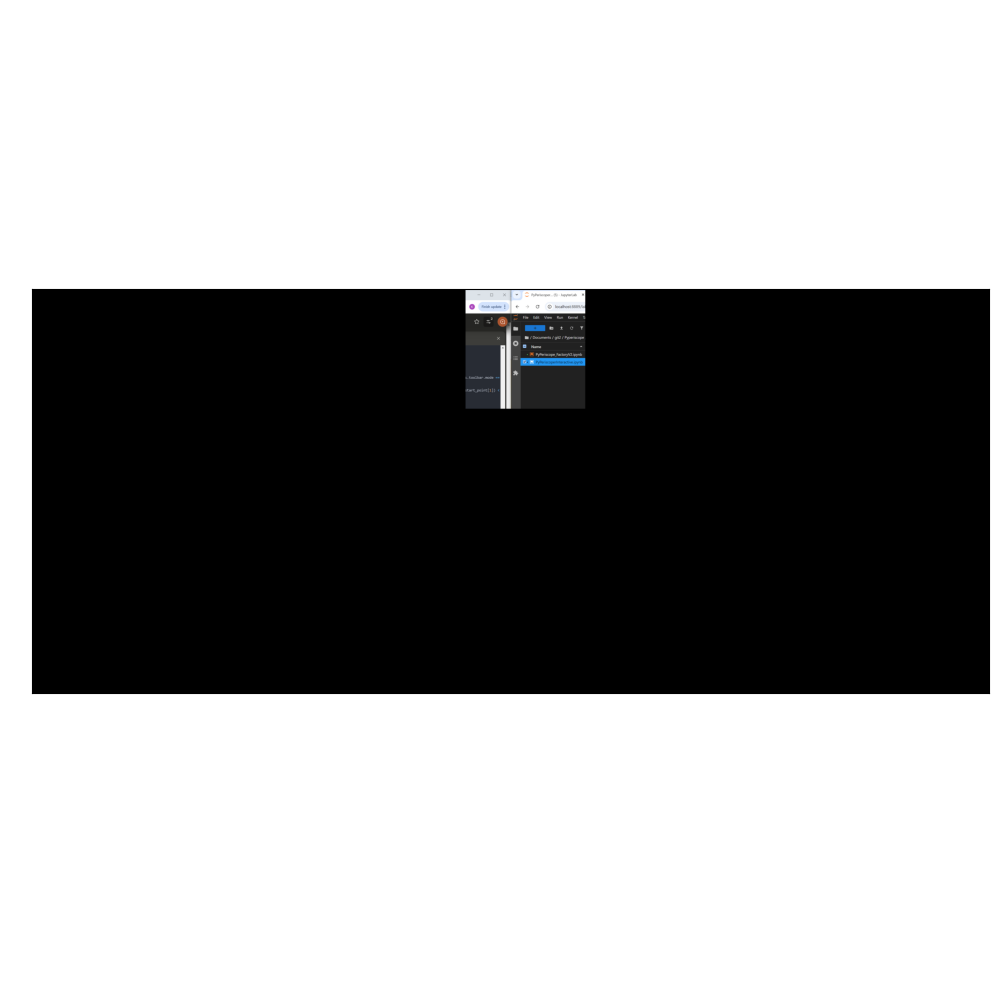

(np.int64(2557), np.int64(129), np.int64(45), np.int64(191))


In [156]:
def UpdateScopeInCollector(inscope):
    c = ClickCollector(inscope.full_image)
    dims = (inscope.found_locations[0]['area'][0],inscope.found_locations[0]['area'][1],
            inscope.found_locations[0]['area'][2] - inscope.found_locations[0]['area'][0],
            inscope.found_locations[0]['area'][3] - inscope.found_locations[0]['area'][1])
    c.set_positions(click_pos=inscope.found_locations[0]['mouse_offset'], box_dims=dims)
    return c